In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('Solarize_Light2')

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import seaborn as sns

import missingno as msno

import geopandas

from shapely.geometry import Point

import os
print(os.listdir("/Users/yc00027/Documents/air-quality-madrid/"))

import warnings
warnings.filterwarnings("ignore")

['.DS_Store', 'csvs_per_year', 'stations.csv', 'madrid.h5', '.ipynb_checkpoints']


# Air quality Madrid - EDA

### Extracting the data

In [2]:
# Extract data into a single dataframe

partials = list()

with pd.HDFStore(r'madrid.h5') as data:
    stations = [k[1:] for k in data.keys() if k != '/master']
    for station in stations:
        df = data[station]
        df['station'] = station
        partials.append(df)

df = pd.concat(partials).sort_index()
print(df.shape)
df.head()

(3808224, 18)


BEN  CH4    CO   EBE  MXY  NMHC  NO       NO_2         NOx  OXY   O_3       PM10  PM25  PXY       SO_2   TCH   TOL   station
date                                                                                                                                              
2001-01-01 01:00:00   NaN  NaN  1.23   NaN  NaN   NaN NaN  55.750000  127.199997  NaN  8.38  44.950001   NaN  NaN  14.560000   NaN   NaN  28079017
2001-01-01 01:00:00   NaN  NaN  0.72   NaN  NaN   NaN NaN  49.830002   74.040001  NaN  6.37  22.170000   NaN  NaN  28.290001   NaN   NaN  28079011
2001-01-01 01:00:00   NaN  NaN  1.20   NaN  NaN  0.05 NaN  43.849998   71.440002  NaN  5.50  23.790001   NaN  NaN  41.520000  1.46   NaN  28079012
2001-01-01 01:00:00   NaN  NaN  0.74   NaN  NaN   NaN NaN  49.410000   70.750000  NaN  2.49  36.820000   NaN  NaN   9.600000   NaN   NaN  28079039
2001-01-01 01:00:00  4.09  NaN  0.45  2.38  NaN   NaN NaN  67.120003  132.899994  NaN  7.86  32.349998   NaN  NaN  26.459999   NaN  11.7  28079008

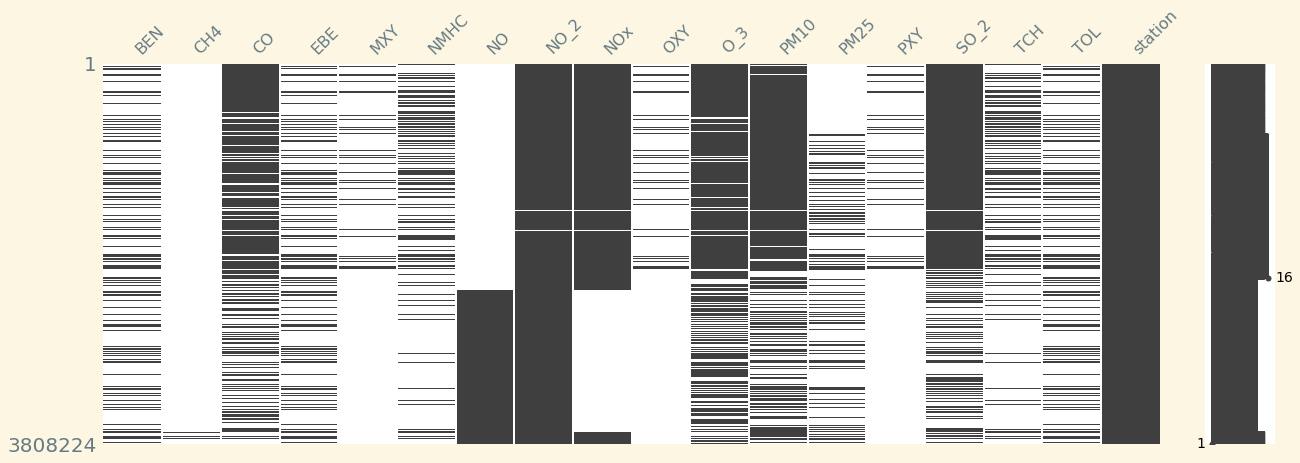

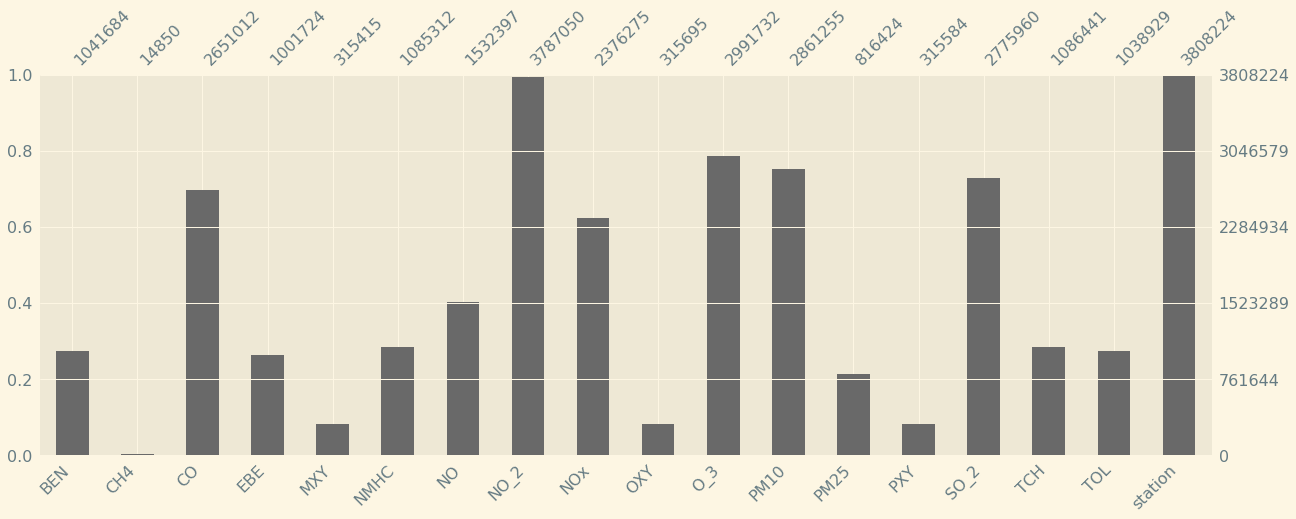

In [3]:
# Plot missing values 

msno.matrix(df.sort_index(), figsize = (21, 7))
plt.show()

msno.bar(df, figsize = (21, 7))
plt.show()

In [4]:
# Generate the entire time series 

unique_stations = df['station'].unique()

def generate_entire_time_series(stations, first_date, last_date):
    entire_time_series = []
    for station in stations:
        range_of_dates = pd.date_range(first_date, last_date, freq='H')
        range_of_dates = [{'station': station, 'date': date} for date in range_of_dates]
        entire_time_series.extend(range_of_dates)
    
    return pd.DataFrame(entire_time_series)

date_ranges = generate_entire_time_series(unique_stations, df.index.min(), df.index.max())

df_full = pd.merge(df.reset_index(), date_ranges, on=['date', 'station'], how='outer').set_index('date')
df_full.to_csv('full_madrid_air_quality.csv')

print(f'Original DF shape: {df.shape}')
print(f'Full DF shape: {df_full.shape}')
                   
df_full.sort_index().head()

Original DF shape: (3808224, 18)
Full DF shape: (5923944, 18)


BEN  CH4    CO   EBE   MXY  NMHC  NO       NO_2         NOx   OXY    O_3       PM10  PM25   PXY       SO_2   TCH   TOL   station
date                                                                                                                                                  
2001-01-01 01:00:00   NaN  NaN  1.23   NaN   NaN   NaN NaN  55.750000  127.199997   NaN   8.38  44.950001   NaN   NaN  14.560000   NaN   NaN  28079017
2001-01-01 01:00:00   NaN  NaN  1.85   NaN   NaN   NaN NaN  53.820000  123.699997   NaN   6.41  26.540001   NaN   NaN  35.720001   NaN   NaN  28079038
2001-01-01 01:00:00  2.13  NaN  0.87  1.44  3.16   NaN NaN  53.400002  100.000000  1.06   8.35  36.669998   NaN  1.28  11.420000   NaN  7.04  28079025
2001-01-01 01:00:00   NaN  NaN  0.91   NaN   NaN  0.09 NaN  46.470001   74.919998   NaN  10.14  22.420000   NaN   NaN  41.770000  1.29   NaN  28079007
2001-01-01 01:00:00   NaN  NaN   NaN   NaN   NaN   NaN NaN        NaN         NaN   NaN    NaN        NaN   NaN   NaN        NaN   NaN   NaN  28079001

### Choosing the particles of interest

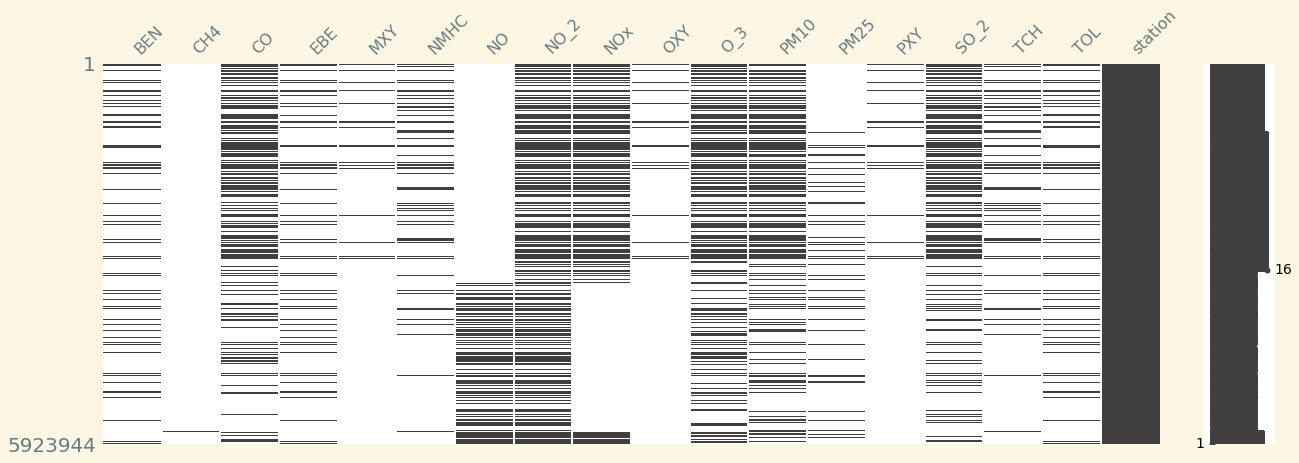

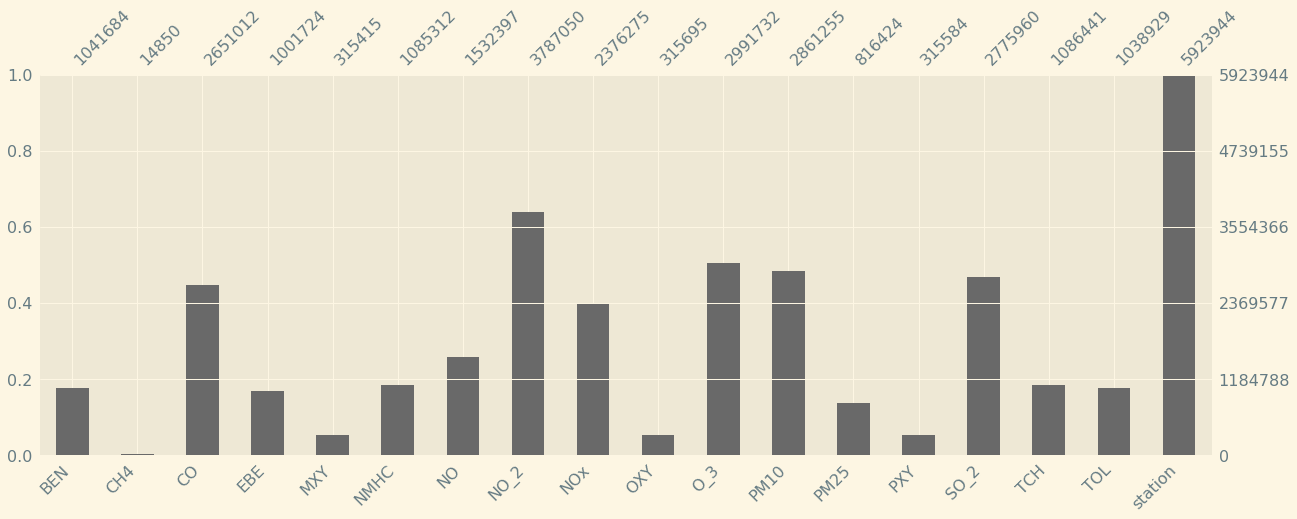

In [5]:
# Plot missing values for the complete dataframe

msno.matrix(df_full.sort_index(), figsize = (21, 7))
plt.show()

msno.bar(df_full, figsize = (21, 7))
plt.show()

([<matplotlib.axis.YTick at 0x121c4cf10>,
 <a list of 6 Text yticklabel objects>)

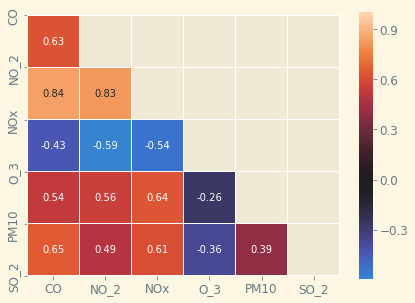

In [6]:
# Plot correlation between variables

to_drop = ['station', 'BEN', 'CH4', 'EBE', 'MXY', 'NMHC', 'NO', 'OXY', 'PM25', 'PXY', 'TCH', 'TOL']

corr = df_full.drop(to_drop, axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(7, 7))
plt.rc('font', size=10)  

sns.heatmap(corr, mask=mask, center=0, linewidths=.5, square=True, annot=True, cbar_kws={"shrink": .7})
plt.yticks(np.arange(6)+1, corr.index, va="center")

CO: carbon monoxide level measured in mg/m³. Carbon monoxide poisoning involves headaches, dizziness and confusion in short exposures and can result in loss of consciousness, arrhythmias, seizures or even death in the long term.

NO_2: nitrogen dioxide level measured in μg/m³. Long-term exposure is a cause of chronic lung diseases, and are harmful for the vegetation.

NOx: nitrous oxides level measured in μg/m³. Affect the human respiratory system worsening asthma or other diseases, and are responsible of the yellowish-brown color of photochemical smog.

O_3: ozone level measured in μg/m³. High levels can produce asthma, bronchytis or other chronic pulmonary diseases in sensitive groups or outdoor workers.

PM10: particles smaller than 10 μm level measured in μg/m³. Even though the cannot penetrate the alveolus, they can still penetrate through the lungs and affect other organs. Long term exposure can result in lung cancer and cardiovascular complications.

SO_2: sulphur dioxide level measured in μg/m³. High levels of sulphur dioxide can produce irritation in the skin and membranes, and worsen asthma or heart diseases in sensitive groups.

In [29]:
# Extract data for the particles of interest

particles_of_interest = ['NO_2', 'O_3', 'PM10', 'SO_2']

df_full['all_particles'] = df_full[particles_of_interest].sum(axis=1)

columns_of_interest = particles_of_interest + ['station'] + ['all_particles']

df_select = df_full[columns_of_interest].sort_index()

df_select['hour'] = df_select.index.hour
df_select['weekday'] = df_select.index.weekday
df_select['month'] = df_select.index.month
df_select['year'] = df_select.index.year
df_select['dayofyear'] = df_select.index.dayofyear

print(f'Original DF shape: {df_full.shape}')
print(f'Filtered DF shape: {df_select.shape}')

df_select.head()

Original DF shape: (5923944, 19)
Filtered DF shape: (5923944, 11)


NO_2    O_3       PM10       SO_2   station  all_particles  hour  weekday  month  year  dayofyear
date                                                                                                                       
2001-01-01 01:00:00  55.750000   8.38  44.950001  14.560000  28079017     123.640001     1        0      1  2001          1
2001-01-01 01:00:00  53.820000   6.41  26.540001  35.720001  28079038     122.490002     1        0      1  2001          1
2001-01-01 01:00:00  53.400002   8.35  36.669998  11.420000  28079025     109.840000     1        0      1  2001          1
2001-01-01 01:00:00  46.470001  10.14  22.420000  41.770000  28079007     120.800002     1        0      1  2001          1
2001-01-01 01:00:00        NaN    NaN        NaN        NaN  28079001       0.000000     1        0      1  2001          1

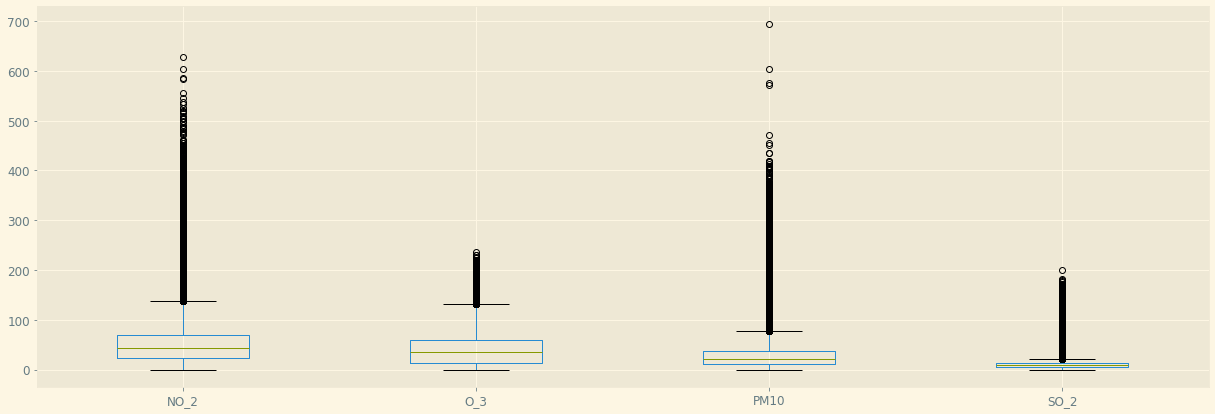

In [31]:
fig, ax = plt.subplots(figsize=(21, 7))
df_select[particles_of_interest].boxplot()

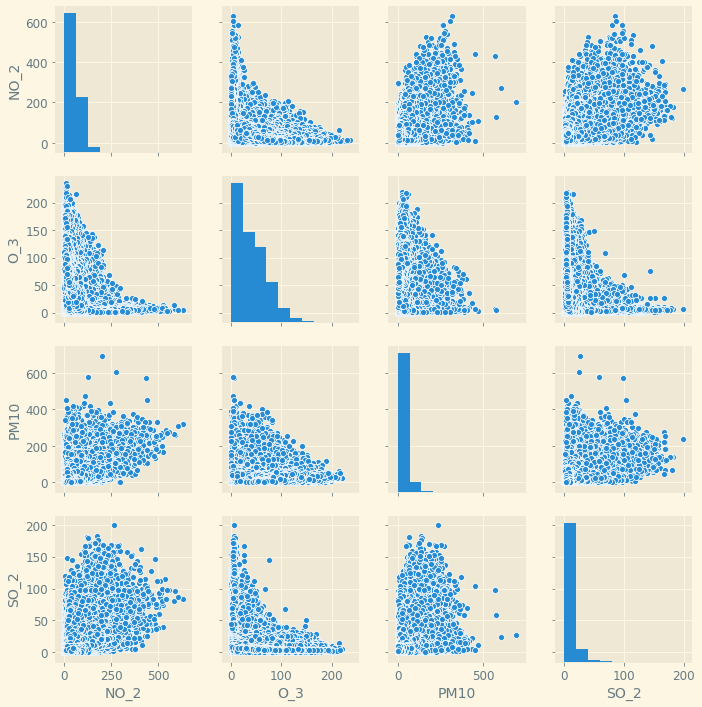

In [33]:
sns.pairplot(df_select[particles_of_interest])

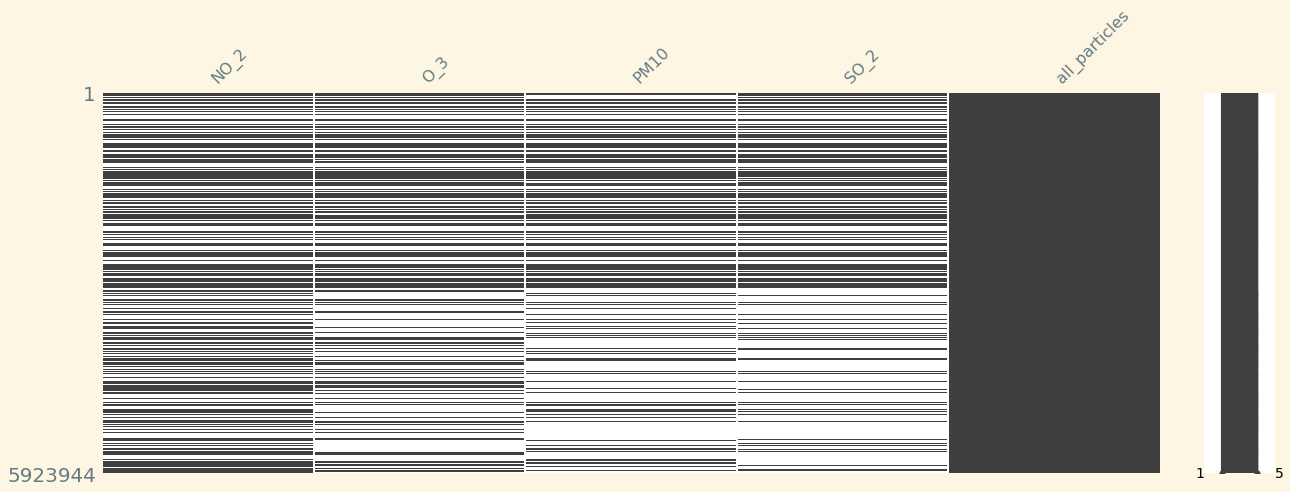

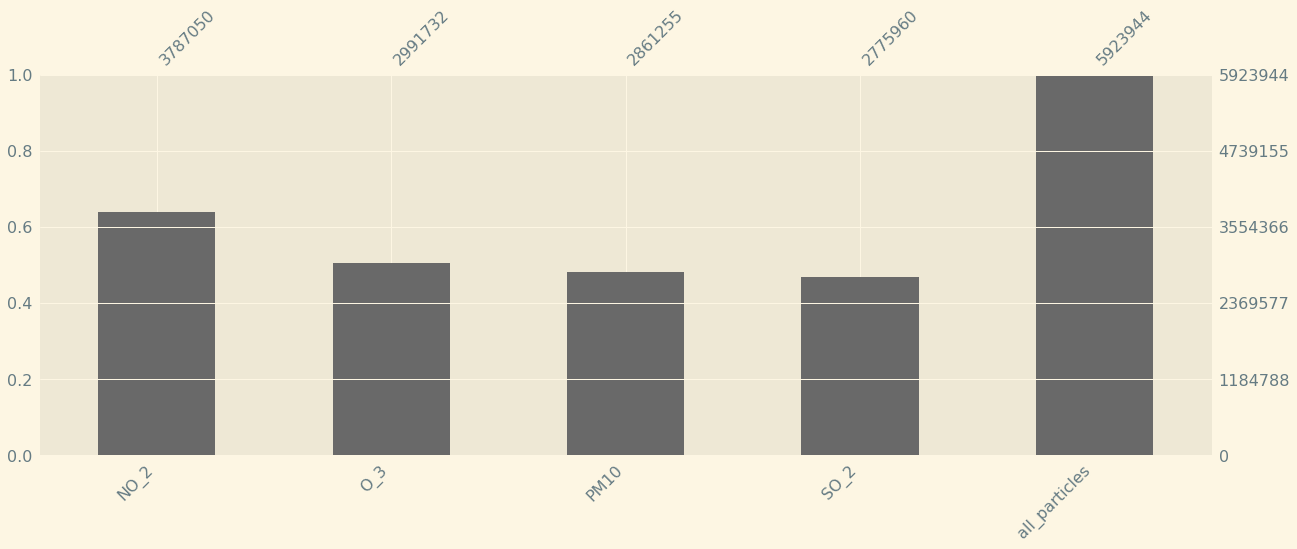

In [9]:
# Plot missing values for the particles of interest

msno.matrix(df_select[particles_of_interest].sort_index(), figsize = (21, 7))
plt.show()

msno.bar(df_select[particles_of_interest], figsize = (21, 7))
plt.show()

### Missing values per year

Text(0.5, 1.0, 'Percentage of missing data per year')

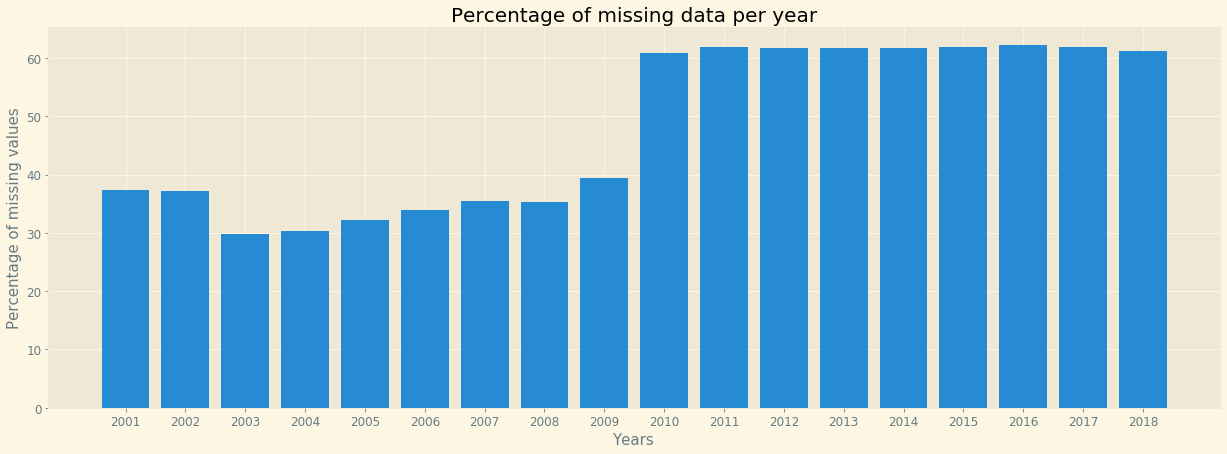

In [10]:
# Plot the percentage of missing values per year

percent_nulls_per_year = df_select.set_index('year').isnull().sum(axis=1).groupby('year') \
                        .apply(lambda x: x.sum()/(x.count() * 4) * 100)

fig, ax = plt.subplots(figsize=(21, 7))
ax.bar(np.arange(len(percent_nulls_per_year.index)), percent_nulls_per_year.values)
ax.set_xticks(np.arange(len(percent_nulls_per_year)))
ax.set_xticklabels(percent_nulls_per_year.index)
plt.xlabel('Years', fontsize=15)
plt.ylabel('Percentage of missing values', fontsize=15)
plt.title('Percentage of missing data per year', fontsize=20)

### Missing values per station

In [11]:
# Extract station locations into a separate dataframe

df_stations = pd.read_hdf('madrid.h5', key='master')
df_stations['name_id'] = df_stations['name'] +' ID: ' + df_stations['id'].astype(str)

print(df_stations.shape)
df_stations.head(1)

(24, 7)


id            name          address       lon        lat  elevation                      name_id
0  28079004  Pza. de España  Plaza de España -3.712247  40.423853        635  Pza. de España ID: 28079004

In [12]:
# Map the locations of the stations

locations  = df_stations[['lat', 'lon']]
locationlist = locations.values.tolist()

popup = df_stations[['name_id']]

import folium
map_osm = folium.Map(location=[40.44, -3.69], zoom_start=11) 

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=popup.iloc[point,0]).add_to(map_osm)
    
map_osm

In [13]:
# Check if number of stations and station ID match 

print(df_stations['id'].nunique())
print(np.sort(df_stations['id'].unique()))
print('')
print(df_select['station'].nunique())
print(np.sort(df_select['station'].unique()))

24
[28079004 28079008 28079011 28079016 28079017 28079018 28079024 28079027
 28079035 28079036 28079038 28079039 28079040 28079047 28079048 28079049
 28079050 28079054 28079055 28079056 28079057 28079058 28079059 28079060]

39
['28079001' '28079003' '28079004' '28079006' '28079007' '28079008'
 '28079009' '28079011' '28079012' '28079014' '28079015' '28079016'
 '28079017' '28079018' '28079019' '28079021' '28079022' '28079023'
 '28079024' '28079025' '28079026' '28079027' '28079035' '28079036'
 '28079038' '28079039' '28079040' '28079047' '28079048' '28079049'
 '28079050' '28079054' '28079055' '28079056' '28079057' '28079058'
 '28079059' '28079060' '28079099']


Text(0.5, 1.0, 'Percentage of missing data per station')

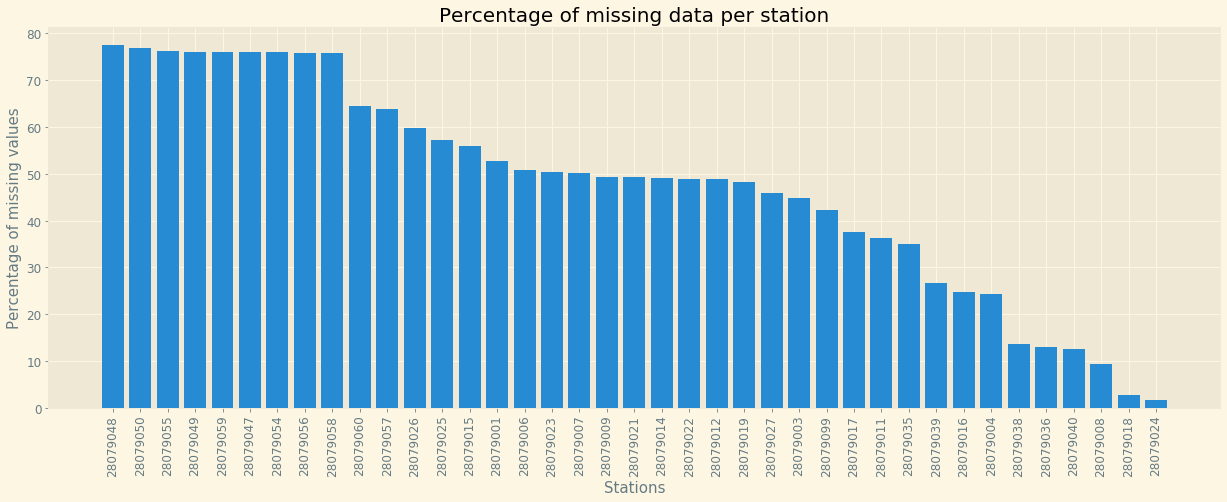

In [14]:
# Plot the percentage of missing values per station

percent_nulls_per_station = df_select.set_index('station').isnull().sum(axis=1).groupby('station') \
.apply(lambda x: x.sum()/(x.count() * 4) * 100).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(21, 7))

ax.bar(np.arange(len(percent_nulls_per_station.index)), percent_nulls_per_station.values)

ax.set_xticks(np.arange(len(percent_nulls_per_station)))
ax.set_xticklabels([station for station in percent_nulls_per_station.index])

plt.xticks(rotation='90')
plt.xlabel('Stations', fontsize=15)
plt.ylabel('Percentage of missing values', fontsize=15)
plt.title('Percentage of missing data per station', fontsize=20)

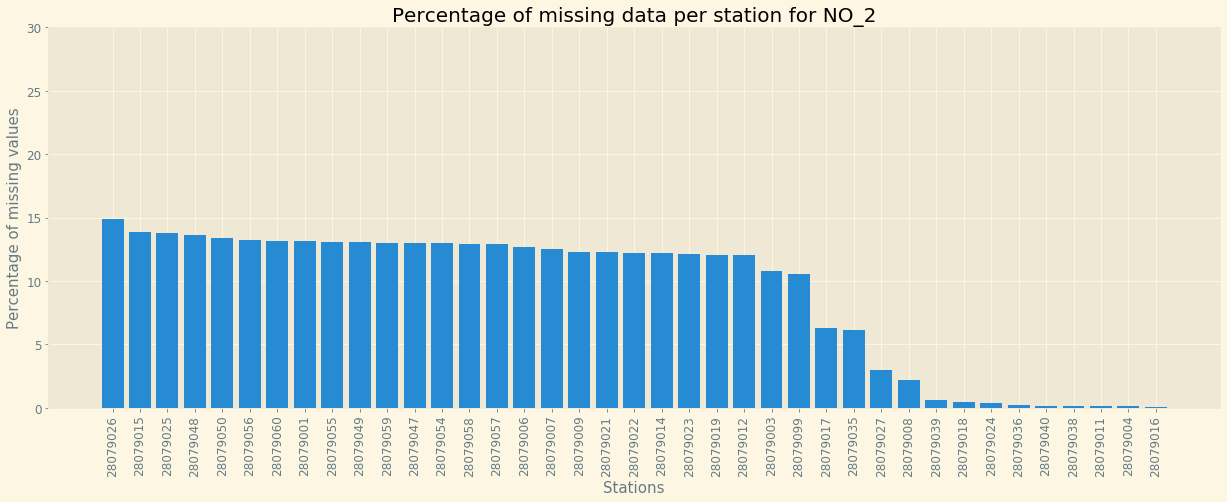

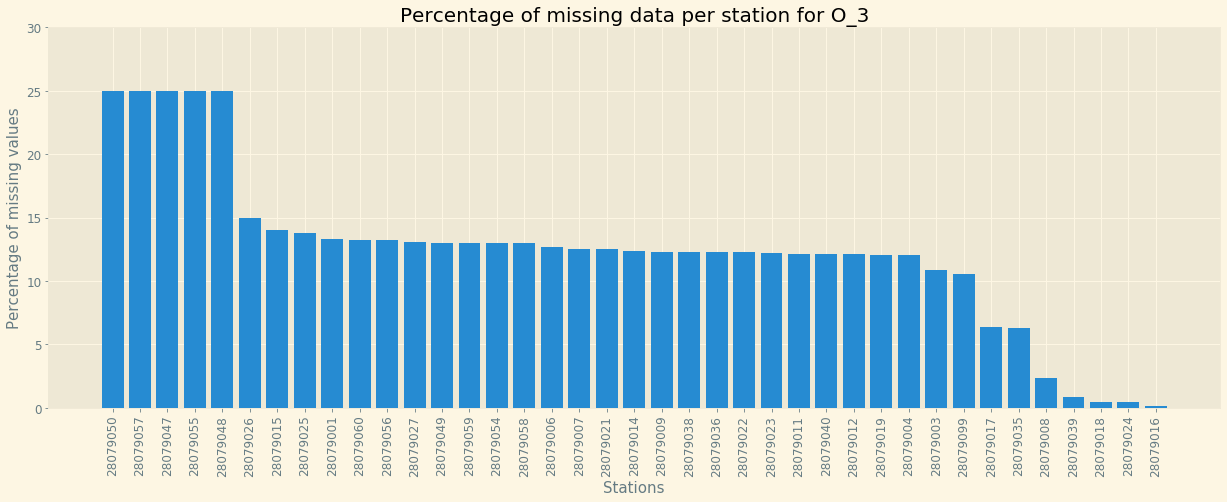

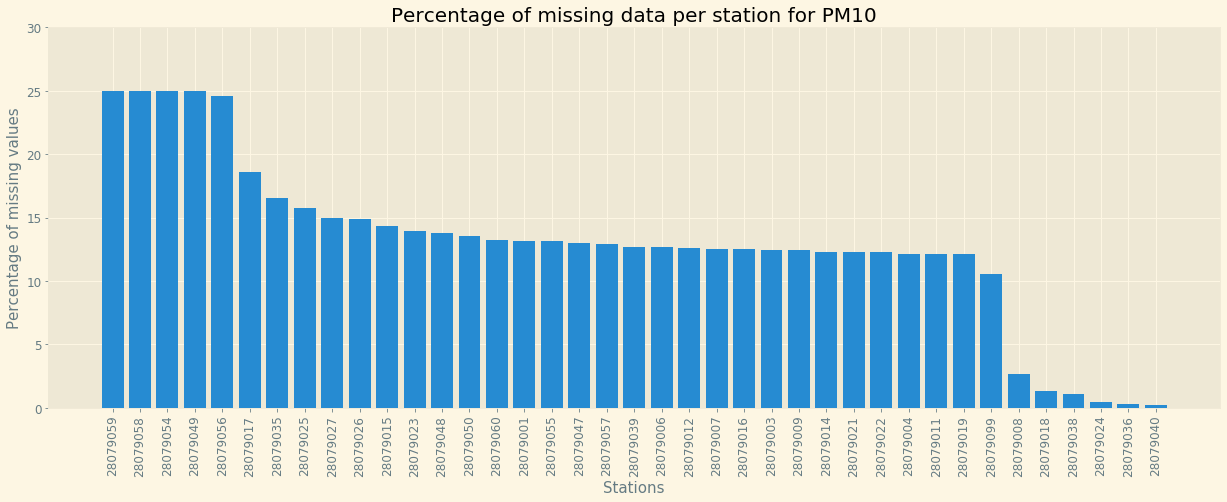

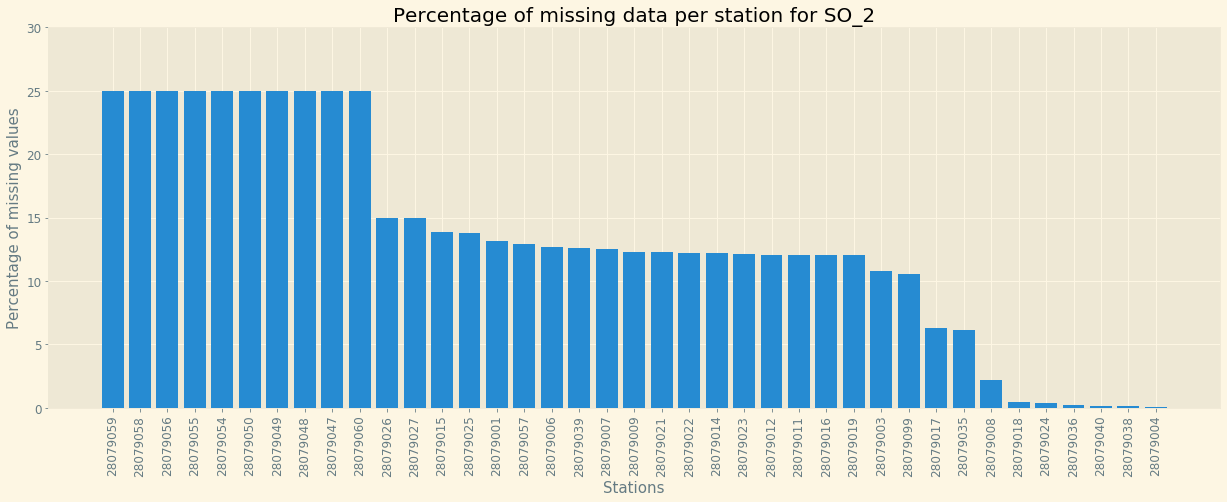

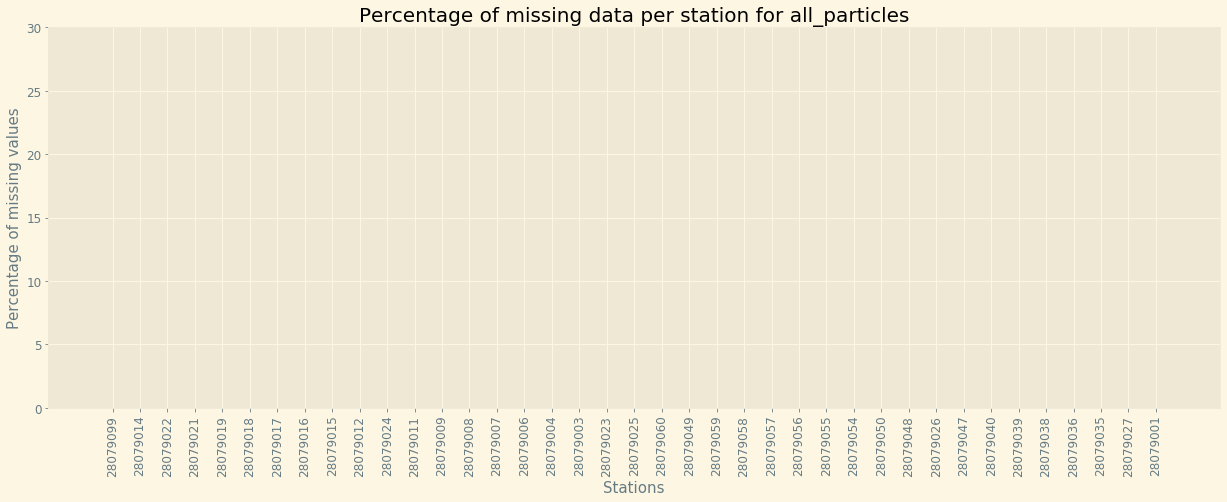

In [15]:
# Plot the percentage of missing values per station per particle

for particle in particles_of_interest:
    
    percent_nulls = df_select[[particle, 'station']].set_index('station').isnull().sum(axis=1).groupby('station') \
    .apply(lambda x: x.sum()/(x.count() * 4) * 100).sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(21, 7))

    ax.bar(np.arange(len(percent_nulls.index)), percent_nulls.values)

    ax.set_xticks(np.arange(len(percent_nulls)))
    ax.set_xticklabels([station for station in percent_nulls.index])
    ax.set_ylim(0, 30)

    plt.xticks(rotation='90')
    plt.xlabel('Stations', fontsize=15)
    plt.ylabel('Percentage of missing values', fontsize=15)
    plt.title(f'Percentage of missing data per station for {particle}', fontsize=20)

### Visualize missing data for stations and particles of interest

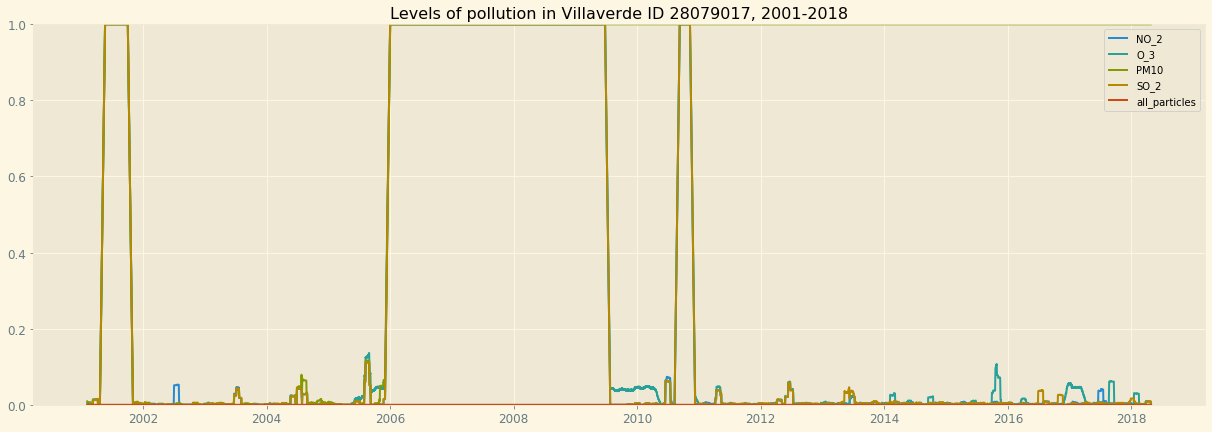

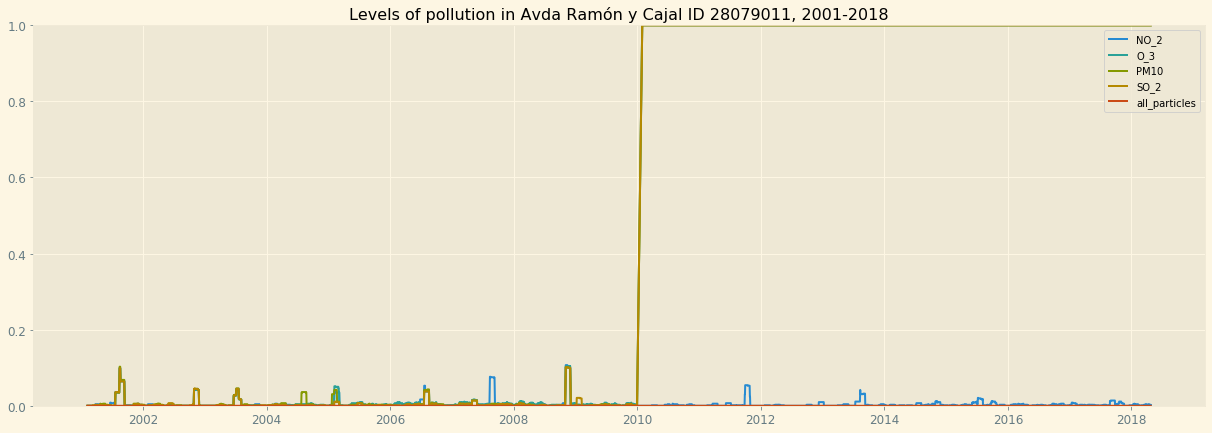

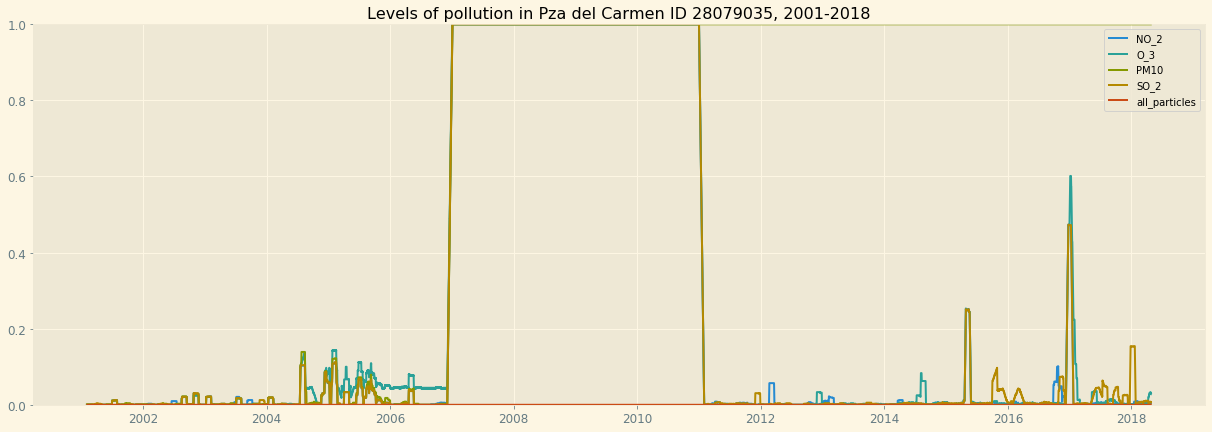

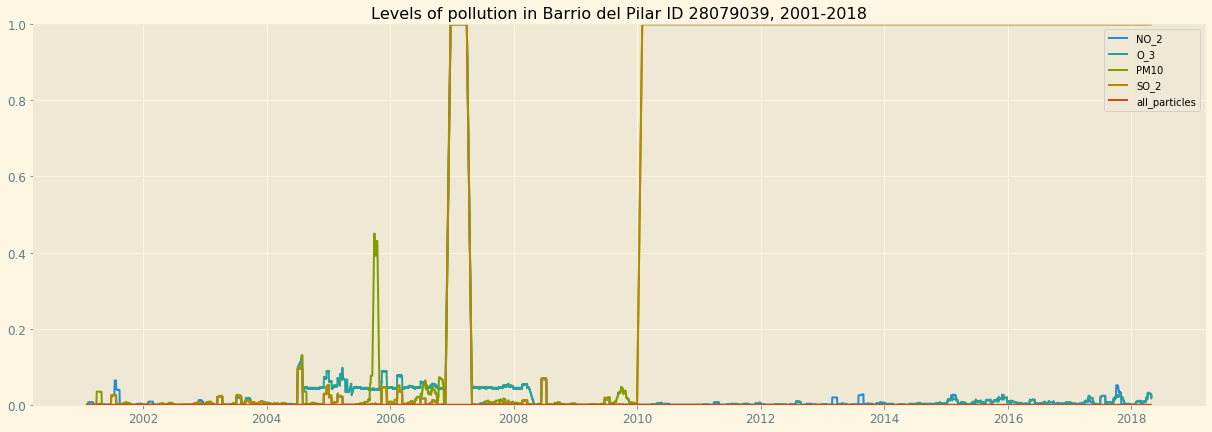

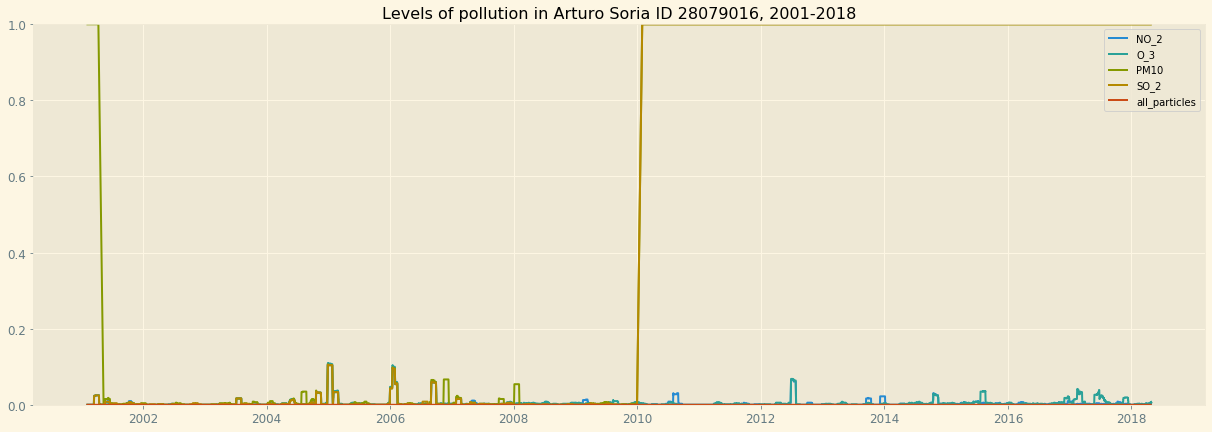

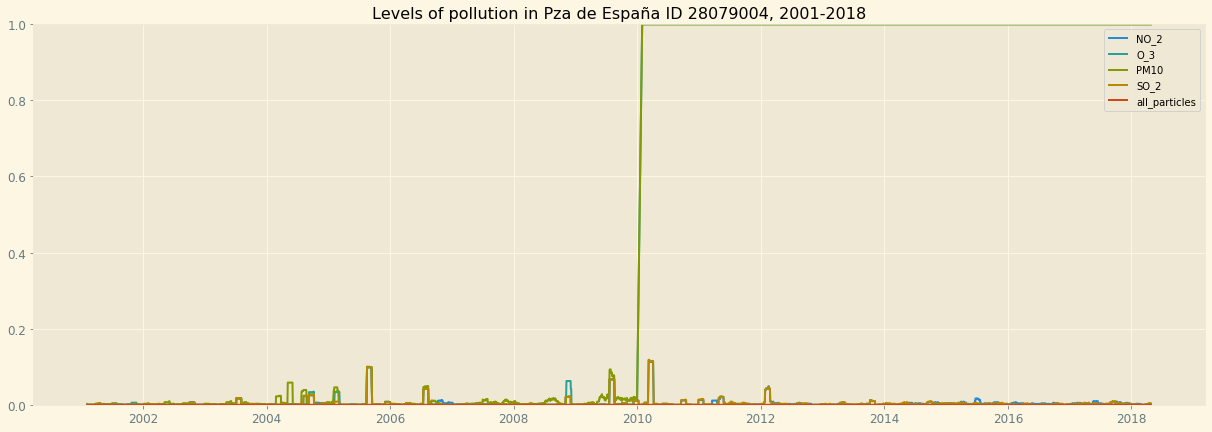

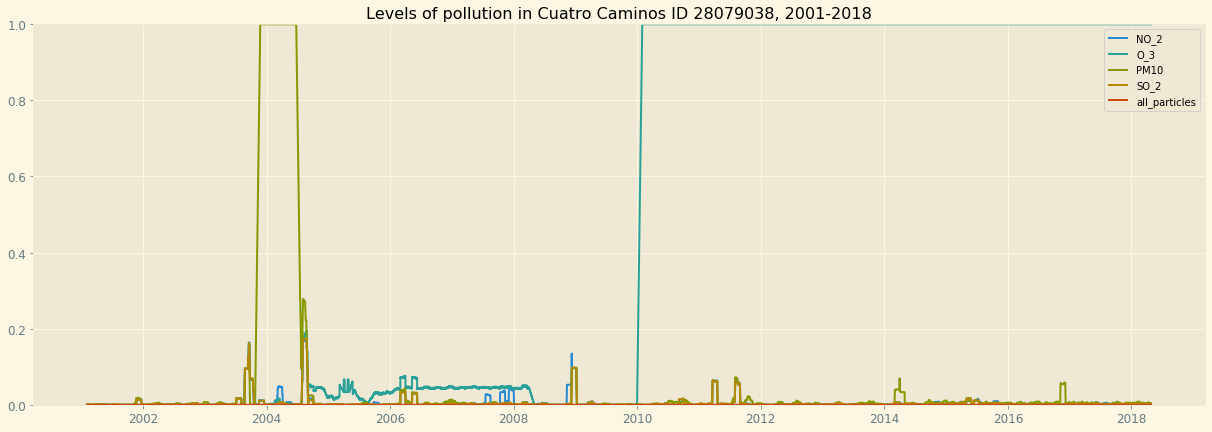

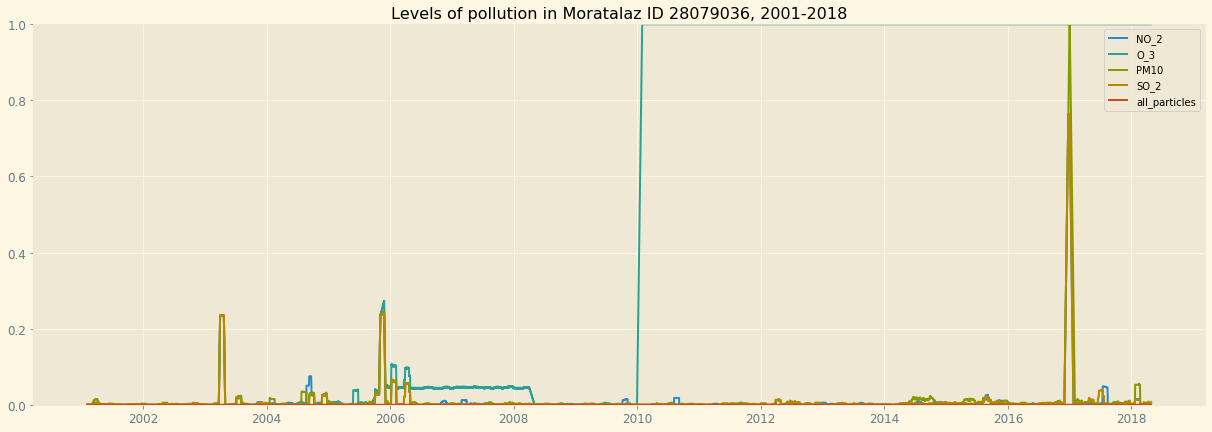

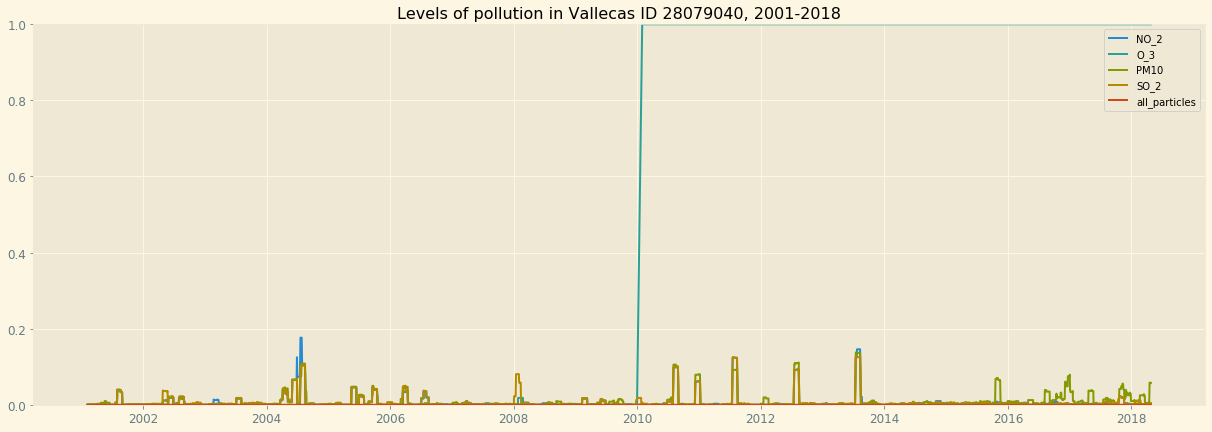

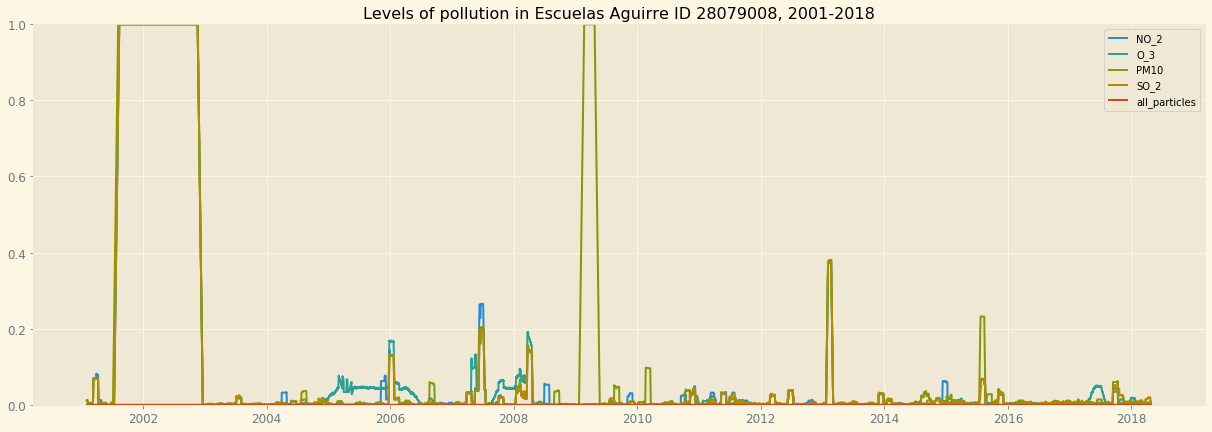

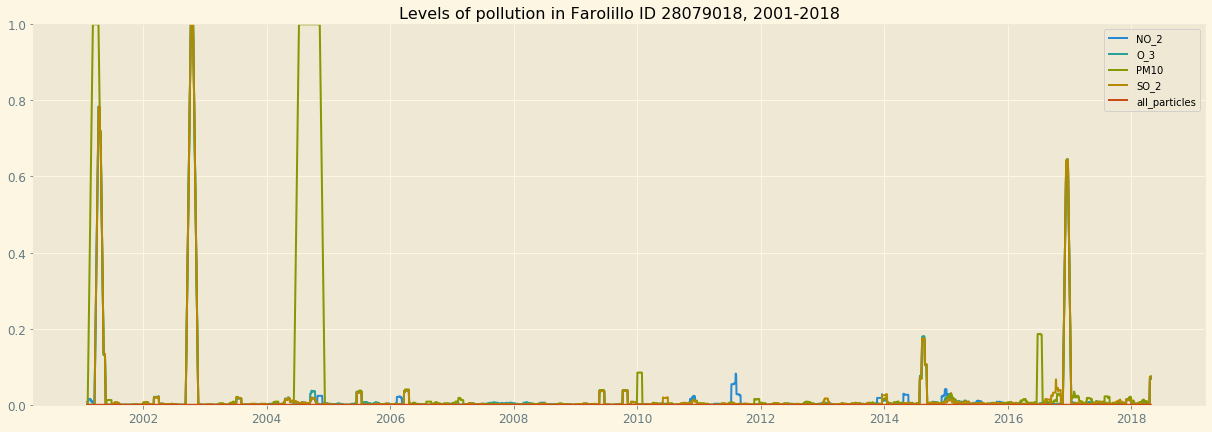

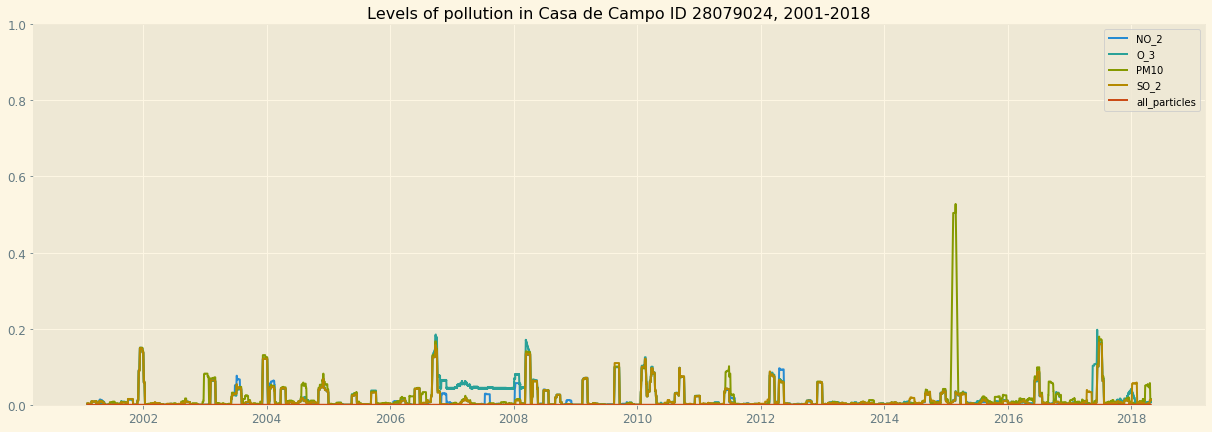

In [16]:
# Plot percentage of missing values per particle per month for all stations of interest

import re

stations_of_interest = list(percent_nulls_per_station[percent_nulls_per_station.values < 40].index)

first_date = '2001-01-01 00:00:00'
last_date = '2018-04-30 23:00:00'

for station in stations_of_interest:
    
    fig, ax = plt.subplots(figsize=(21, 7))
    data_single_station = df_select.loc[df_select['station'] == station].loc[first_date:last_date].sort_index()
    station_name = str(df_stations[df_stations['id'].astype(str) == station]['name_id'].values)
    station_name = re.sub(r'([^\s\w]|_)+', '', station_name)
    
    for particle in particles_of_interest:
        
        ax.plot(data_single_station[particle].isnull().rolling(window=24*30).mean(), label=particle)
        ax.set_ylim(0, 1)
        plt.title(f'Levels of pollution in {station_name}, 2001-2018')
        plt.legend()

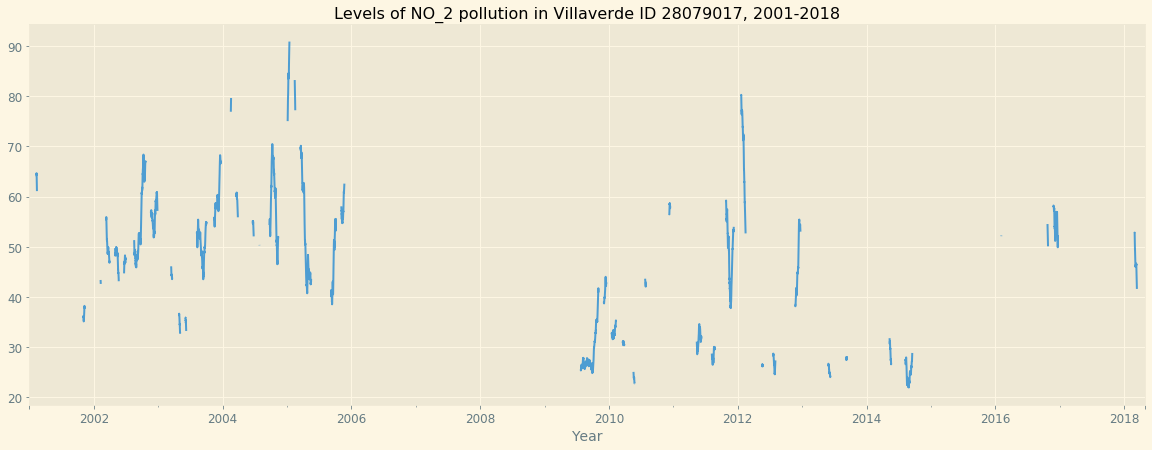

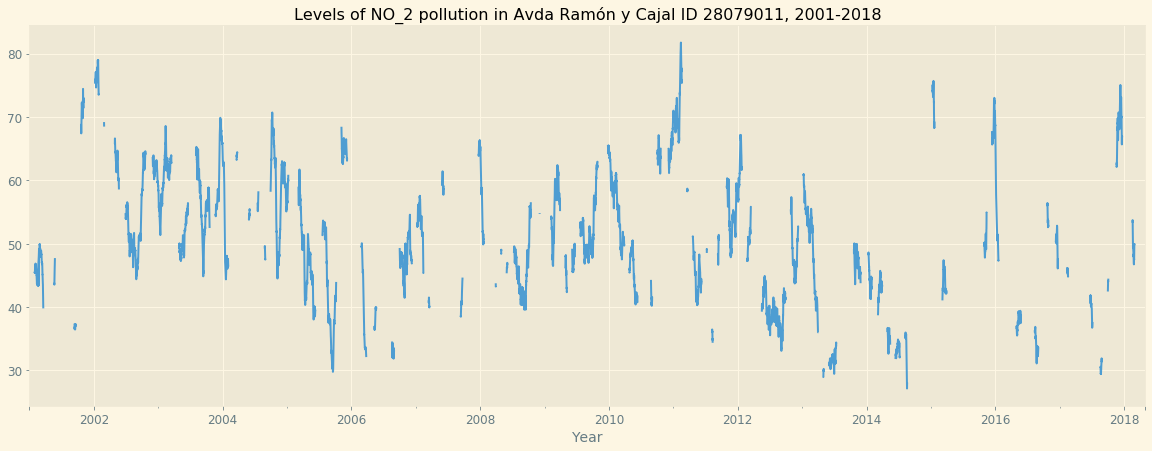

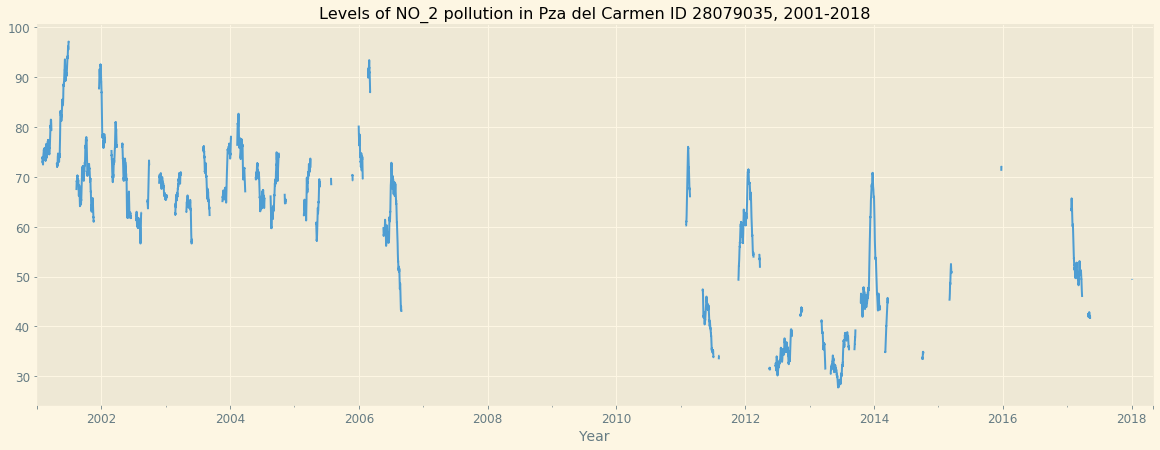

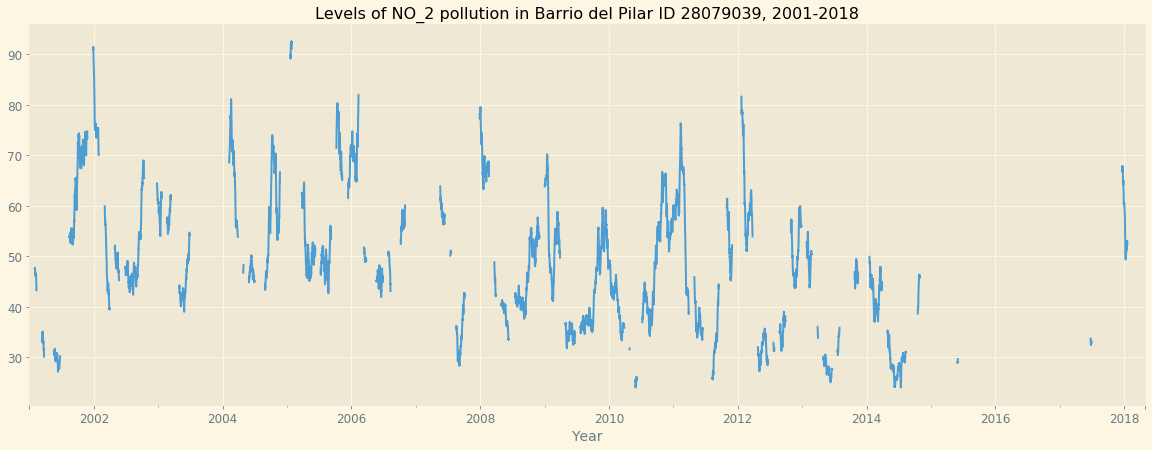

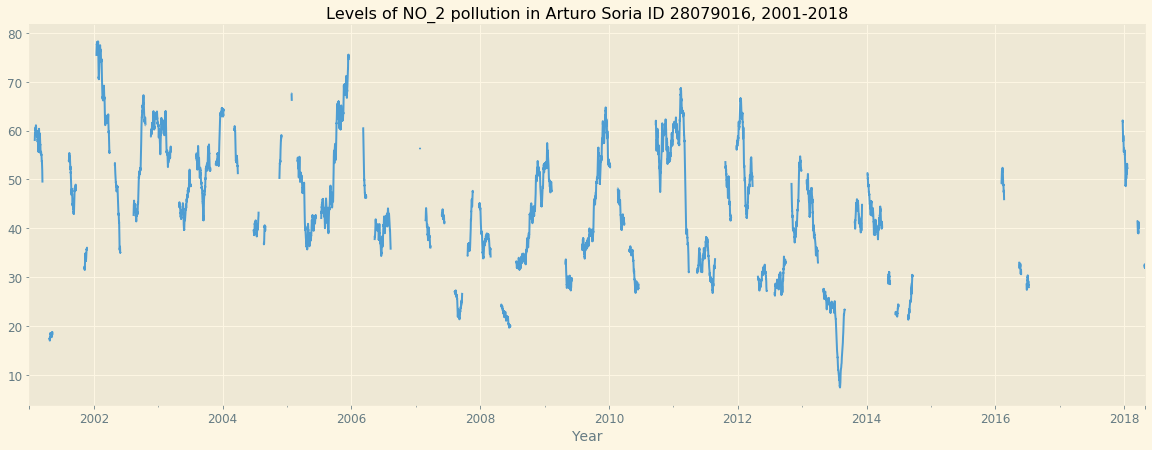

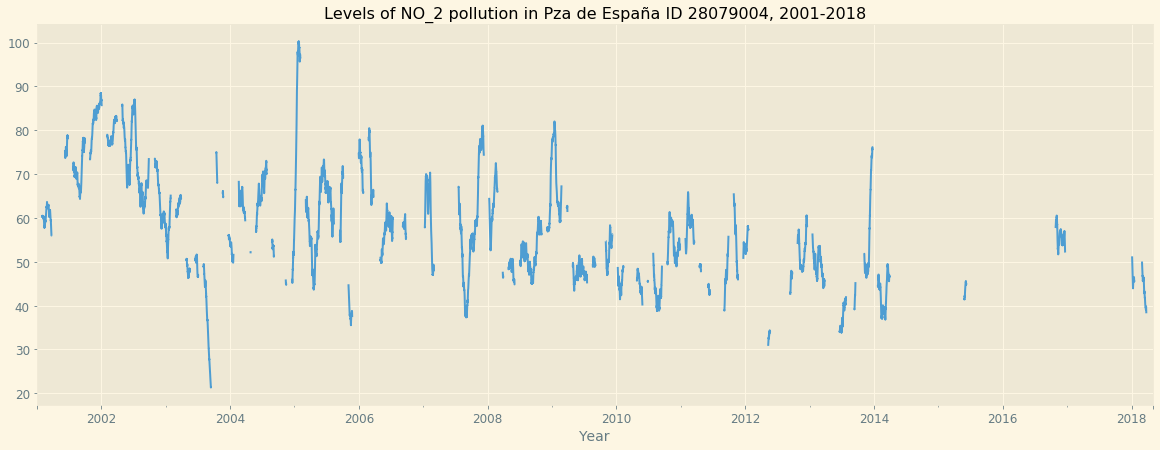

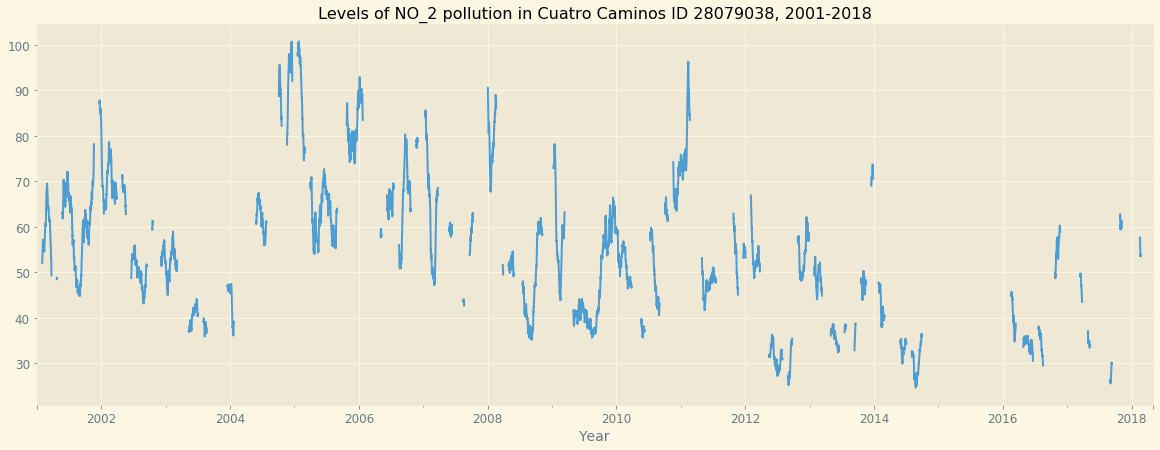

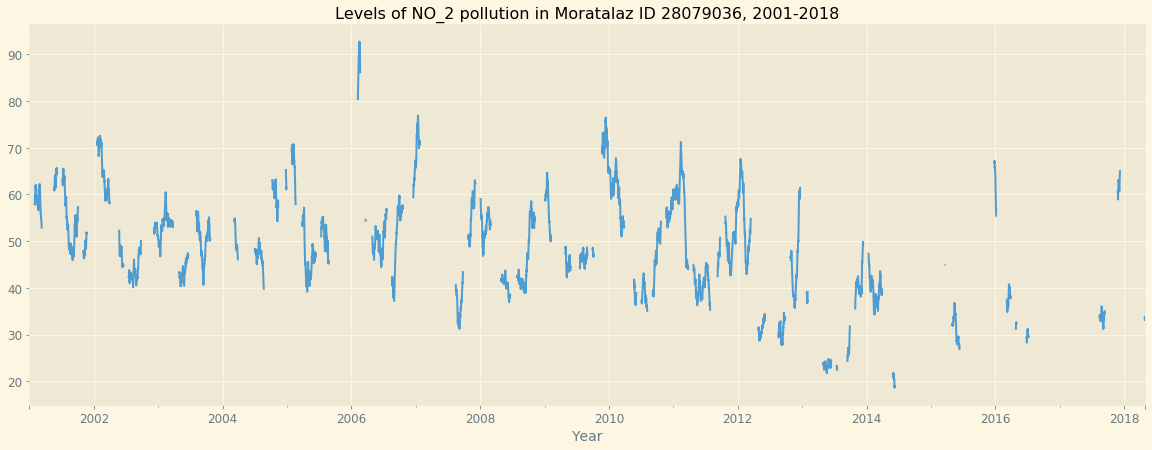

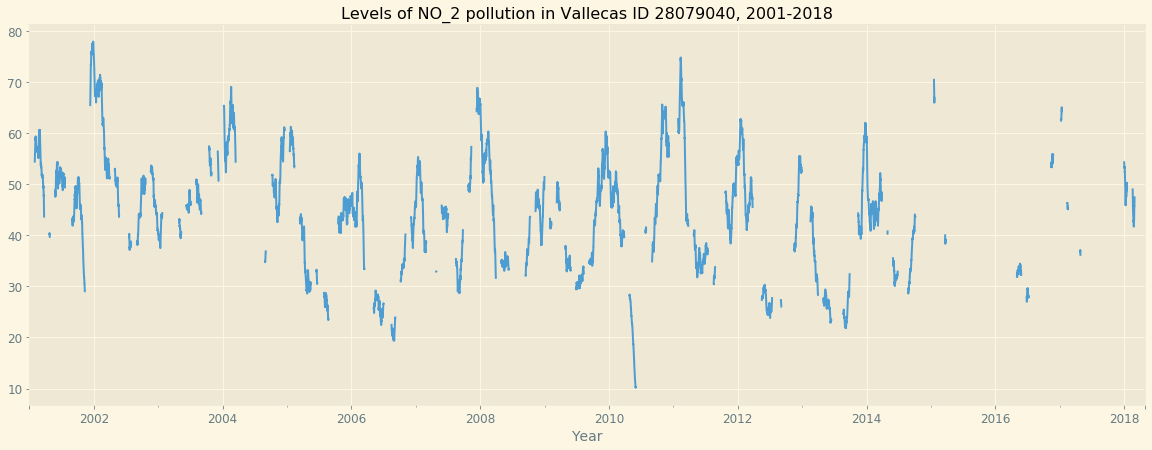

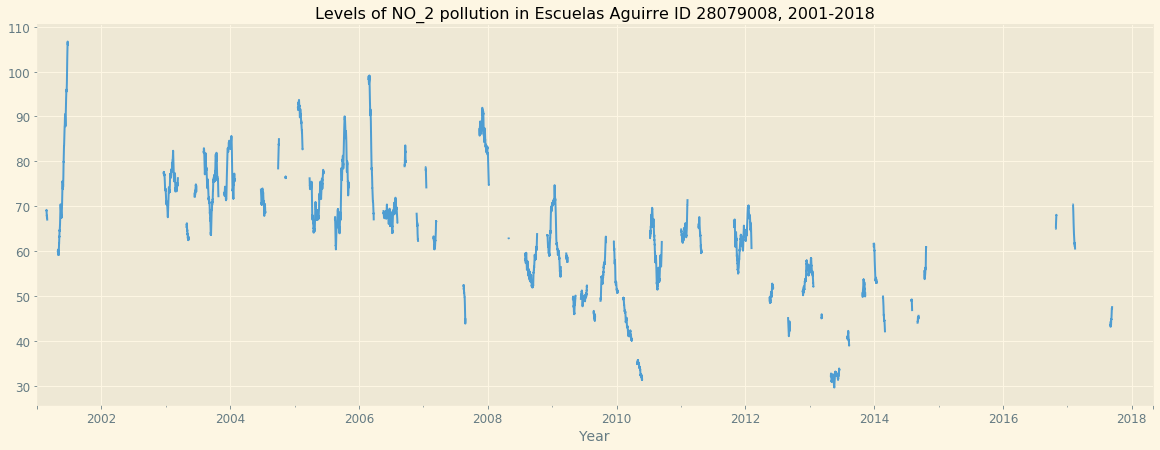

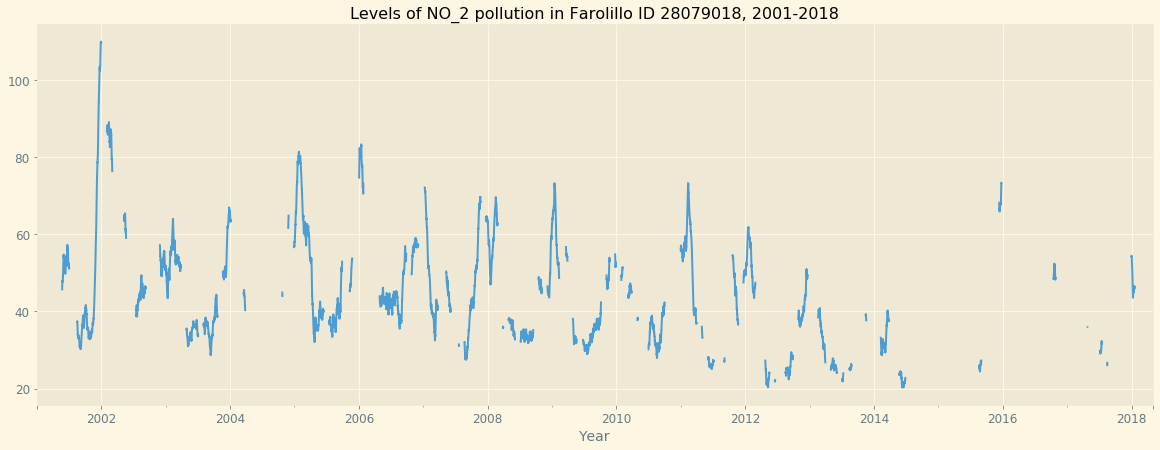

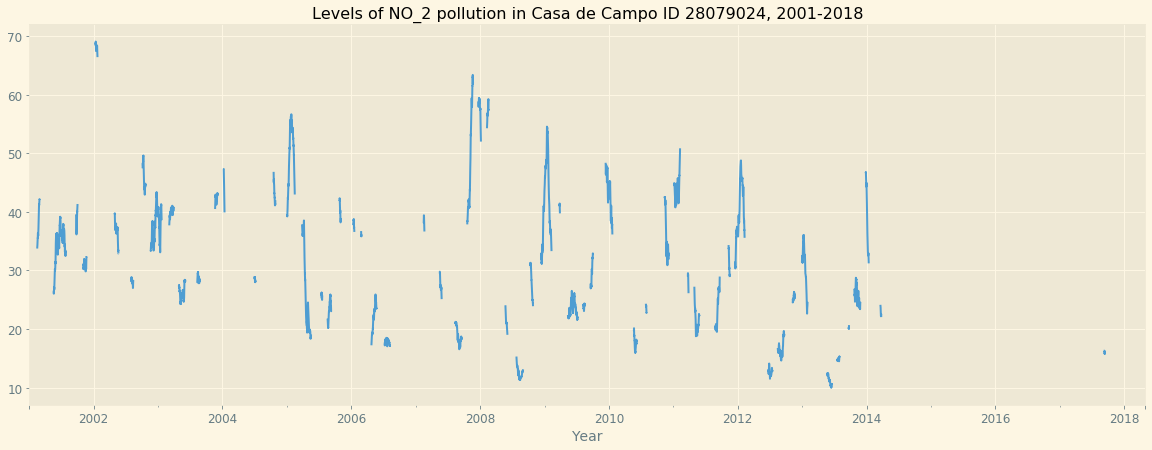

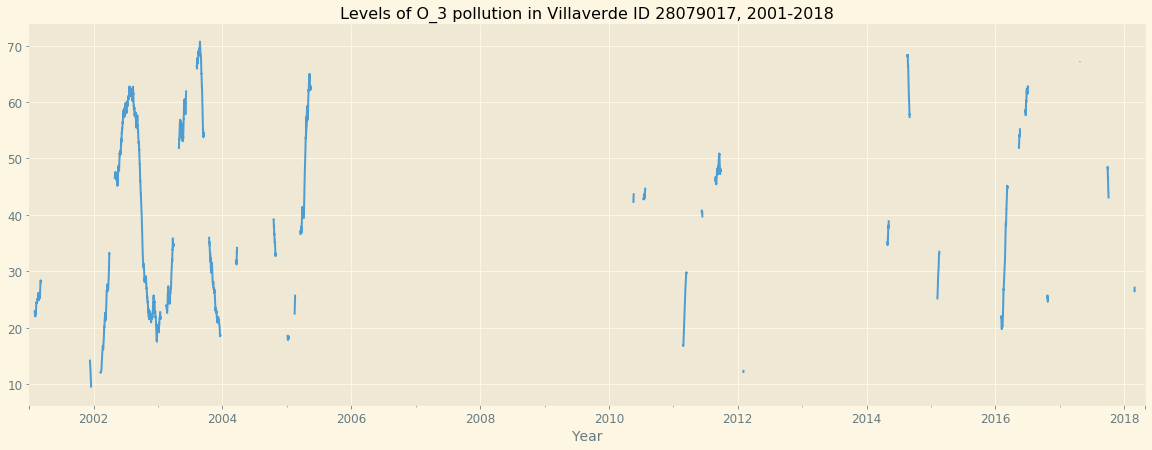

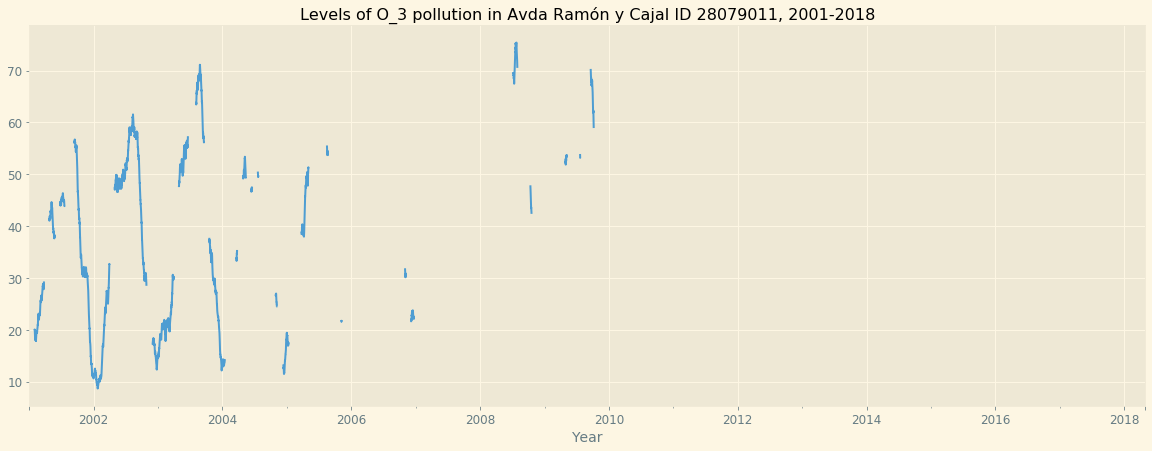

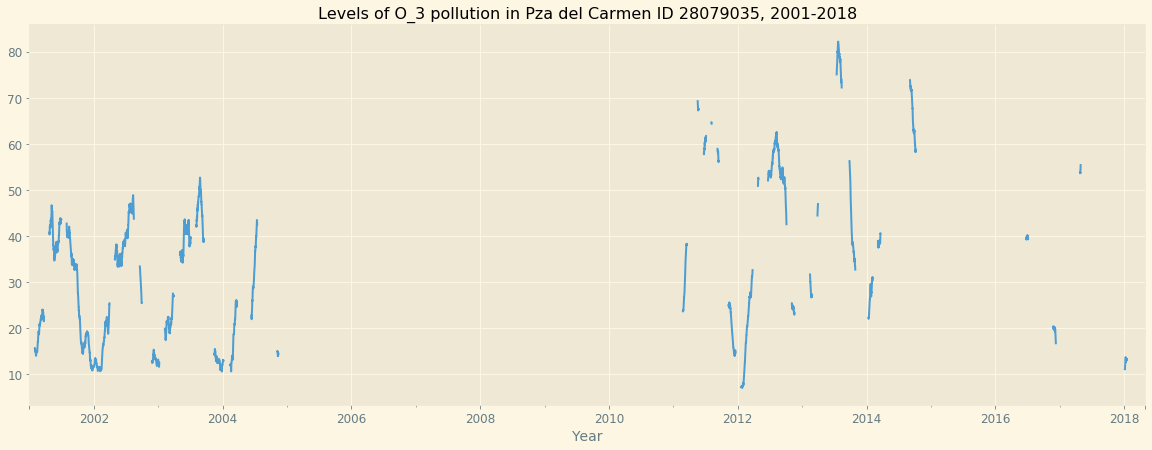

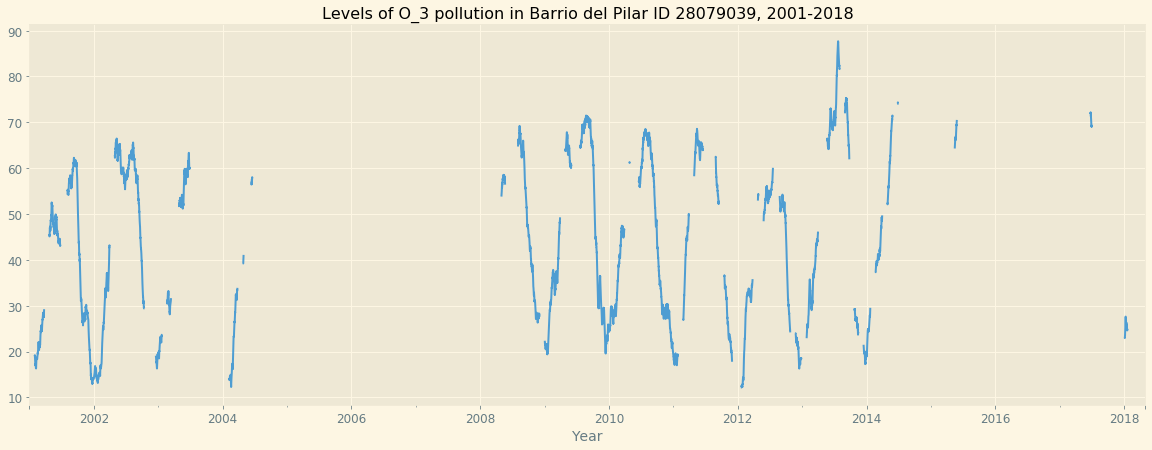

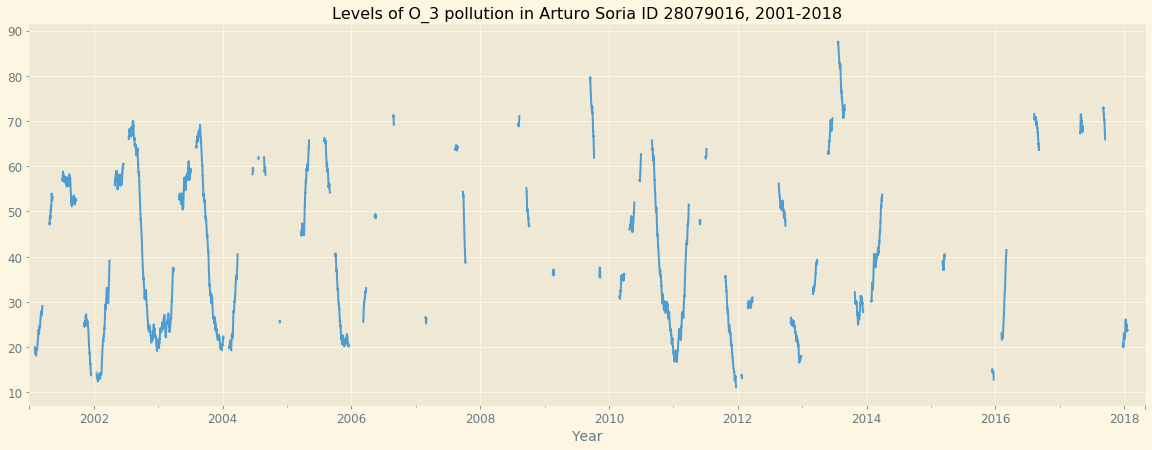

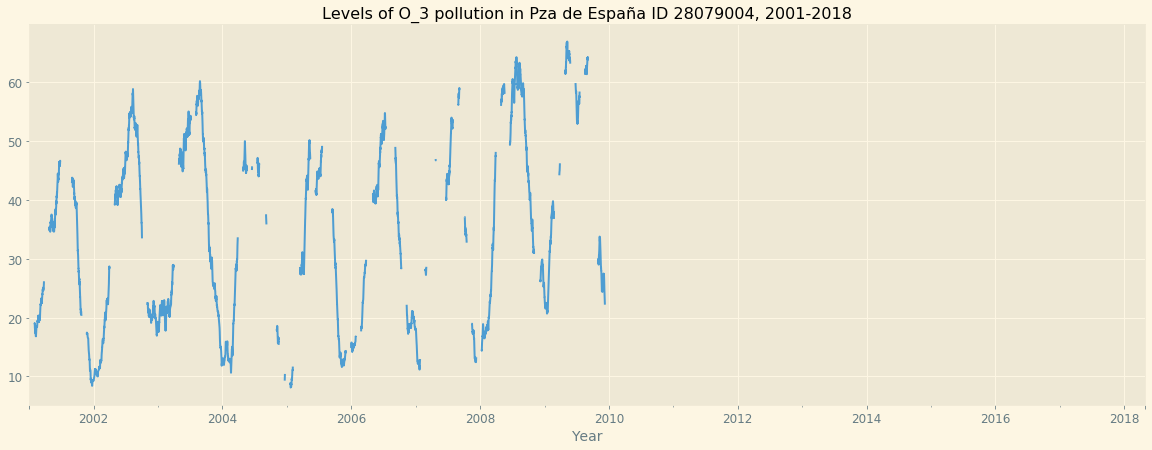

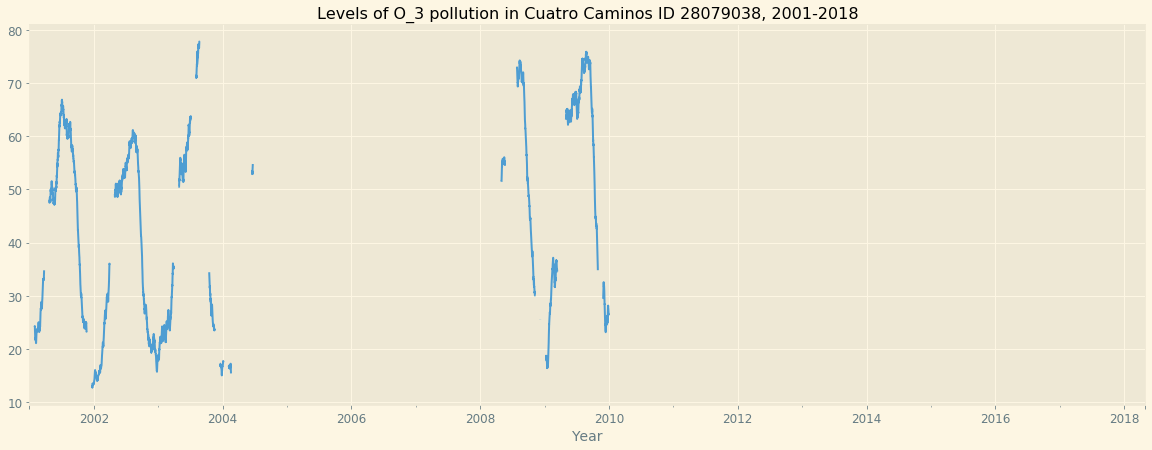

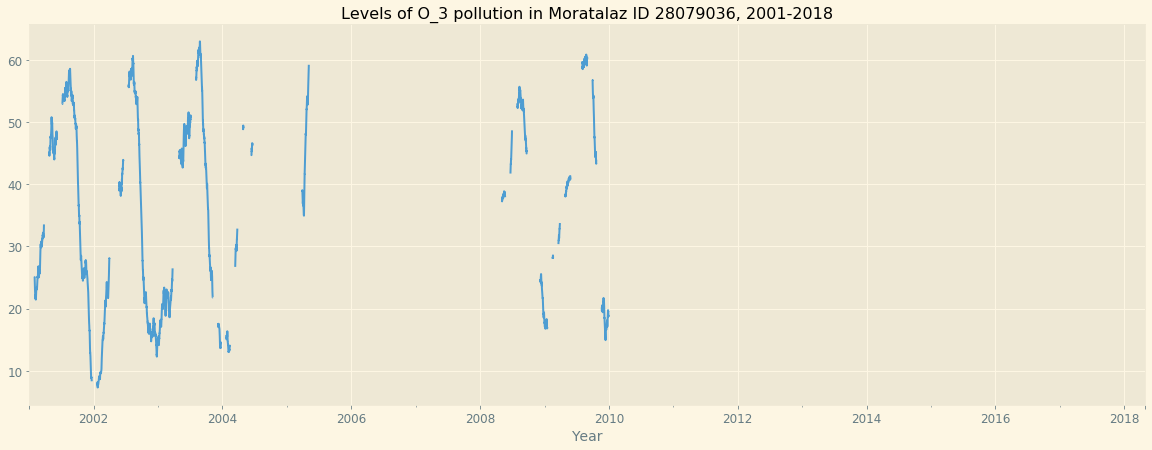

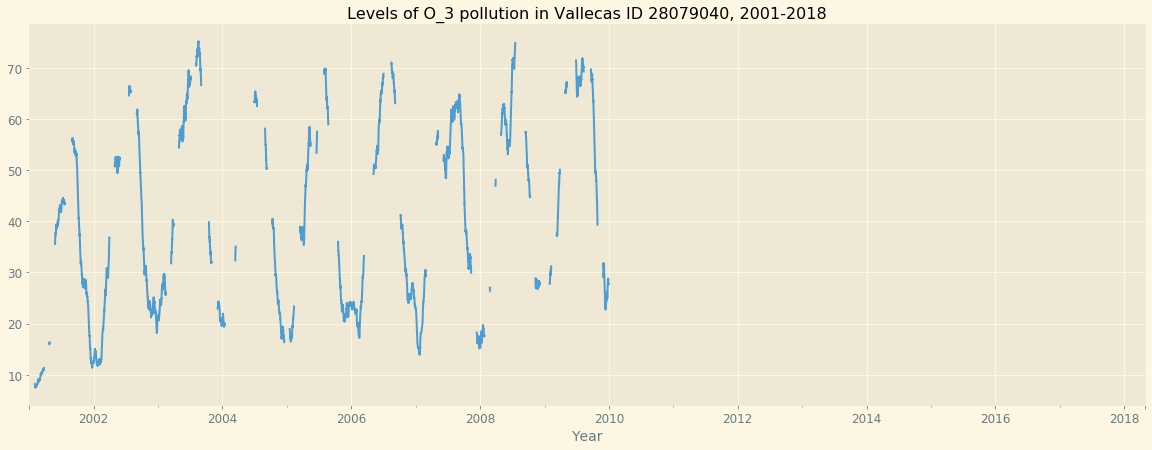

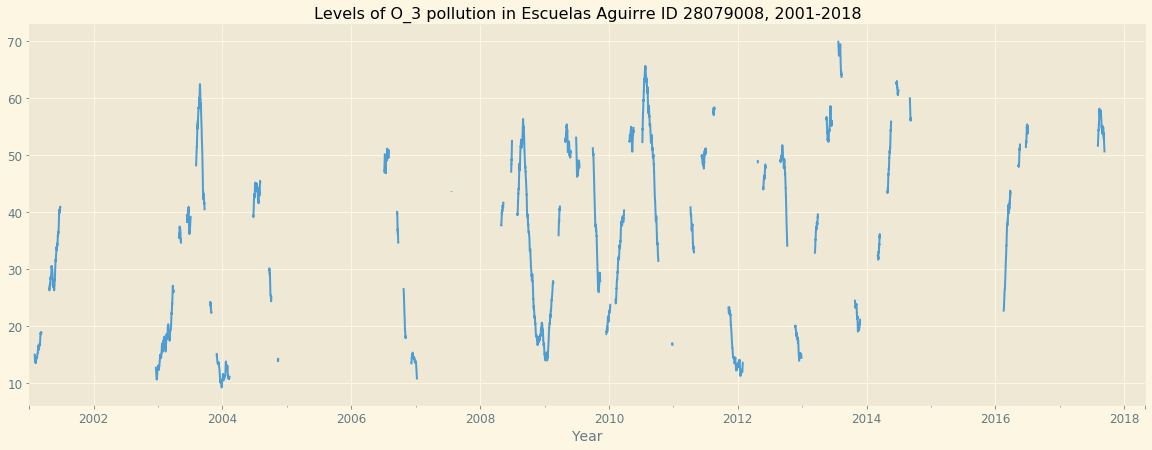

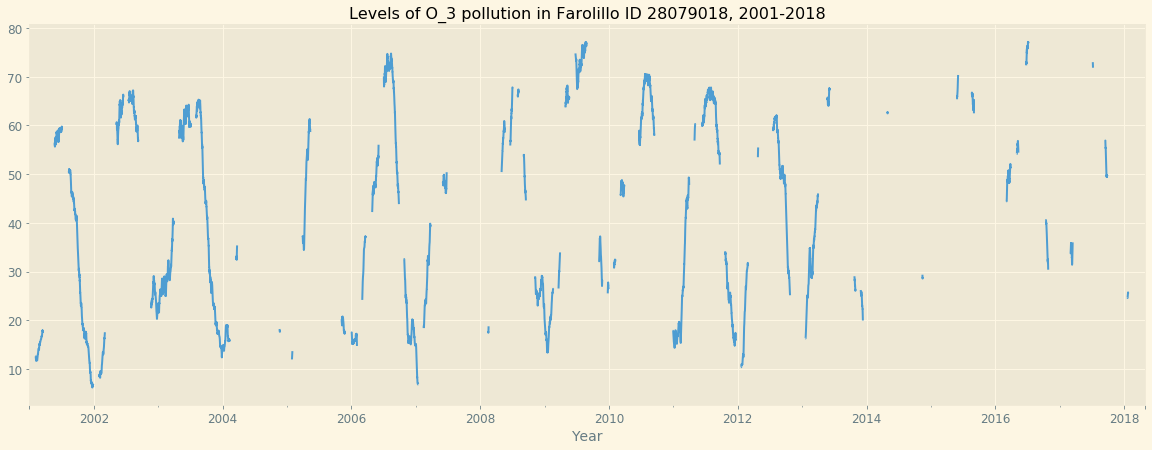

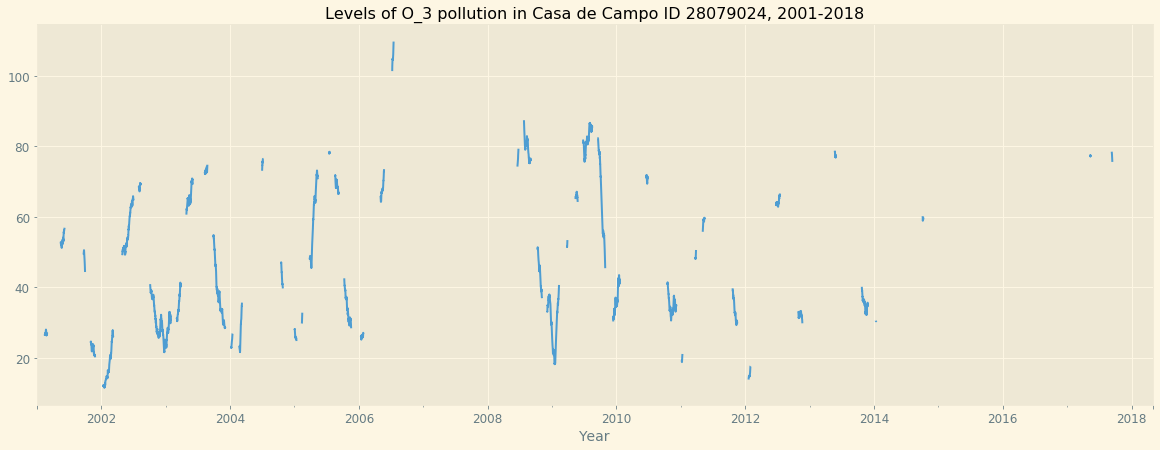

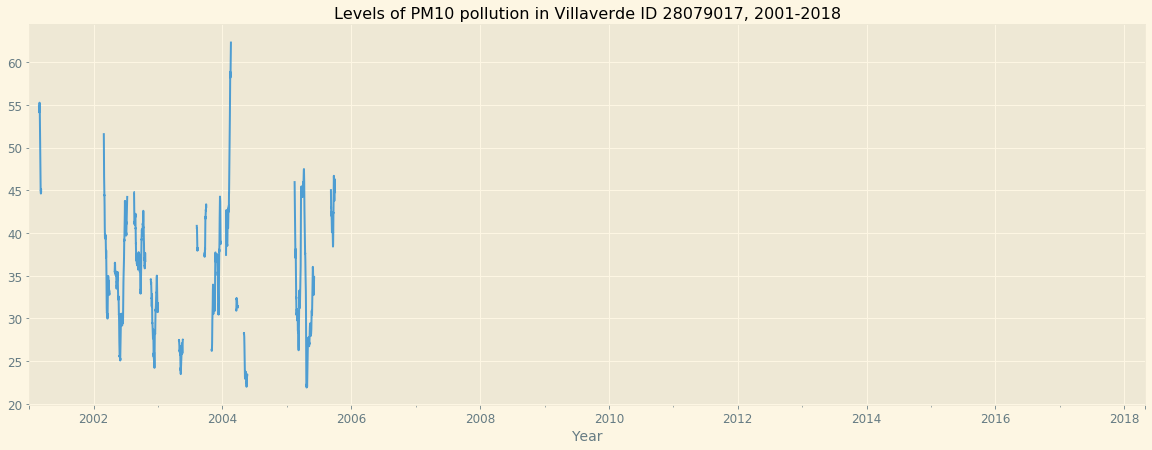

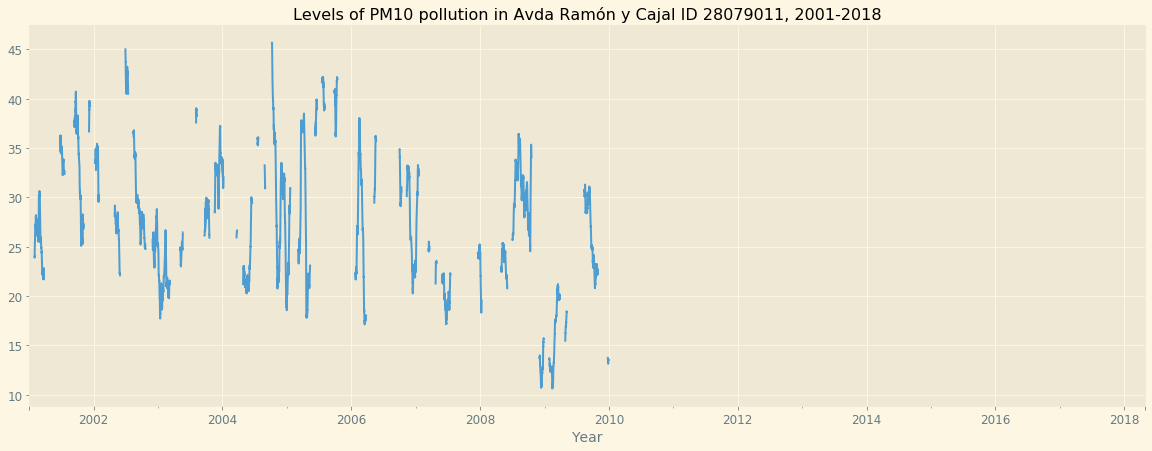

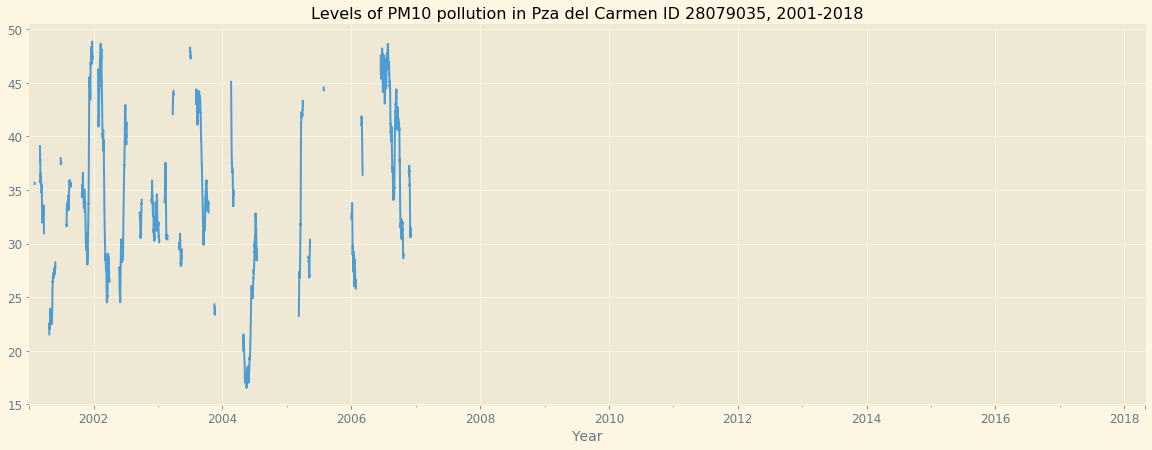

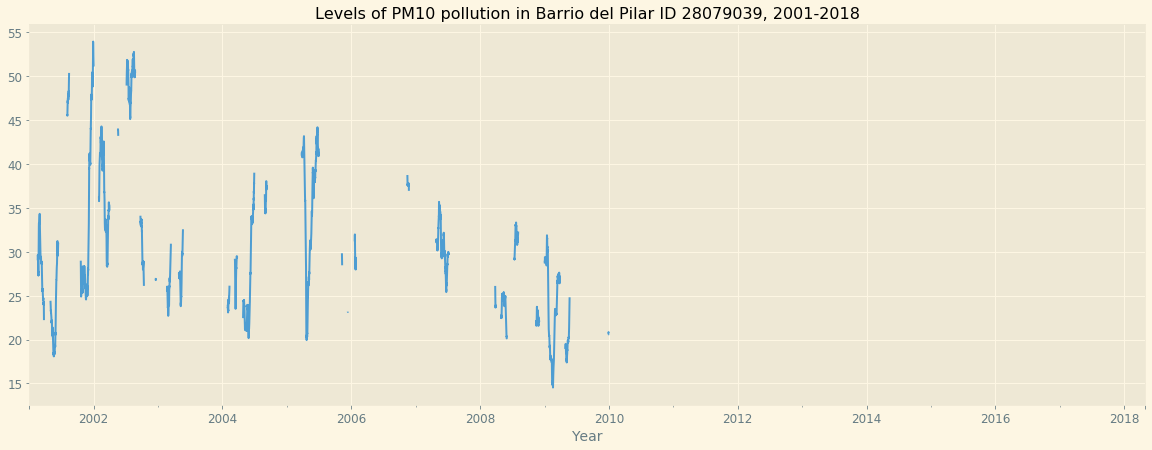

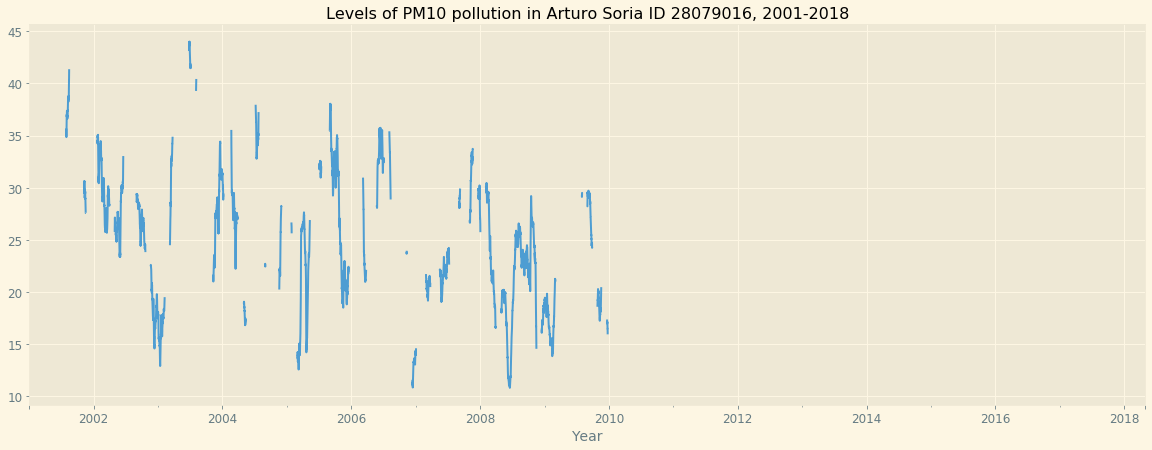

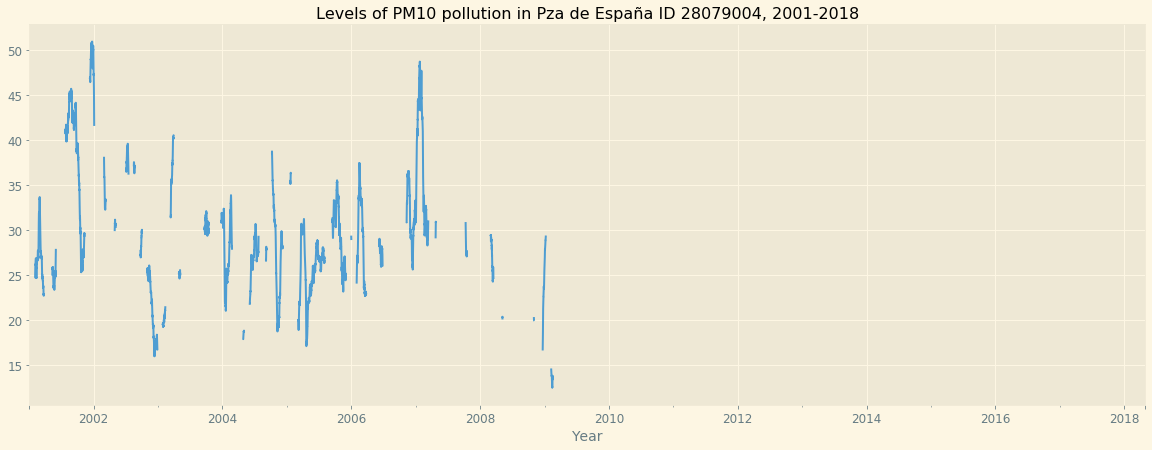

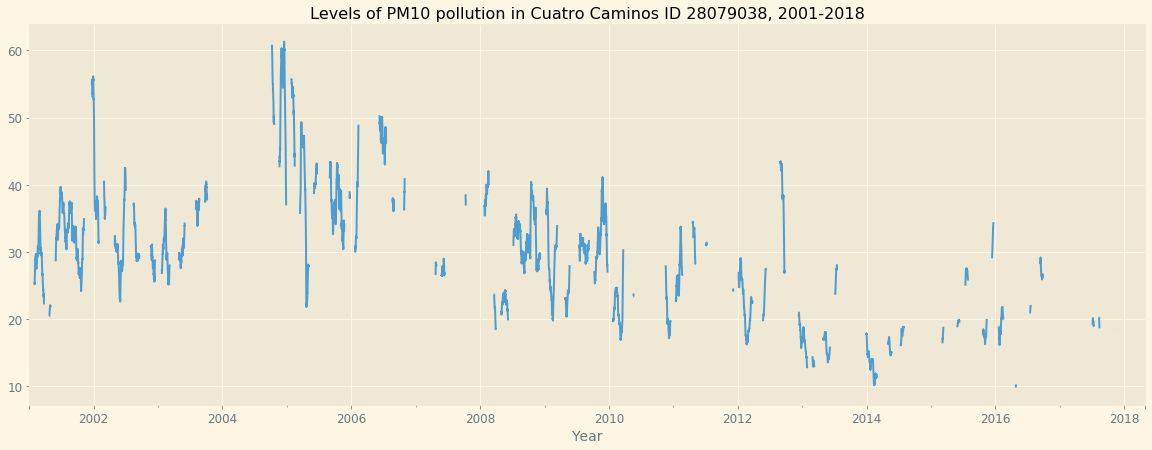

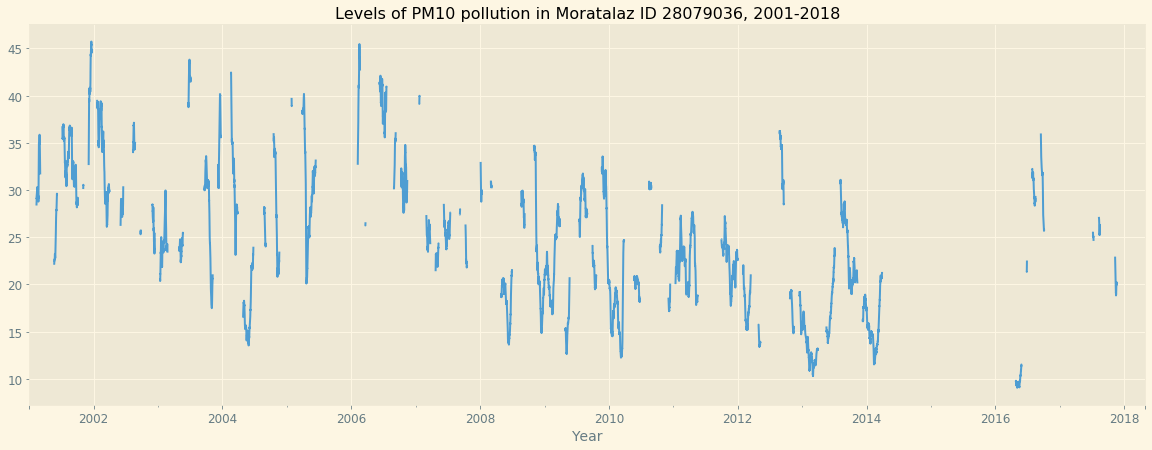

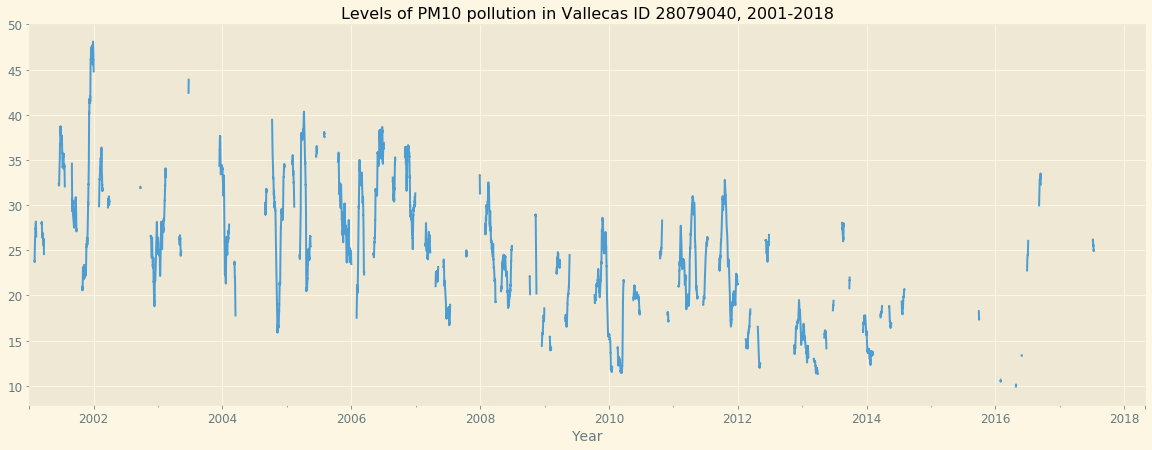

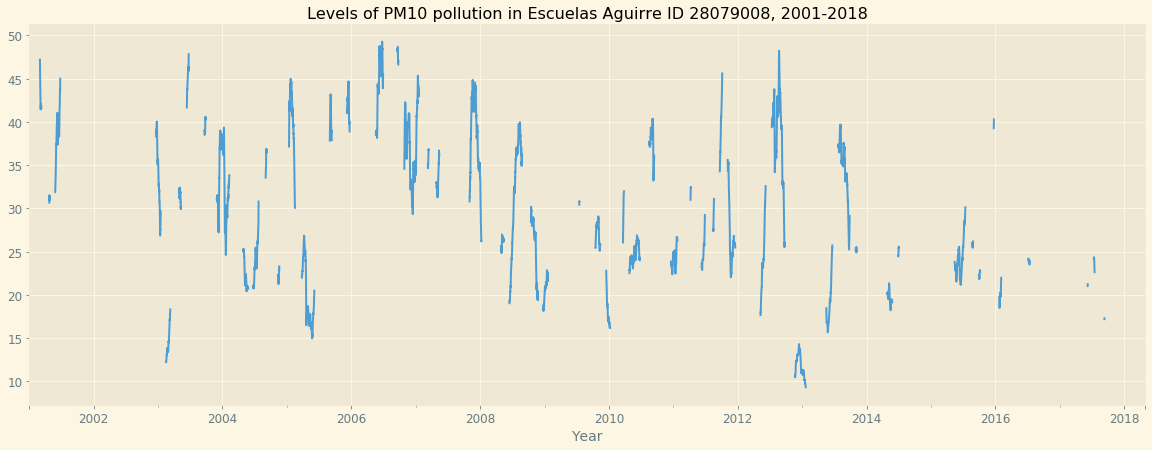

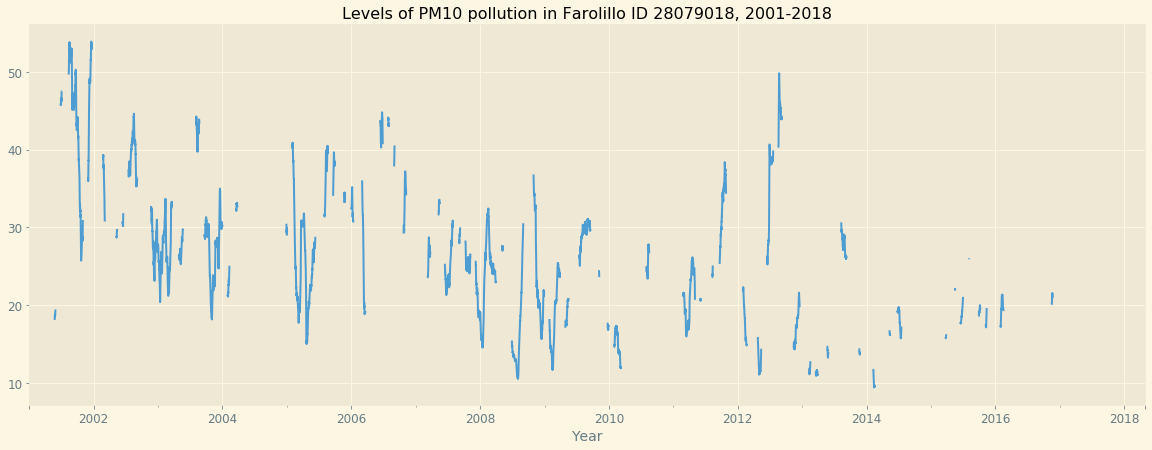

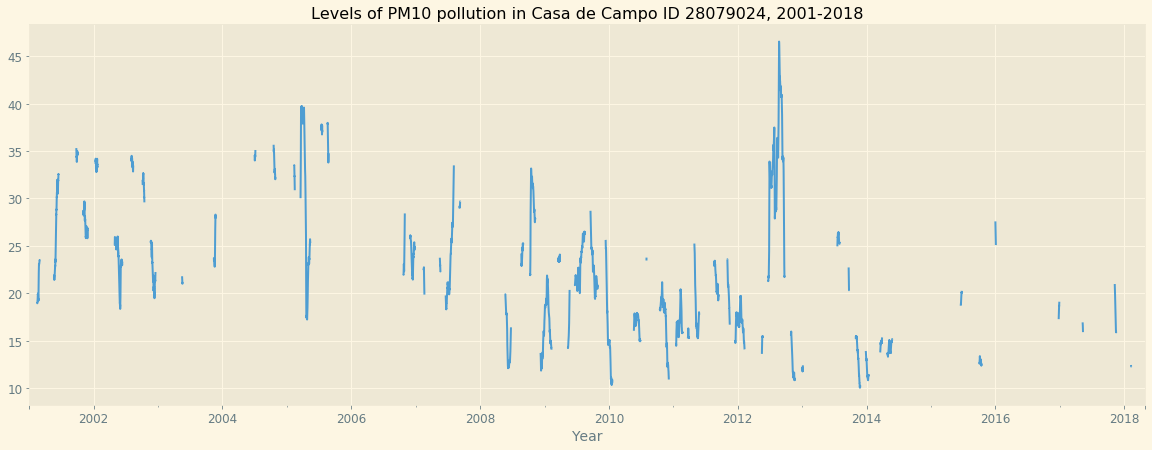

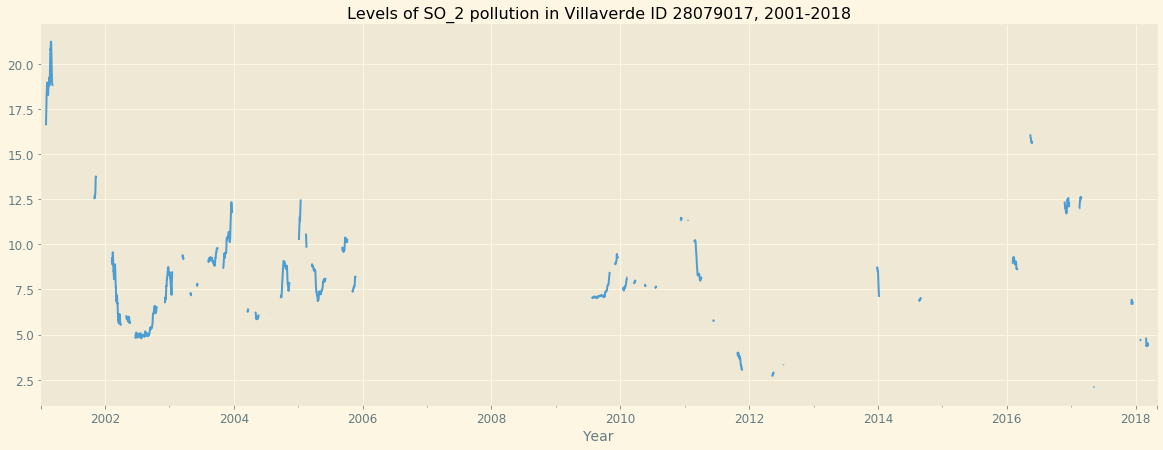

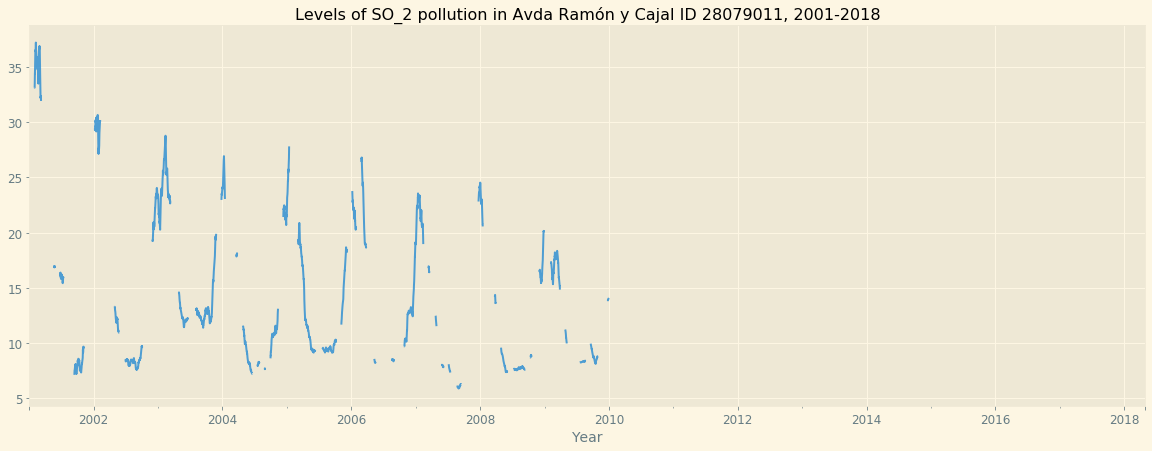

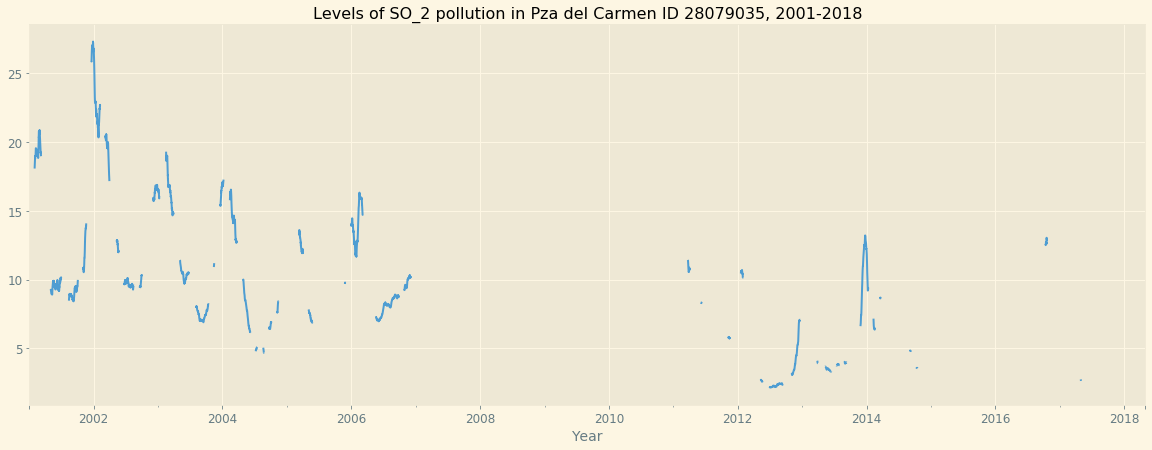

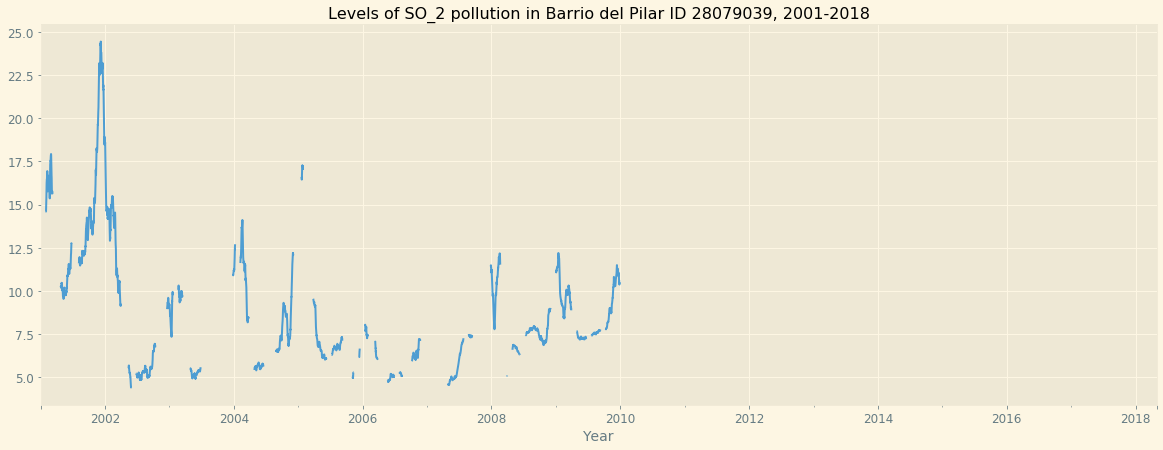

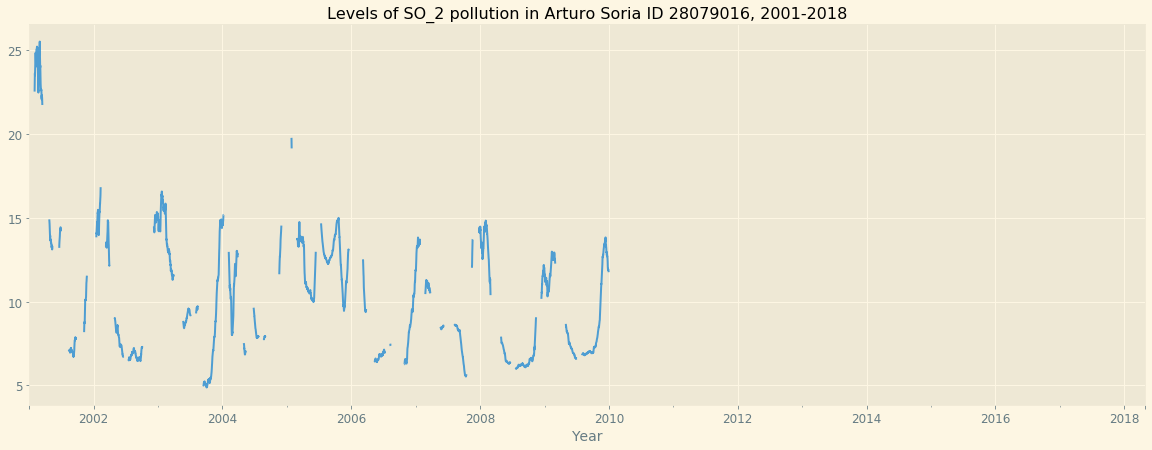

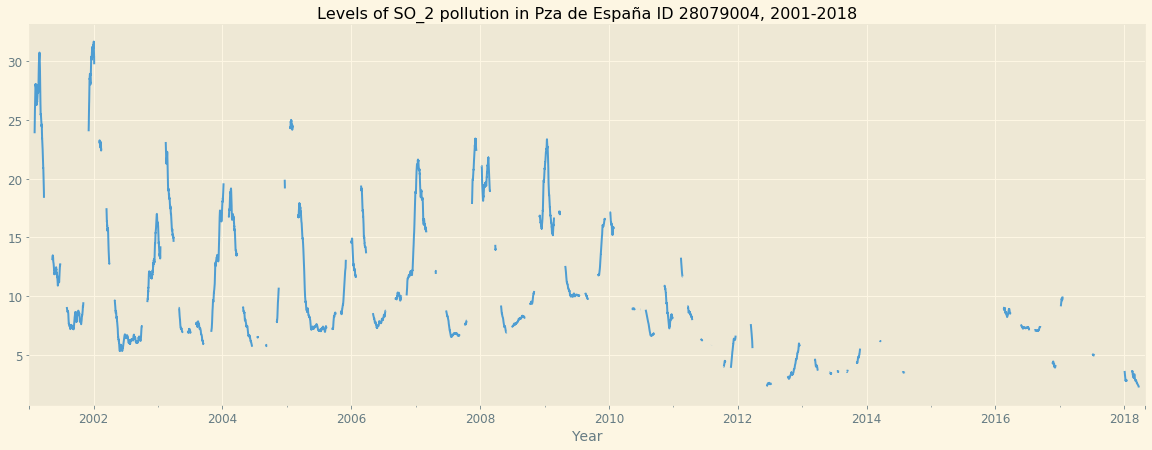

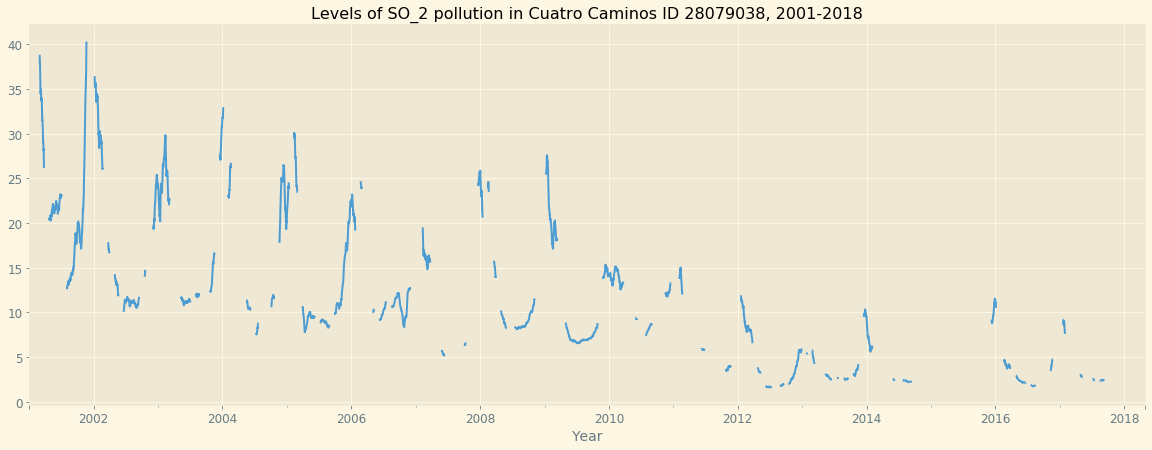

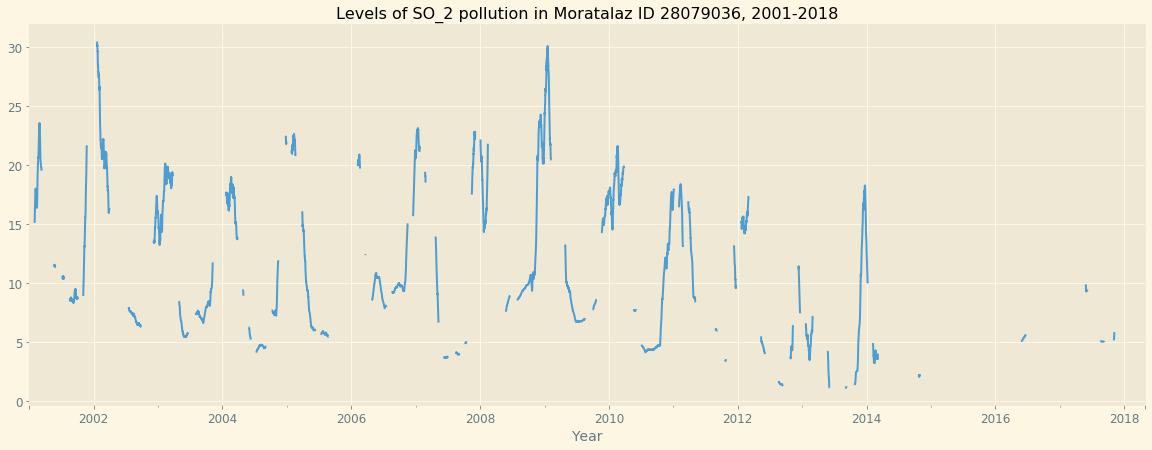

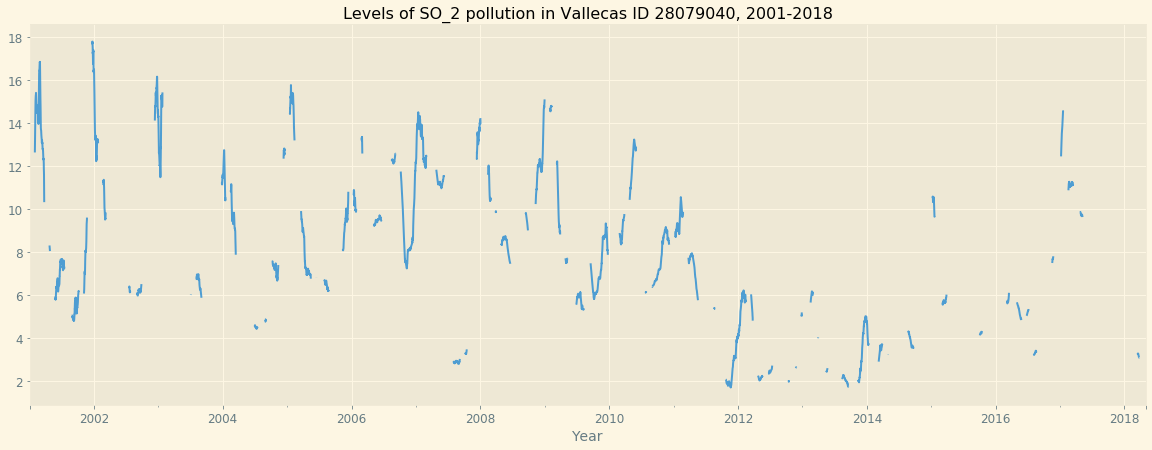

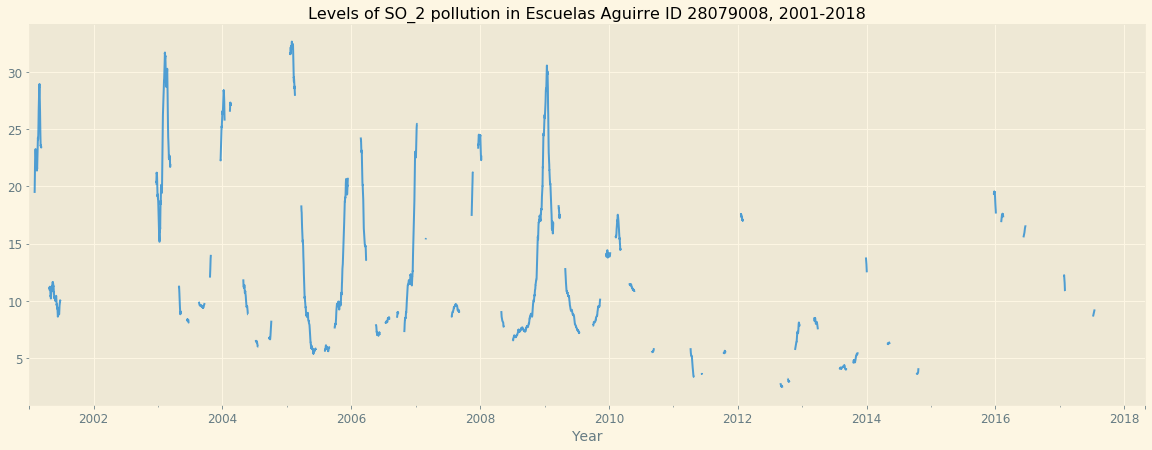

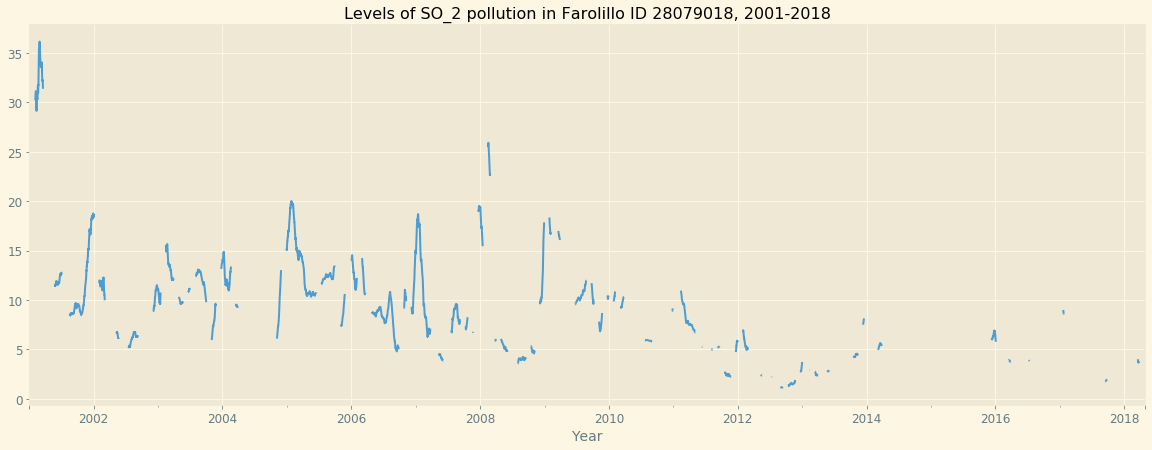

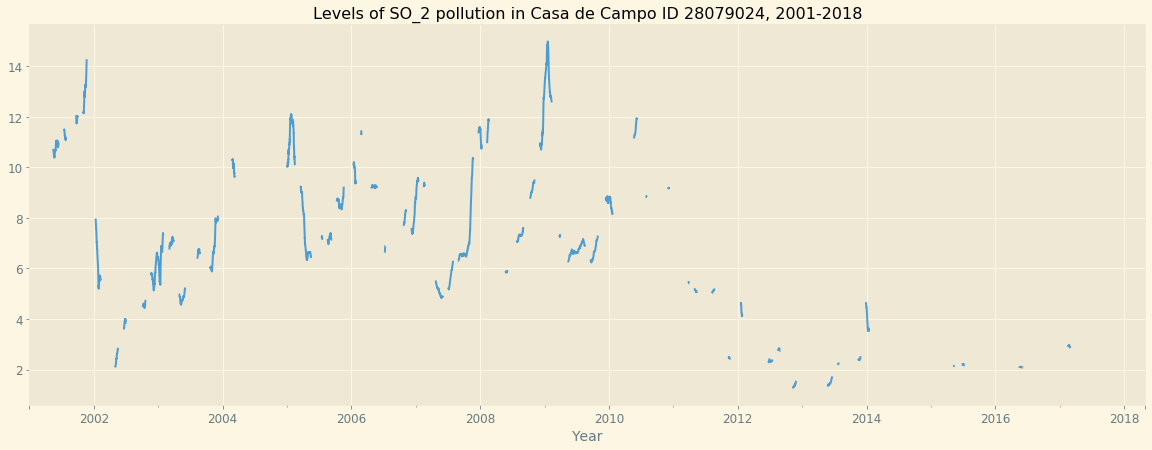

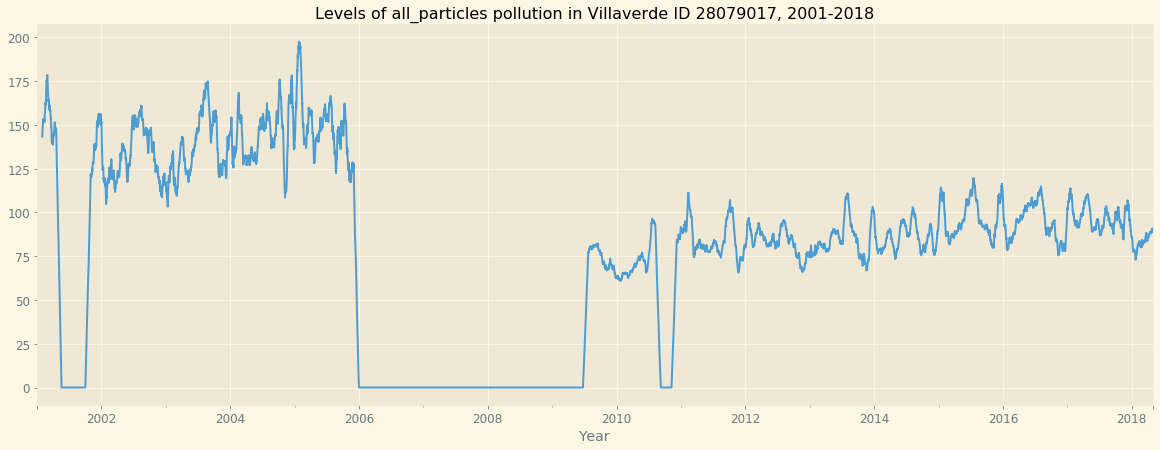

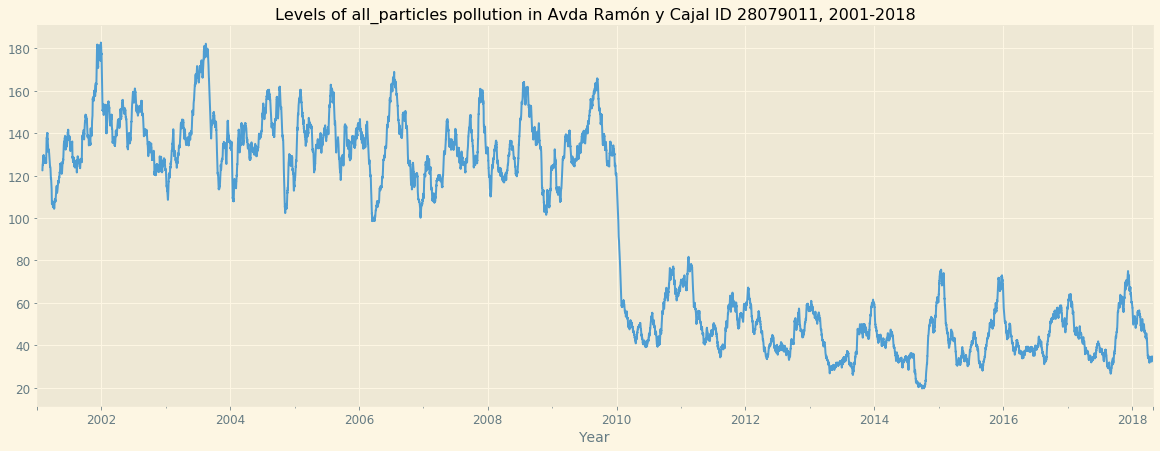

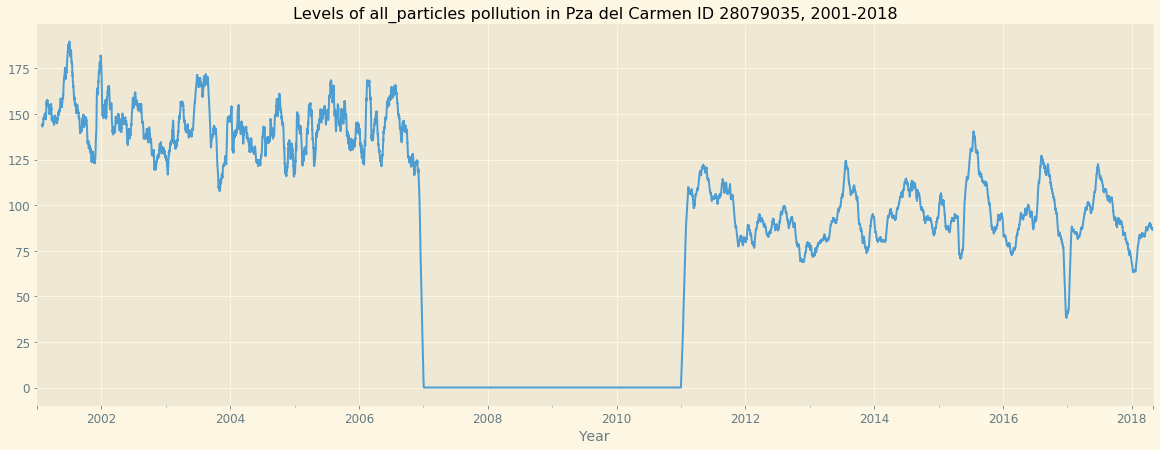

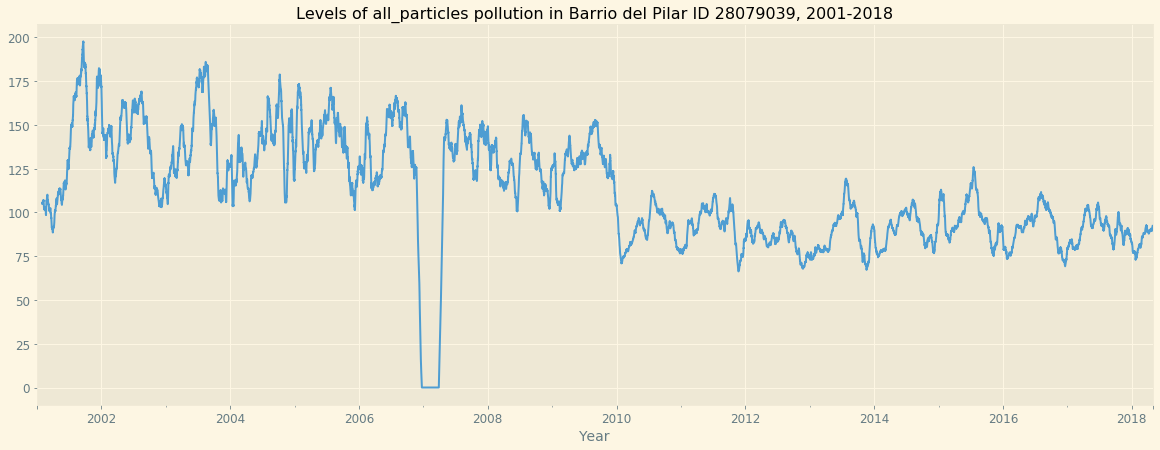

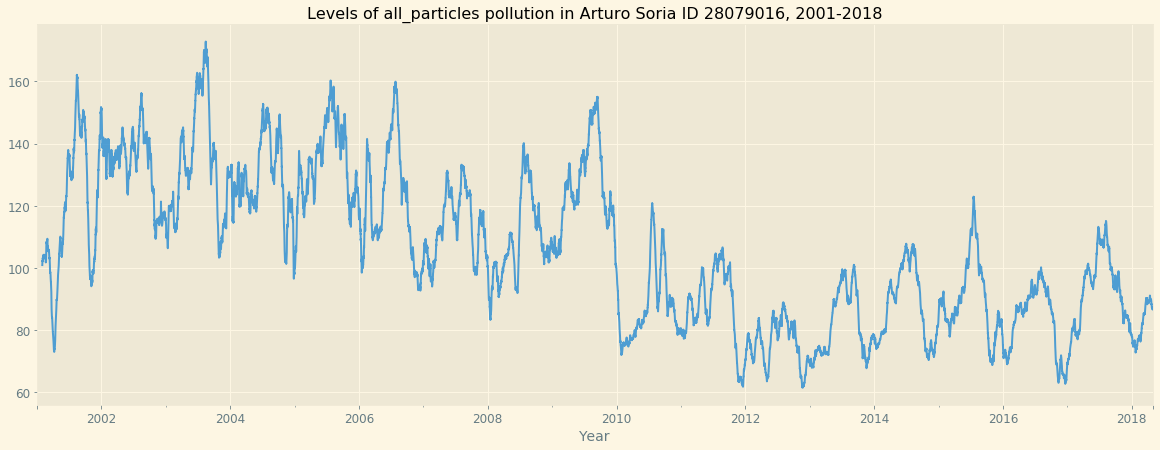

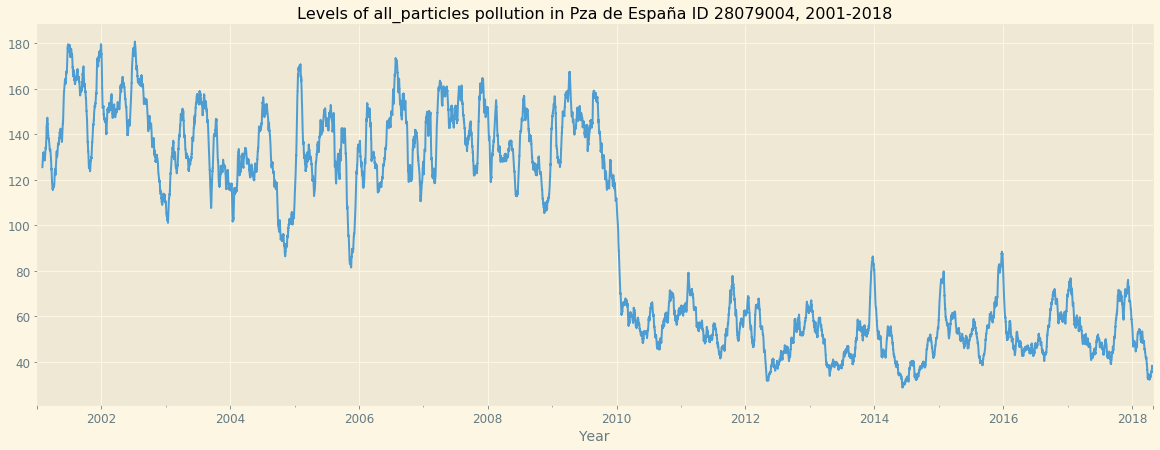

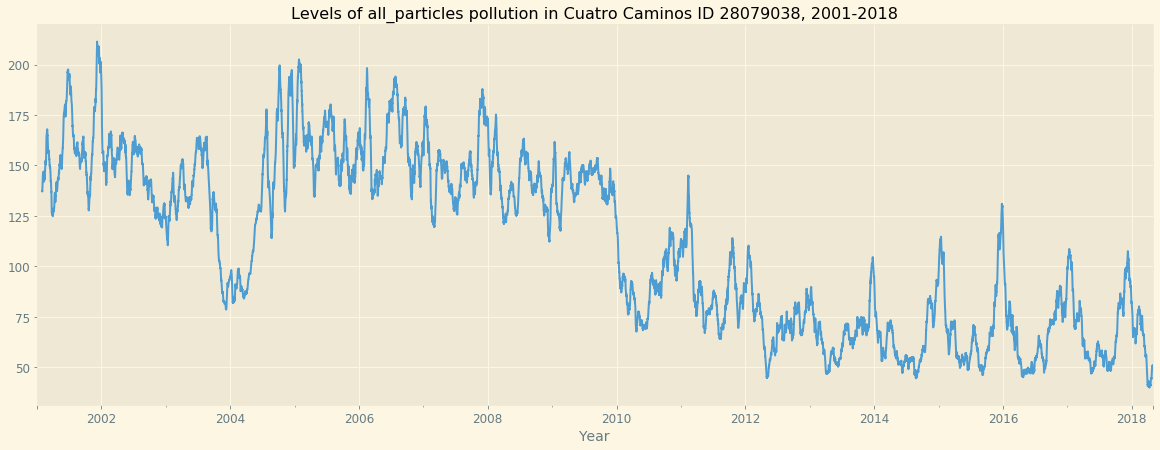

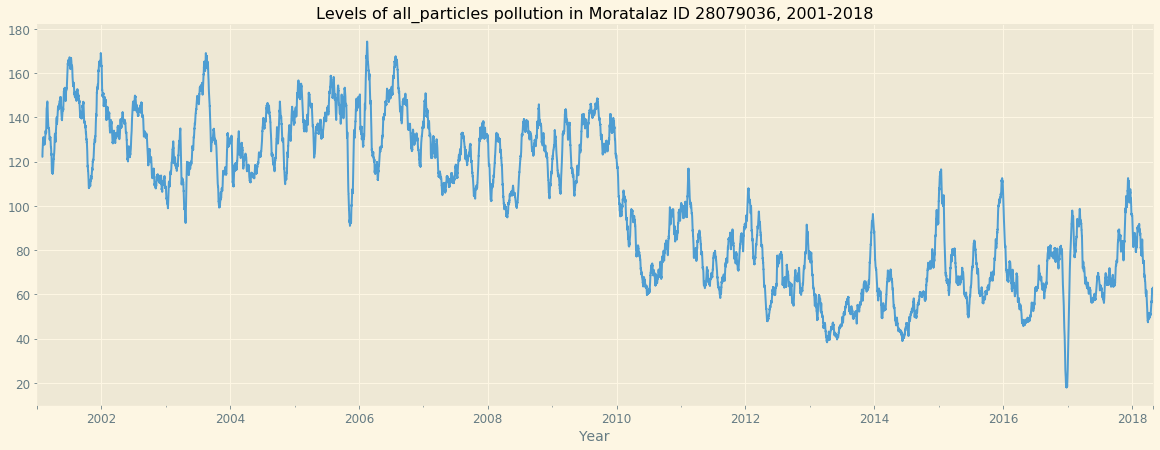

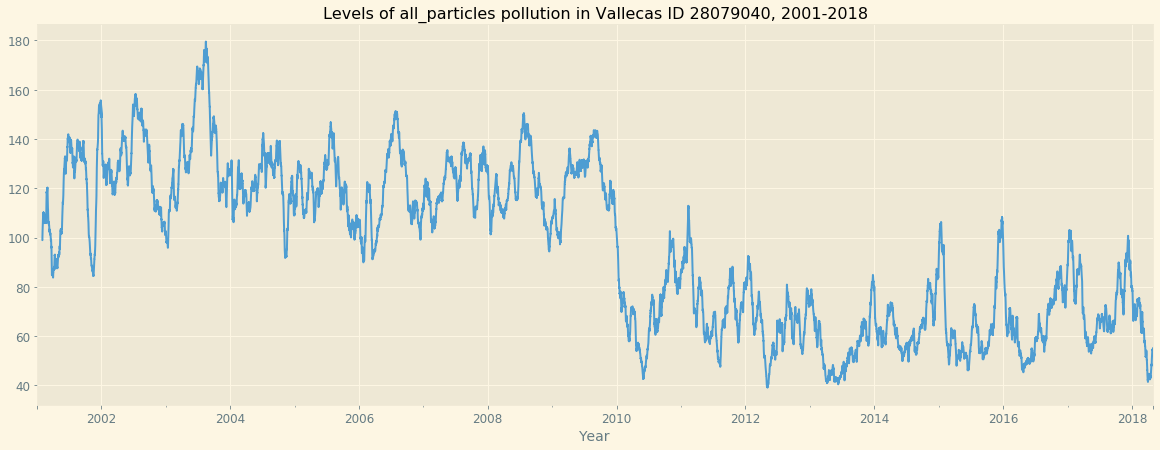

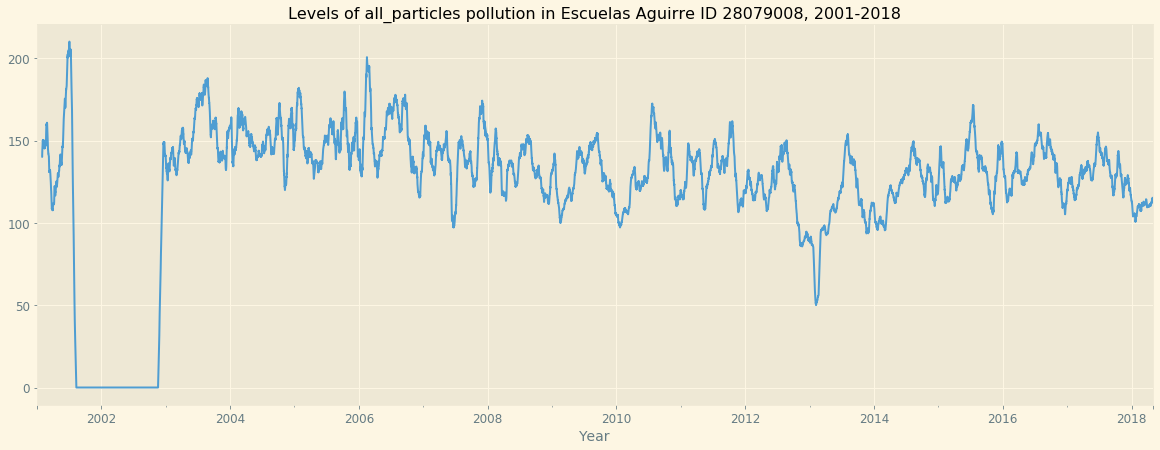

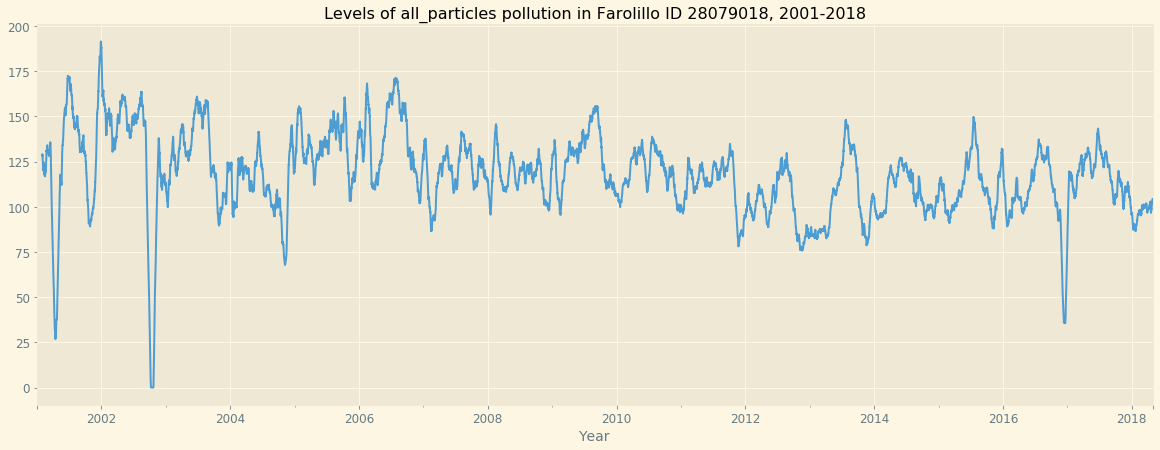

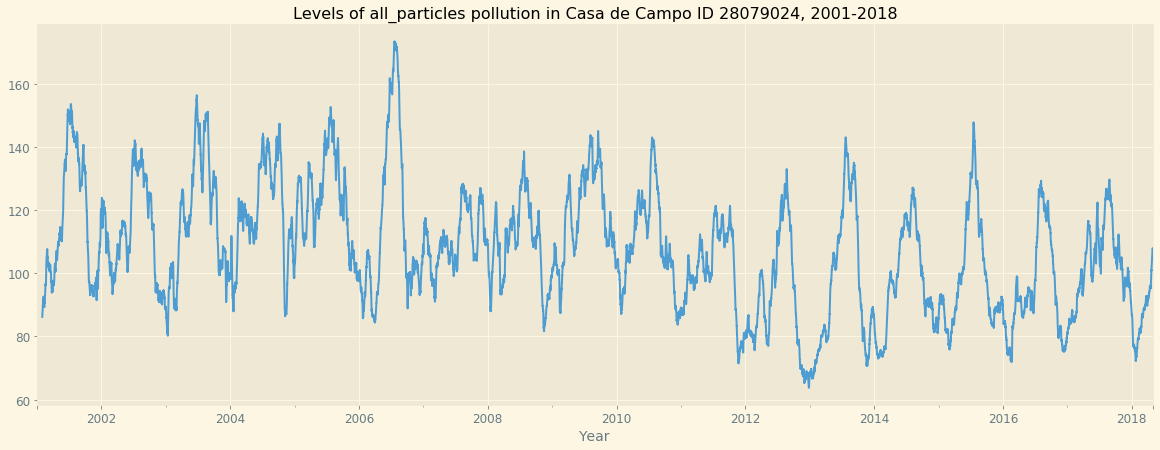

In [17]:
# Plot levels of polution for particles of interest in stations of interest in Madrid

for particle in particles_of_interest:
    
    for station in stations_of_interest:
        
        fig, ax = plt.subplots(figsize=(21, 7))
        
        one_station = df_select[df_select['station'] == station][particle]
        one_station.rolling(window=24*30).mean().plot(figsize=(20, 7), alpha=0.8)
        
        station_name = str(df_stations[df_stations['id'].astype(str) == station]['name_id'].values)
        station_name = re.sub(r'([^\s\w]|_)+', '', station_name)
        
        plt.xlabel('Year')
        plt.title(f'Levels of {particle} pollution in {station_name}, 2001-2018') 
        plt.show()

### Visualize seasonal patterns for particles of interest

In [18]:
# Group DF by hour, weekday, month and year

day_df = df_select.groupby(['station', 'hour']).mean().reset_index(level='station')
print(f'Day DF shape: {day_df.shape}')

week_df = df_select.groupby(['station', 'weekday']).mean().reset_index(level='station')
print(f'Week DF shape: {week_df.shape}')

year_df = df_select.groupby(['station', 'month']).mean().reset_index(level='station')
print(f'Year DF shape: {year_df.shape}')

multiyear_df = df_select.groupby(['station', 'year']).mean().reset_index(level='station')
print(f'Multi-year DF shape: {multiyear_df.shape}')

dayofyear_df = df_select.groupby(['station', 'dayofyear']).mean().reset_index(level='station')
print(f'Day-of-year DF shape: {dayofyear_df.shape}')
print('')

# Select 3 random stations to plot
sample_stations = ['28079008', '28079018', '28079024'] #random.sample(stations_of_interest, 3)
print(f'Stations to plot: {sample_stations}')

Day DF shape: (936, 10)
Week DF shape: (273, 10)
Year DF shape: (468, 10)
Multi-year DF shape: (702, 10)
Day-of-year DF shape: (14274, 10)

Stations to plot: ['28079008', '28079018', '28079024']


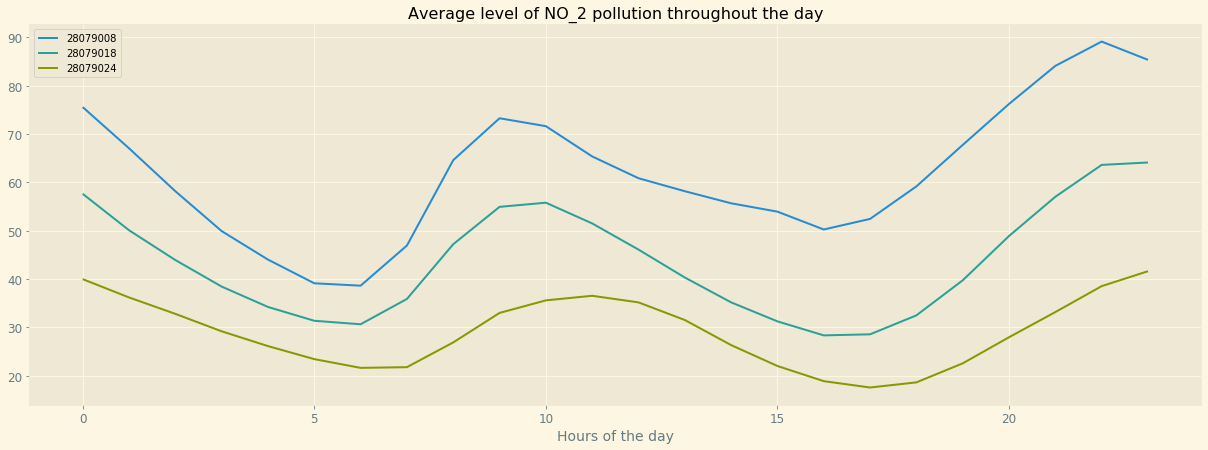

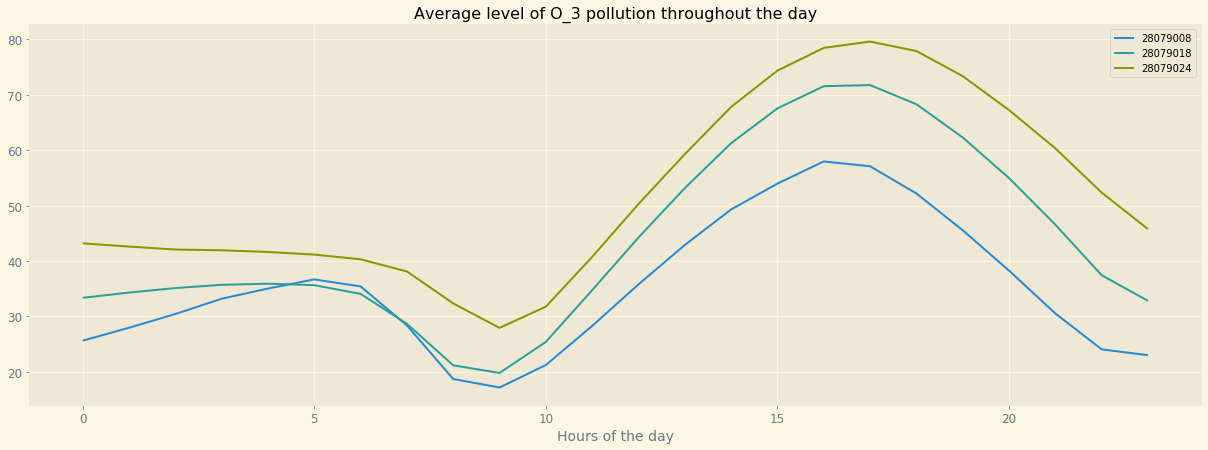

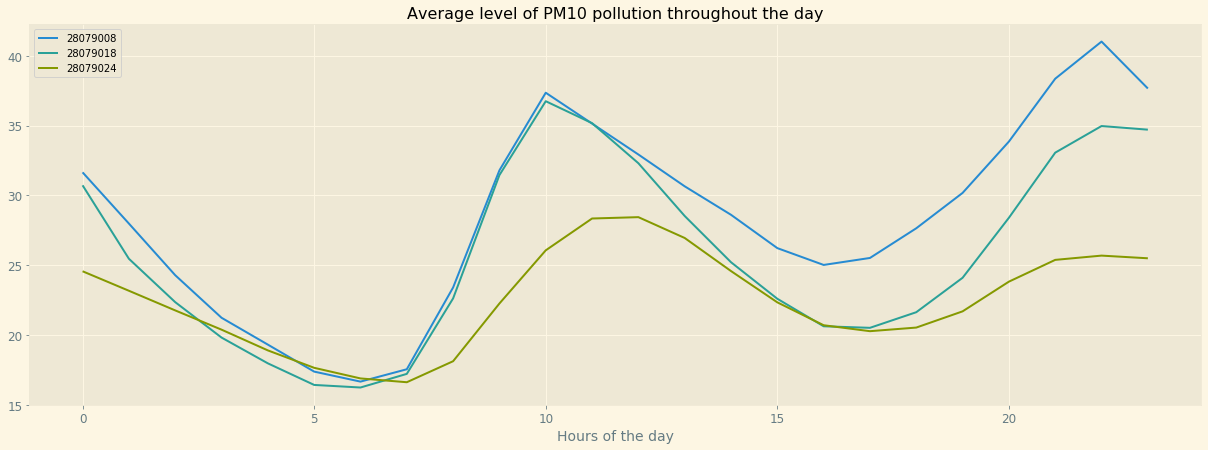

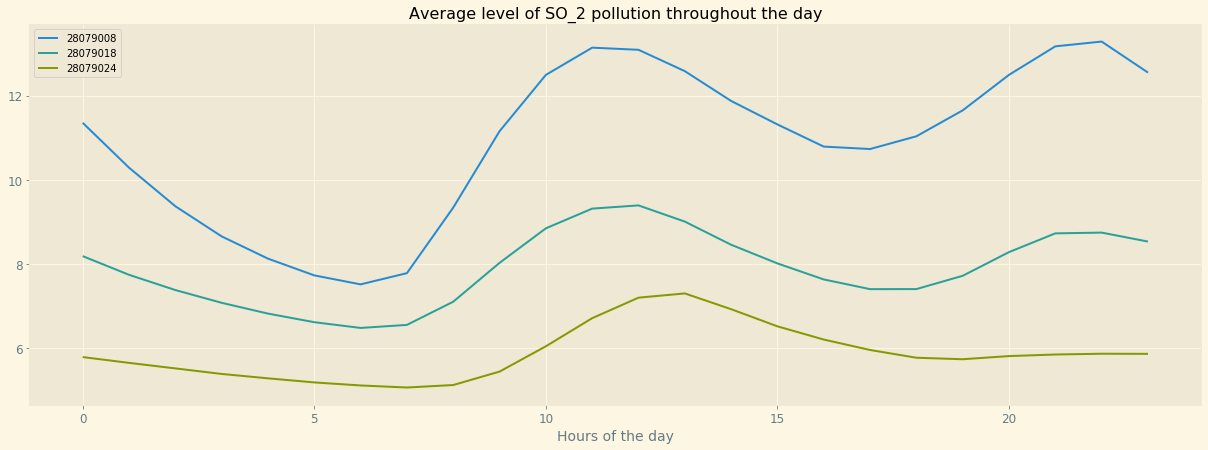

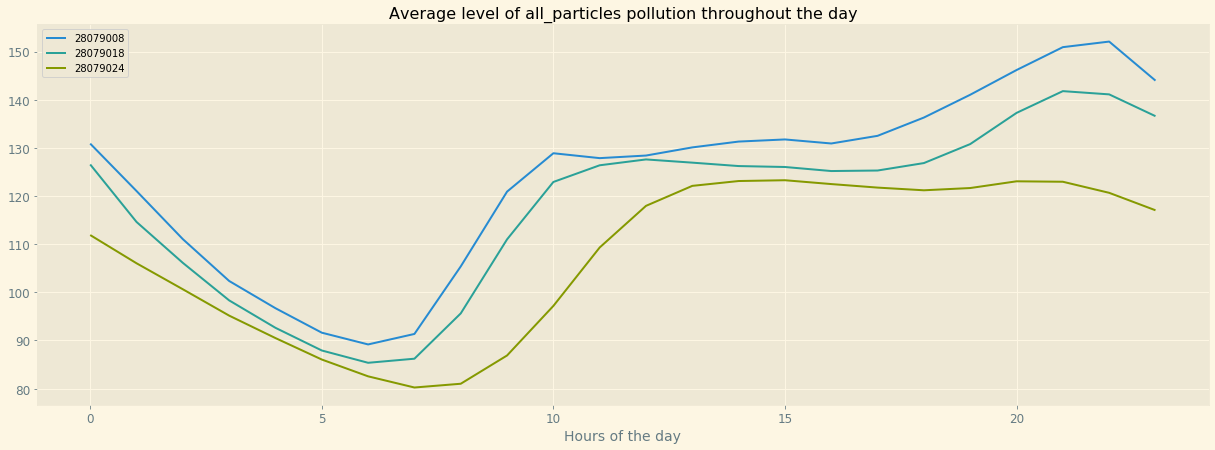

In [19]:
# Plot levels of polution throughout the day for each particle of interest in 3 random stations of interest

for particle in particles_of_interest:
    fig, ax = plt.subplots(figsize=(21, 7))
    for station in sample_stations: 
        ax.plot(day_df.loc[day_df['station'] == station, particle], label=station)
        plt.title(f'Average level of {particle} pollution throughout the day') 
        plt.xlabel('Hours of the day')
        plt.legend(sample_stations)

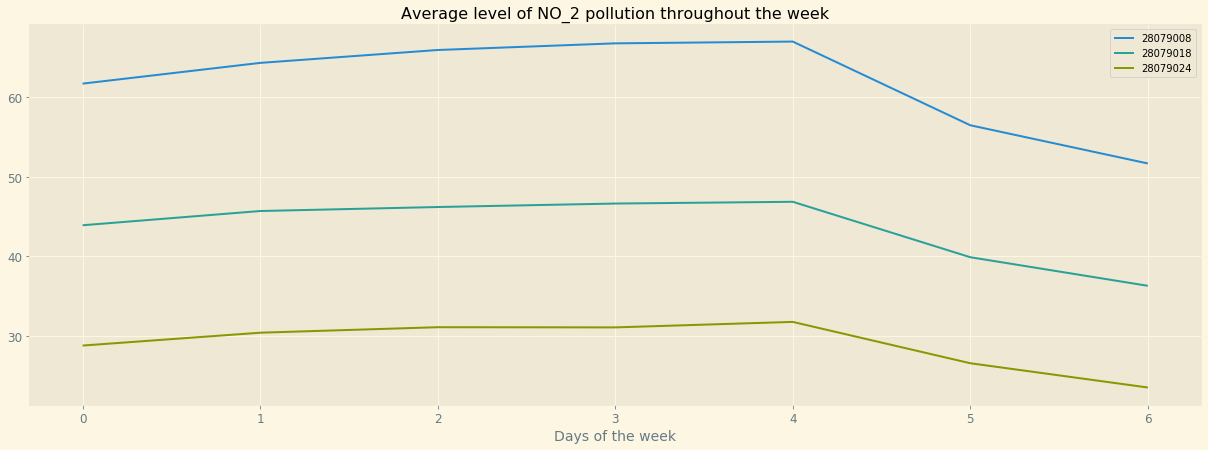

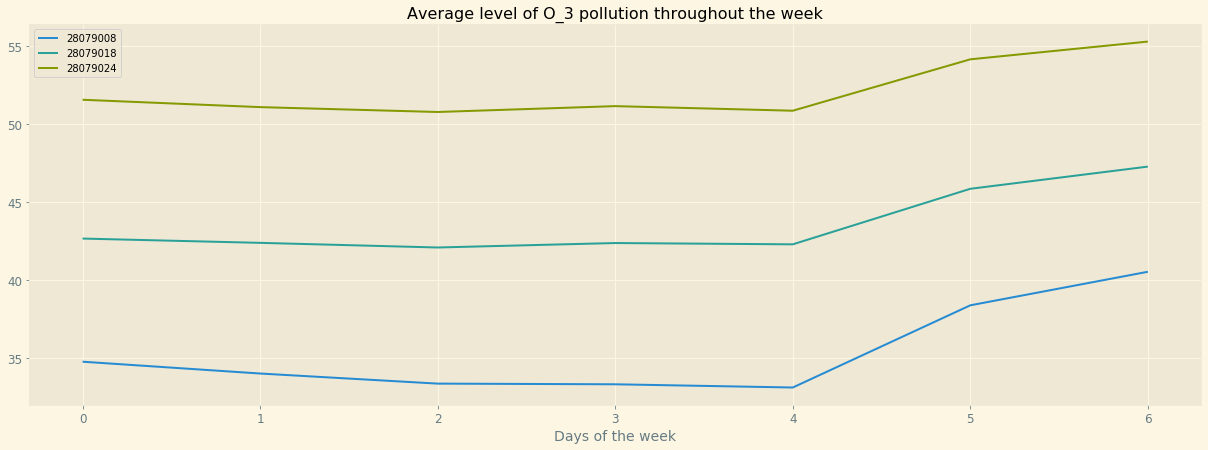

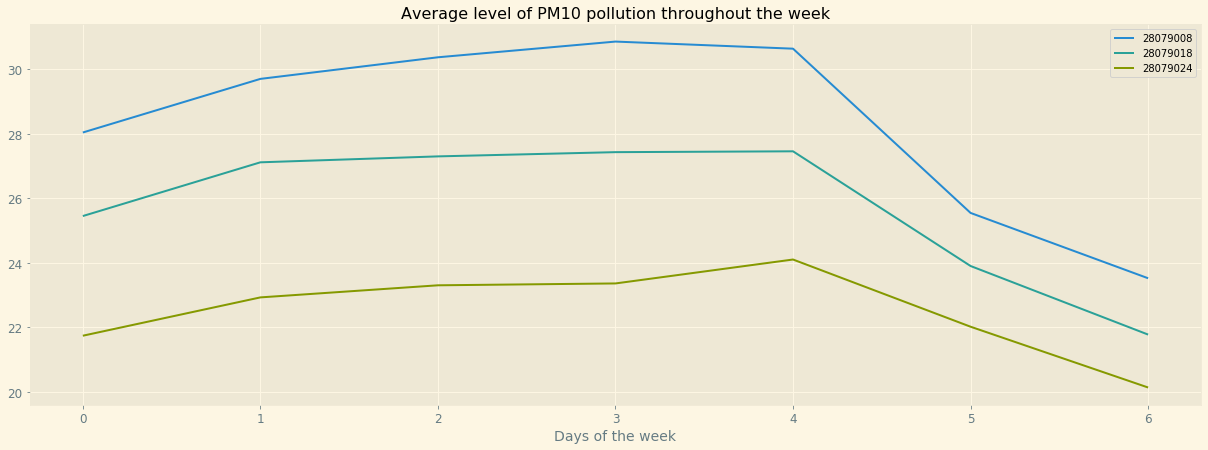

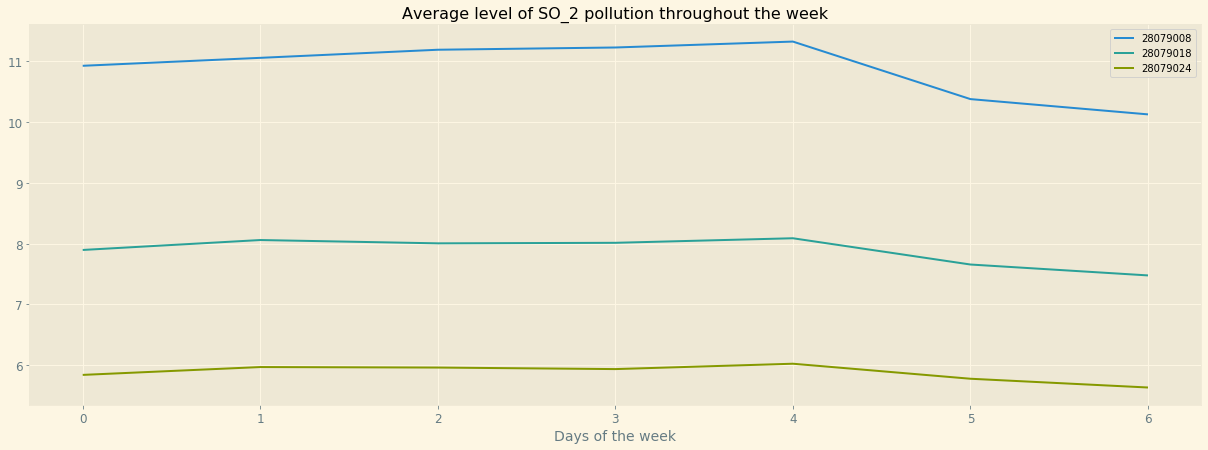

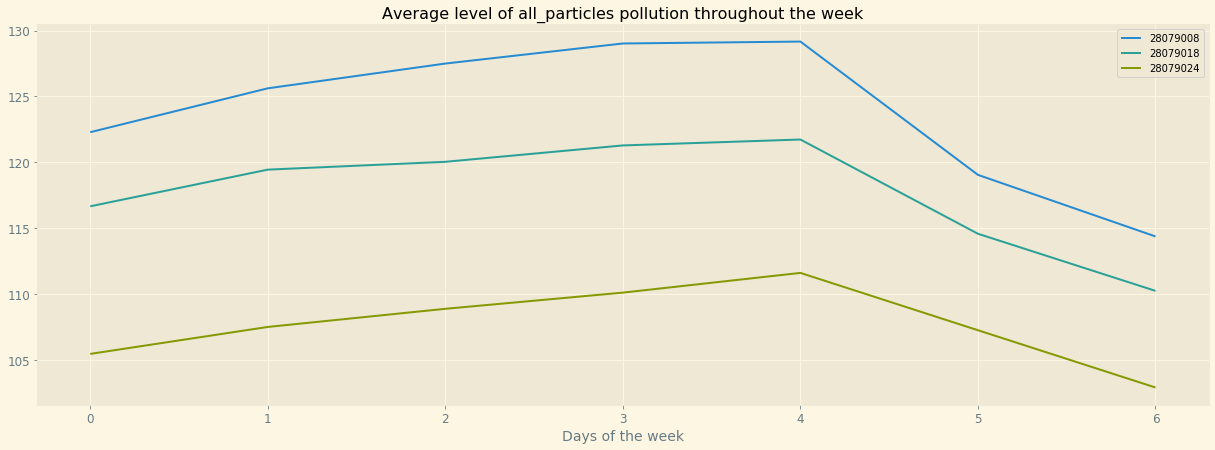

In [20]:
# Plot levels of polution throughout the week for each particle of interest in 3 random stations of interest

for particle in particles_of_interest:
    fig, ax = plt.subplots(figsize=(21, 7))
    for station in sample_stations: 
        ax.plot(week_df.loc[week_df['station'] == station, particle], label=station)
        plt.title(f'Average level of {particle} pollution throughout the week') 
        plt.xlabel('Days of the week')
        plt.legend(sample_stations)

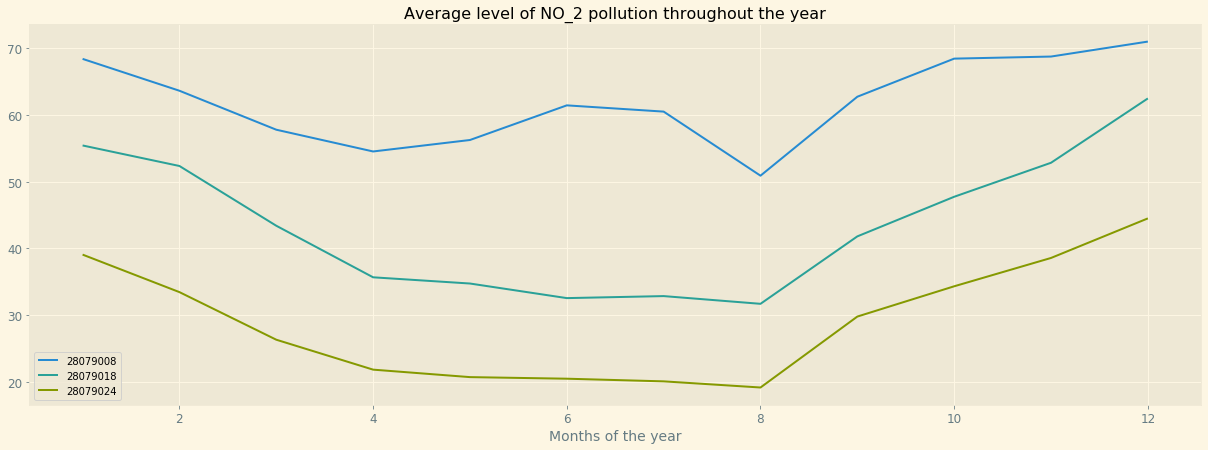

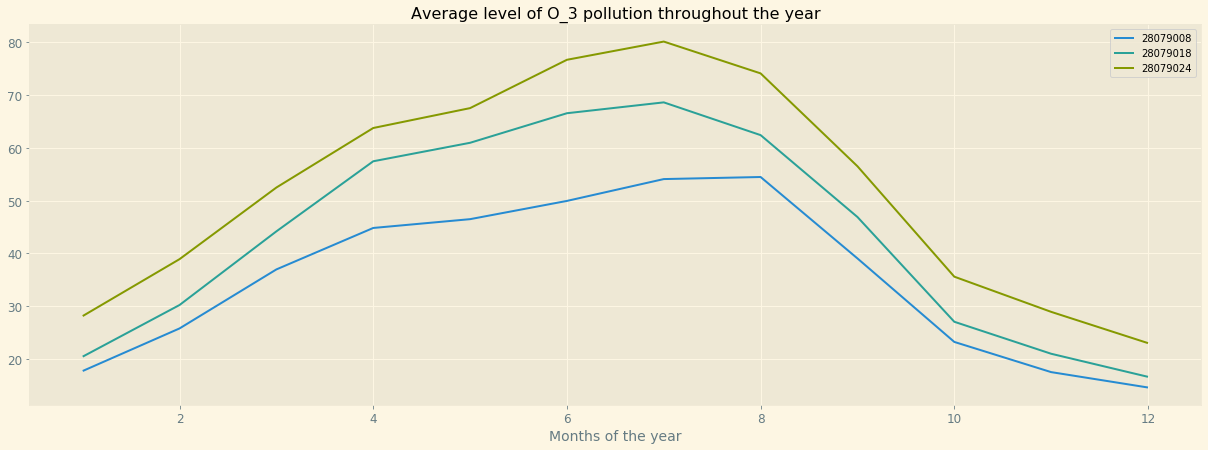

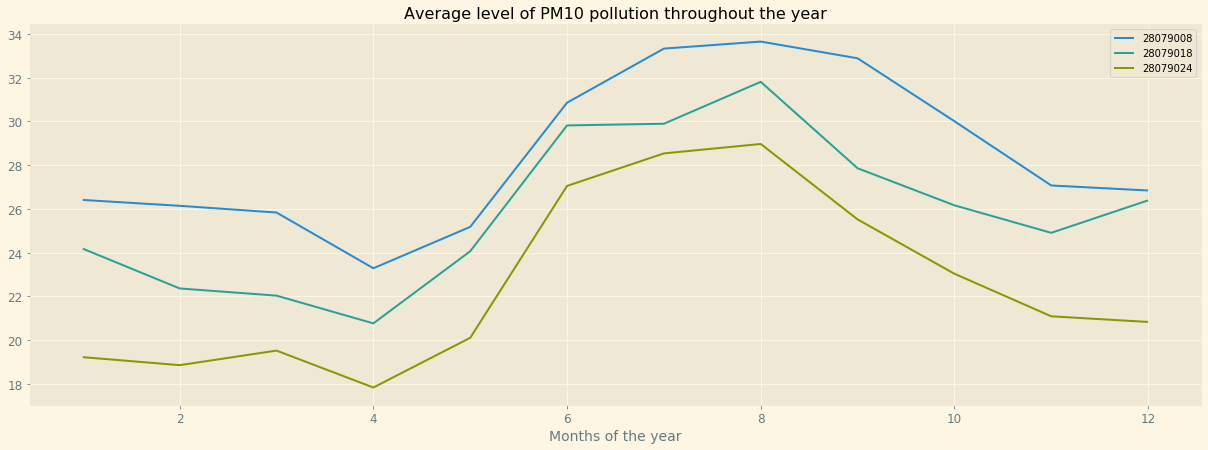

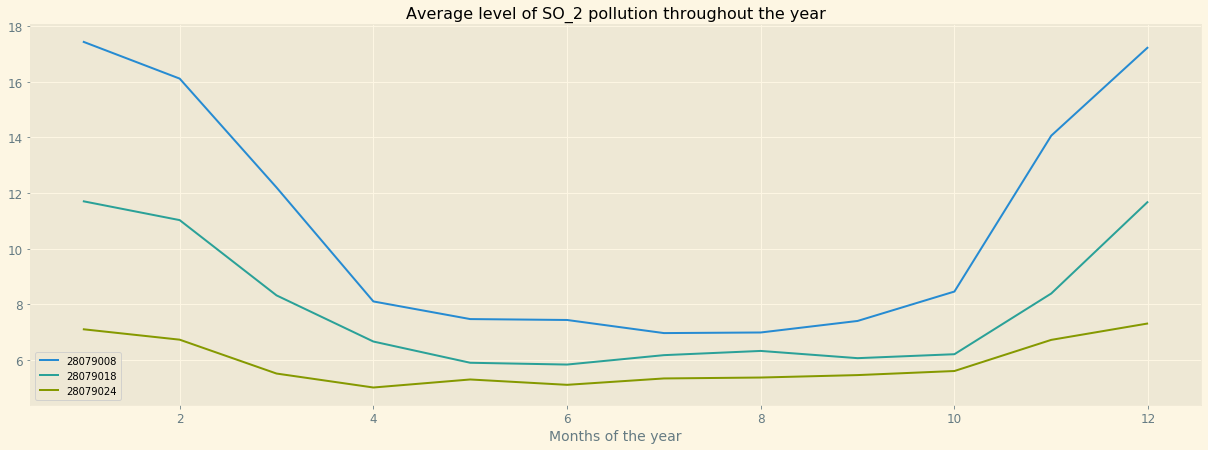

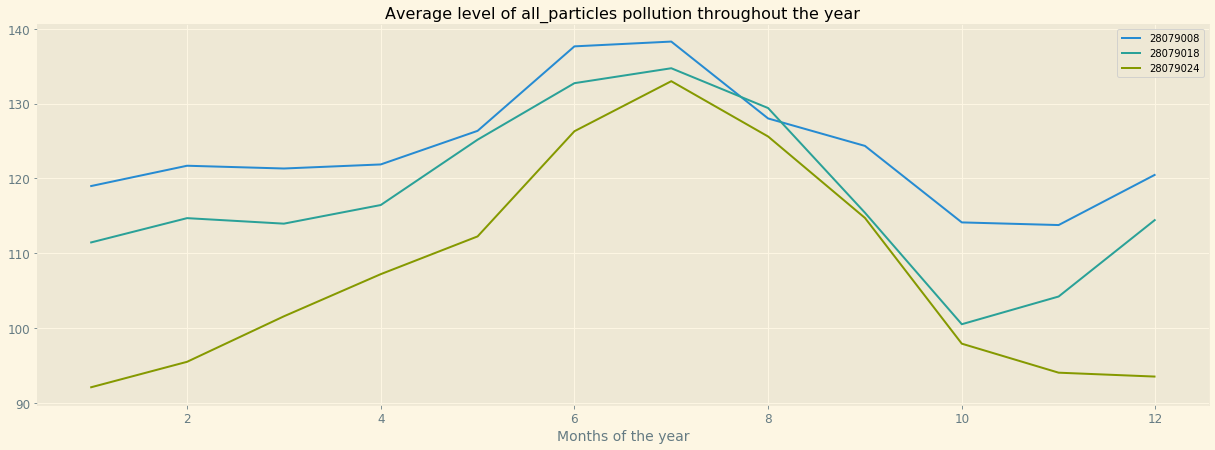

In [21]:
# Plot levels of polution throughout the year for each particle of interest in 3 random stations of interest

for particle in particles_of_interest:
    fig, ax = plt.subplots(figsize=(21, 7))
    for station in sample_stations: 
        ax.plot(year_df.loc[year_df['station'] == station, particle], label=station)
        plt.title(f'Average level of {particle} pollution throughout the year') 
        plt.xlabel('Months of the year')
        plt.legend(sample_stations)

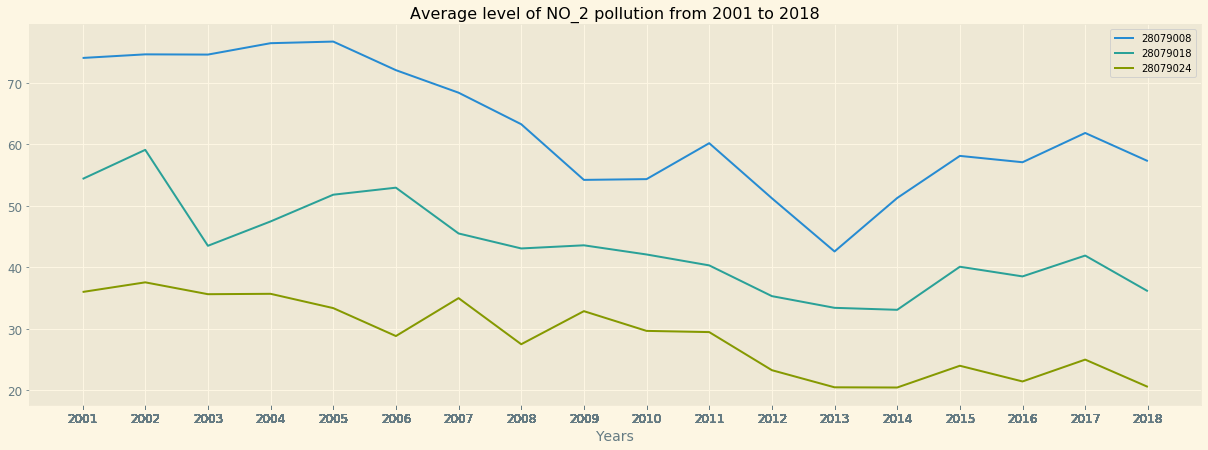

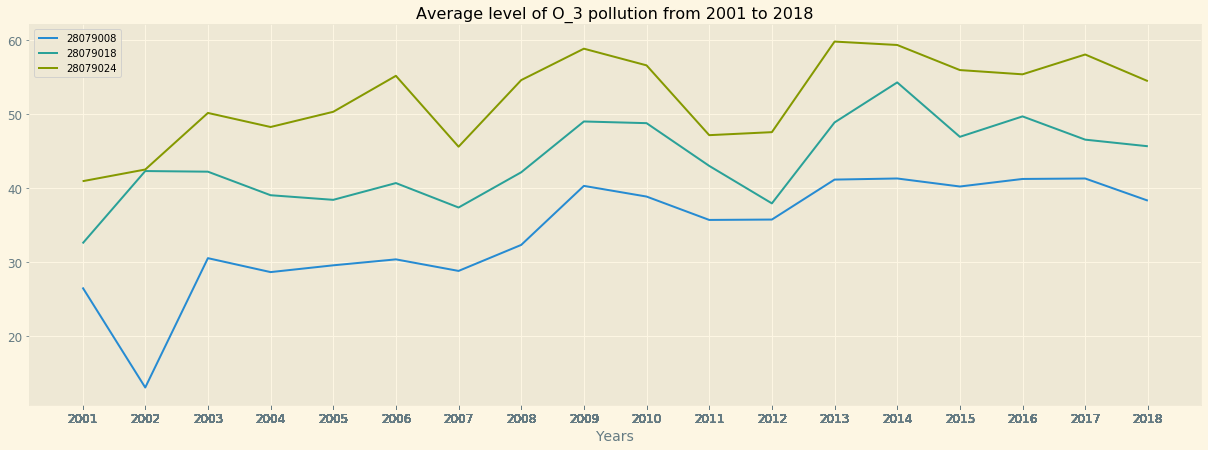

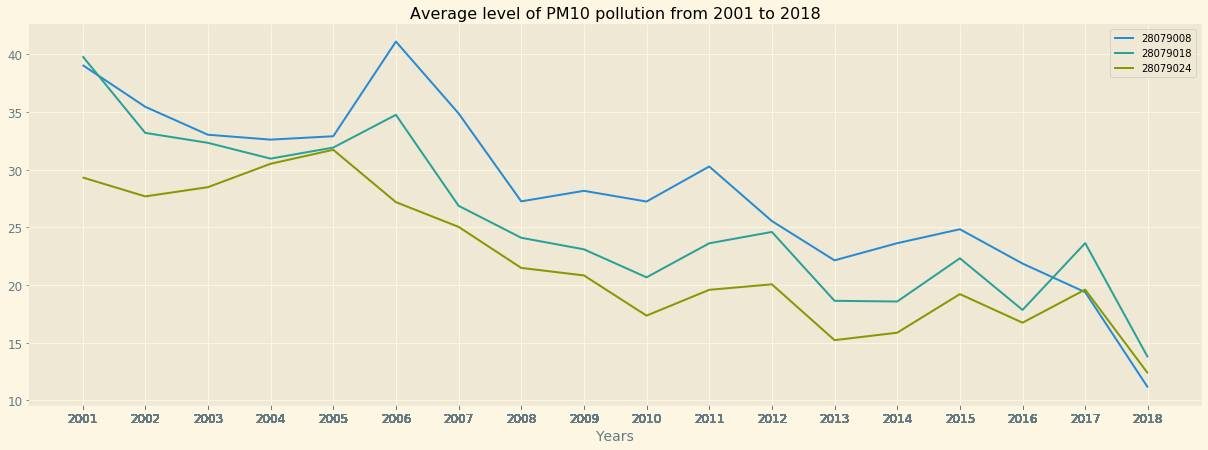

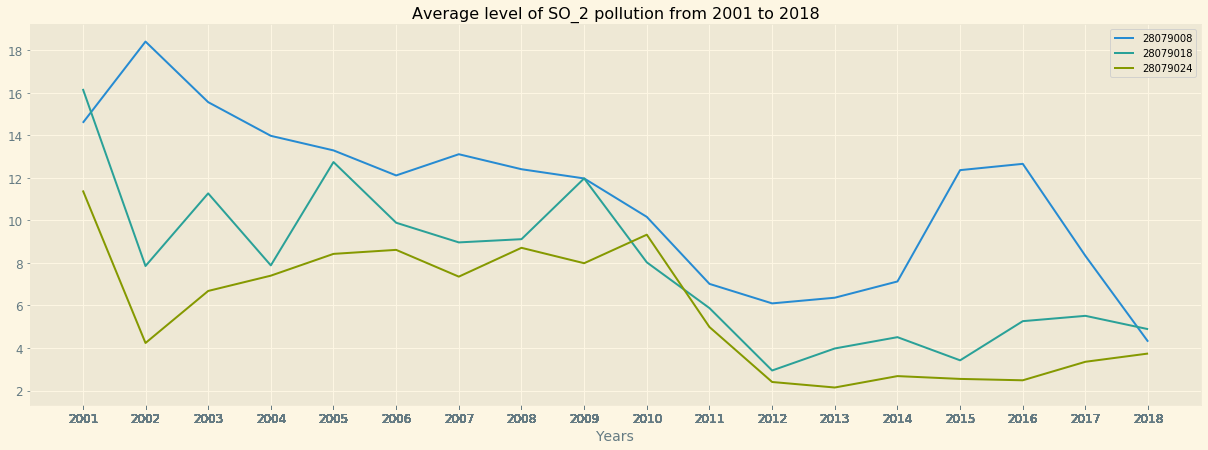

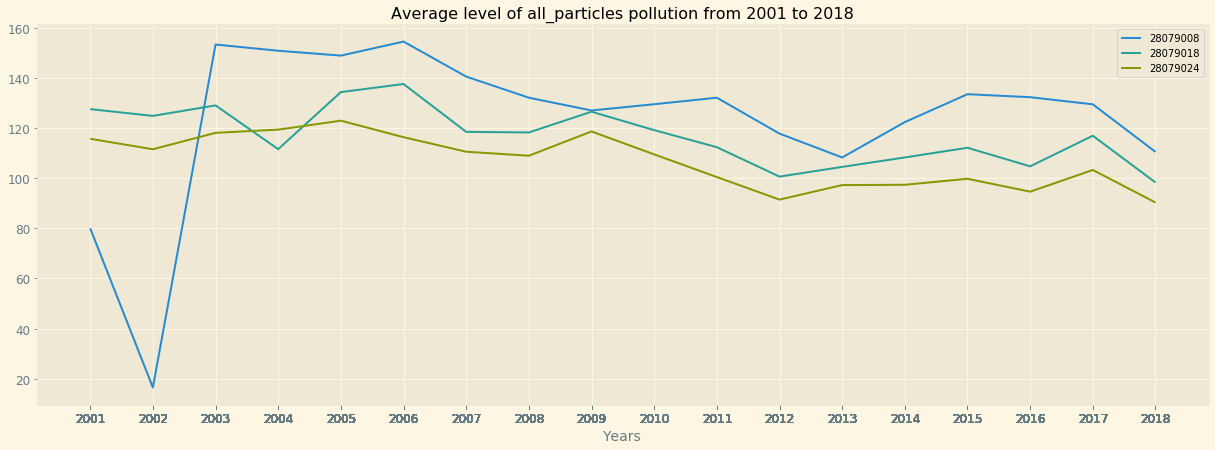

In [22]:
# Plot levels of polution throughout the years for each particle of interest in 3 random stations of interest

for particle in particles_of_interest:
    fig, ax = plt.subplots(figsize=(21, 7))
    for station in sample_stations: 
        ax.plot(multiyear_df.loc[multiyear_df['station'] == station, particle], label=station)
        plt.title(f'Average level of {particle} pollution from 2001 to 2018') 
        plt.xlabel('Years')
        plt.xticks(multiyear_df.index)
        plt.legend(sample_stations)

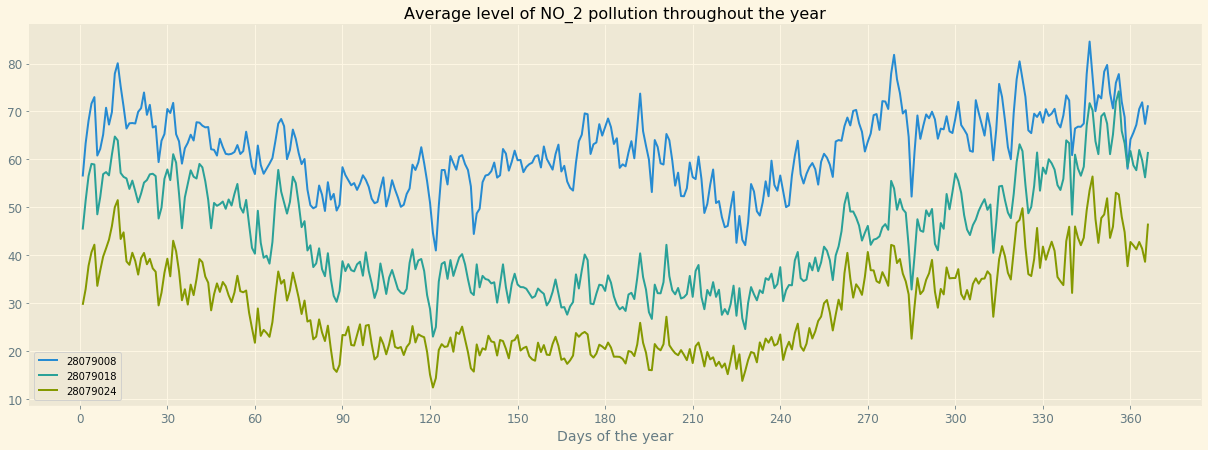

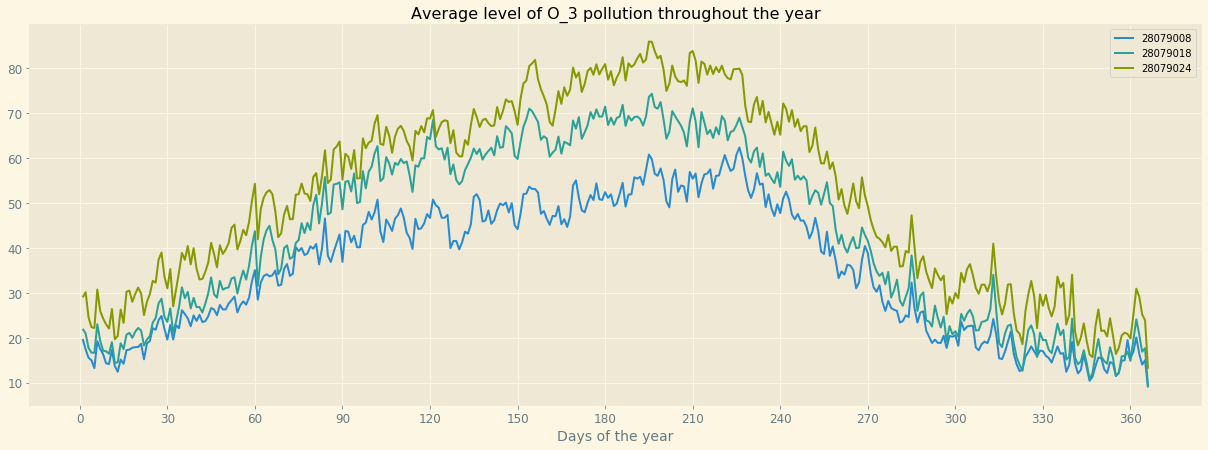

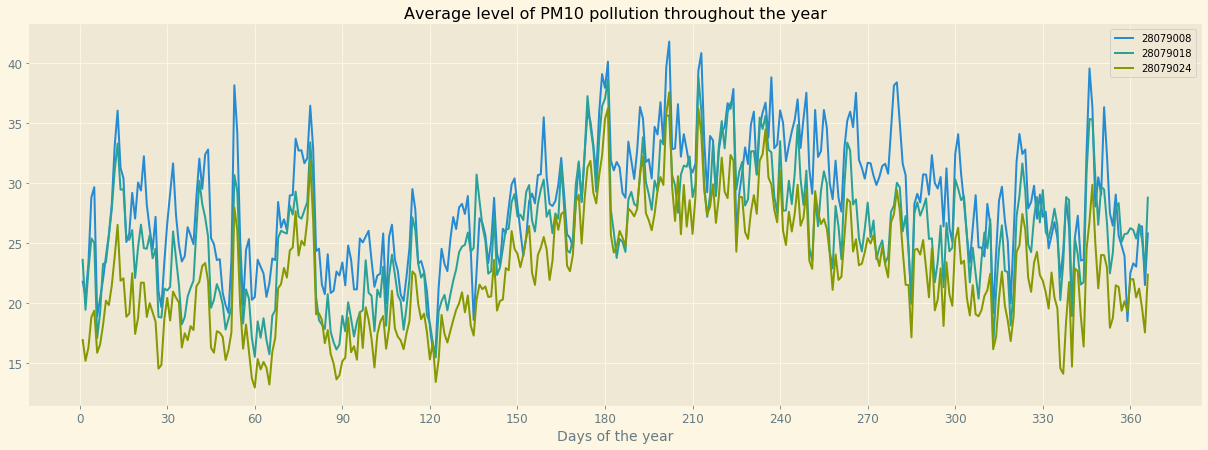

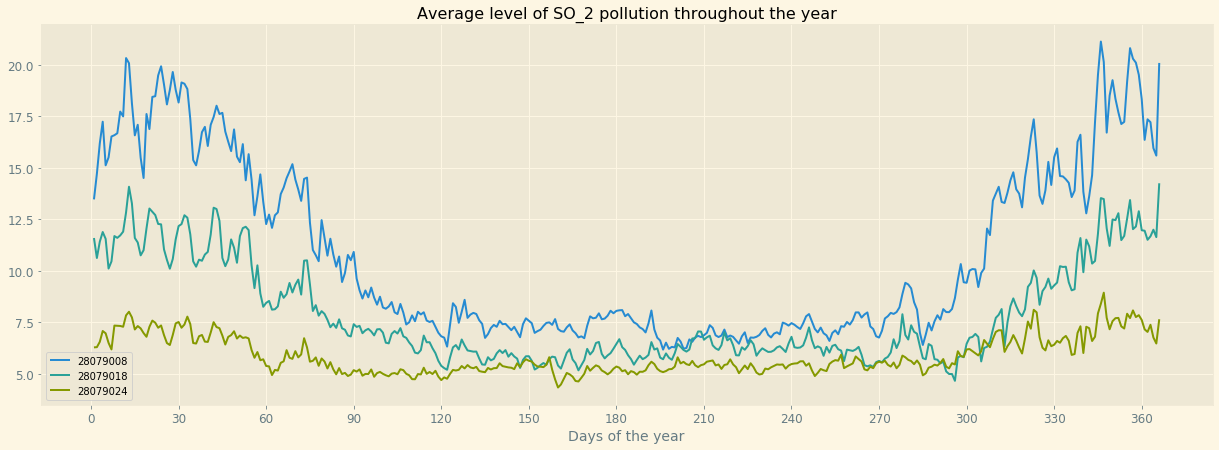

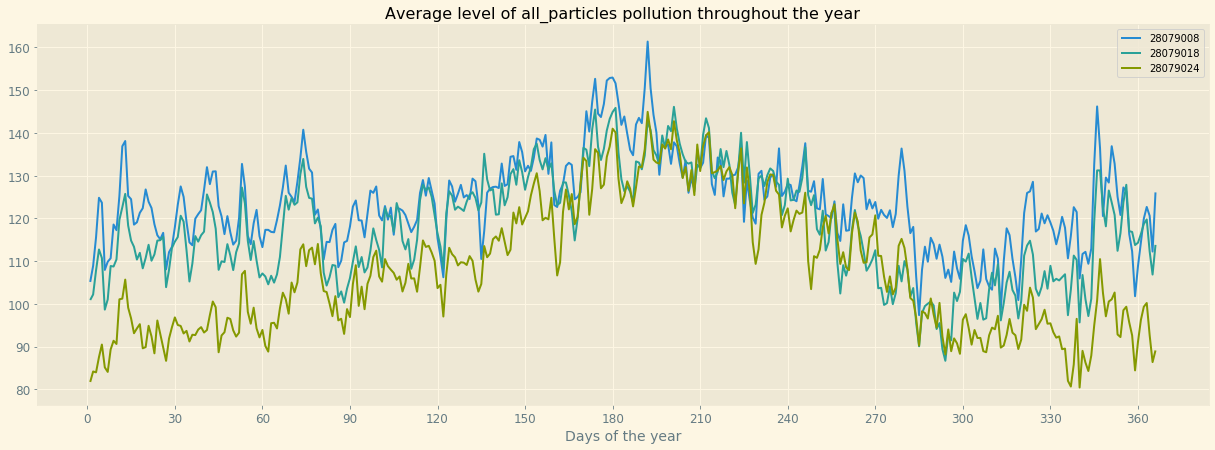

In [23]:
# Plot levels of polution throughout the days of the year for each particle of interest in 3 random stations of interest

for particle in particles_of_interest:
    fig, ax = plt.subplots(figsize=(21, 7))
    for station in sample_stations: 
        ax.plot(dayofyear_df.loc[dayofyear_df['station'] == station, particle], label=station)
        plt.title(f'Average level of {particle} pollution throughout the year') 
        plt.xlabel('Days of the year')
        plt.xticks(np.arange(0, 365, step=30))
        plt.legend(sample_stations)

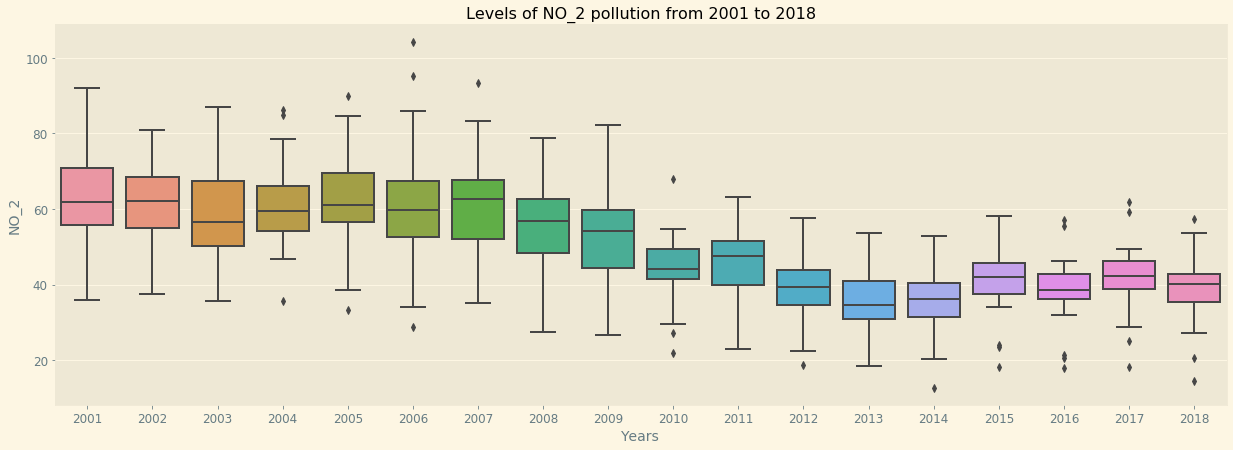

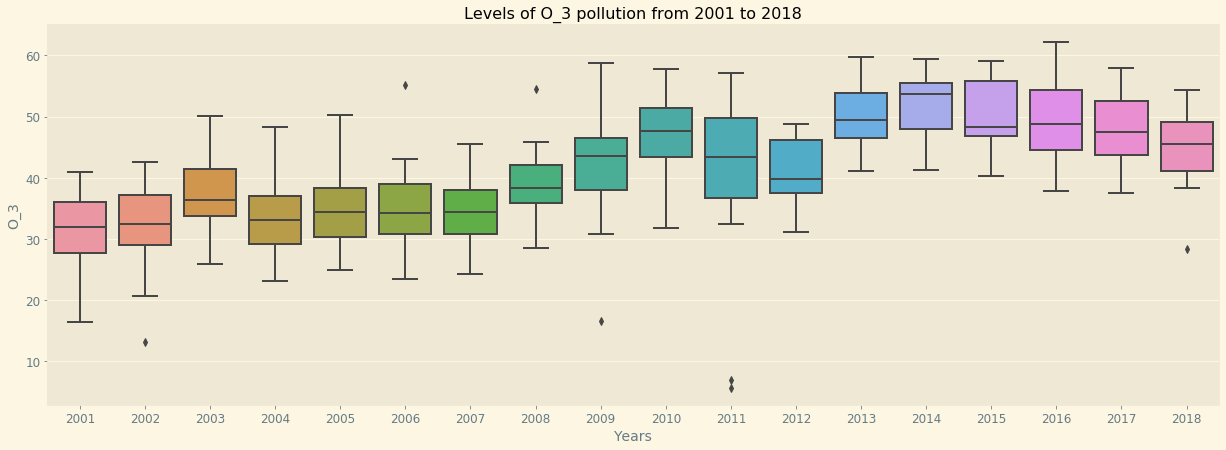

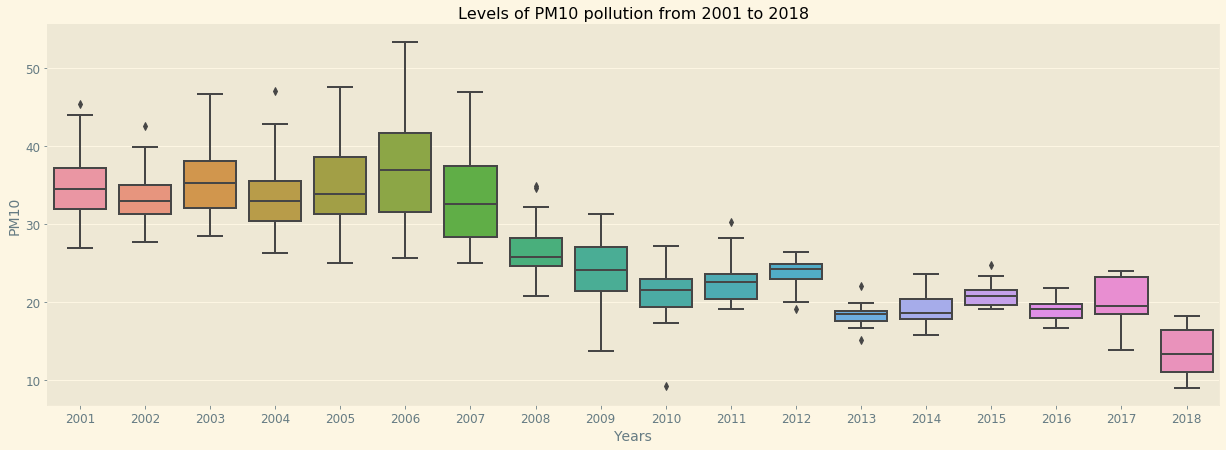

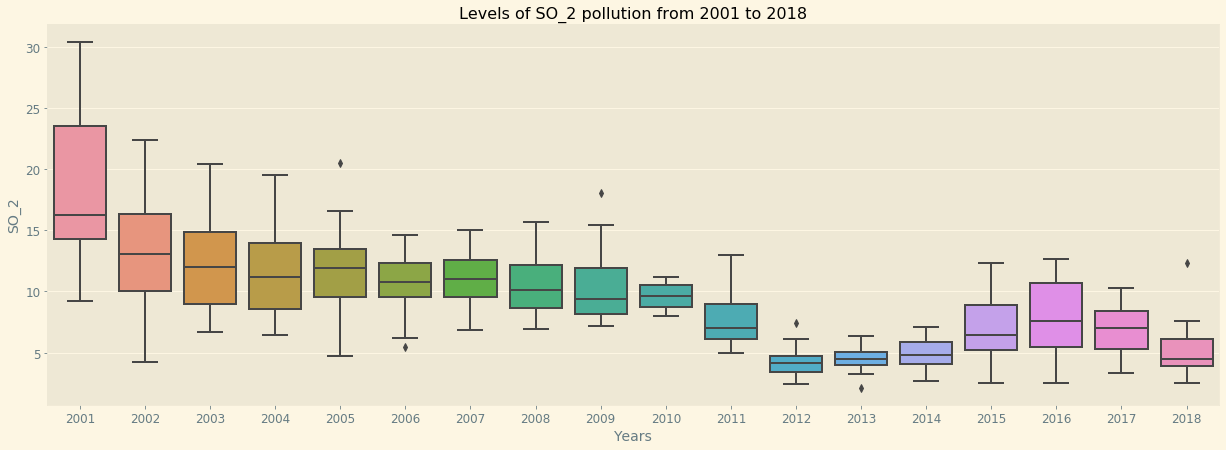

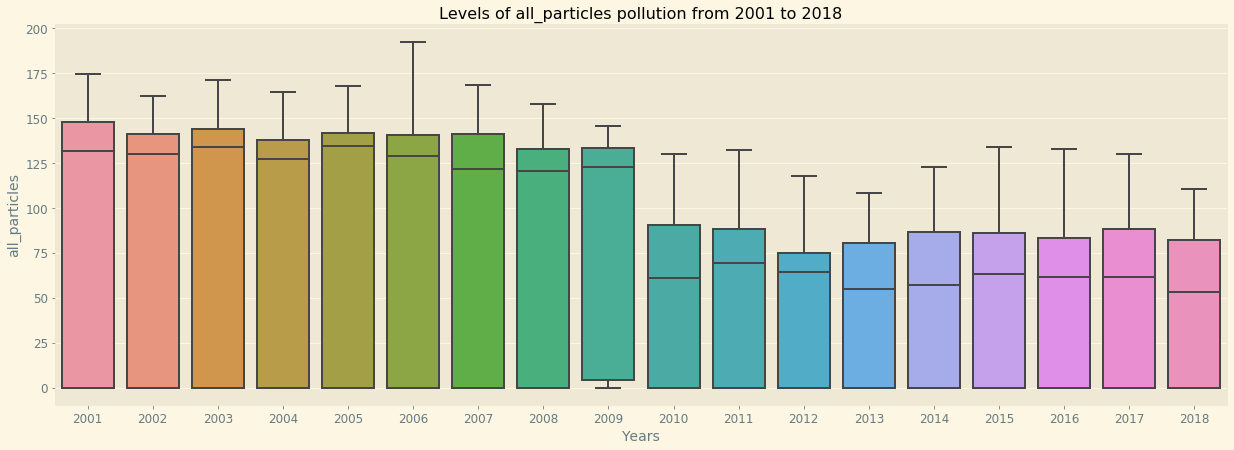

In [24]:
# Plot levels of pollution for each particle of interest throughout the years

for particle in particles_of_interest:
    fig, ax = plt.subplots(figsize=(21,7))
    sns.boxplot(multiyear_df.index, multiyear_df[particle], ax=ax)
    plt.title(f'Levels of {particle} pollution from 2001 to 2018') 
    plt.xlabel('Years')

### Visualise distribution and ranges of pollution levels for stations of interest

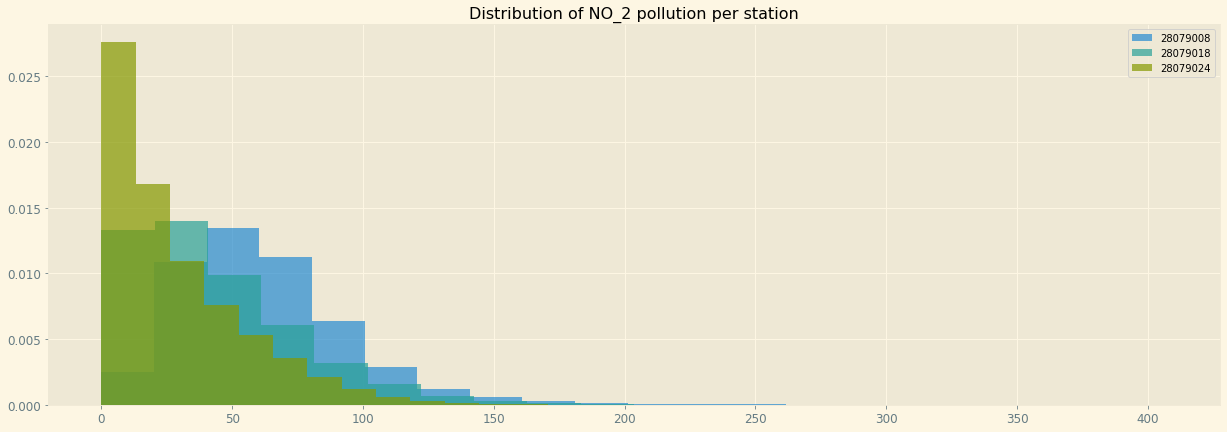

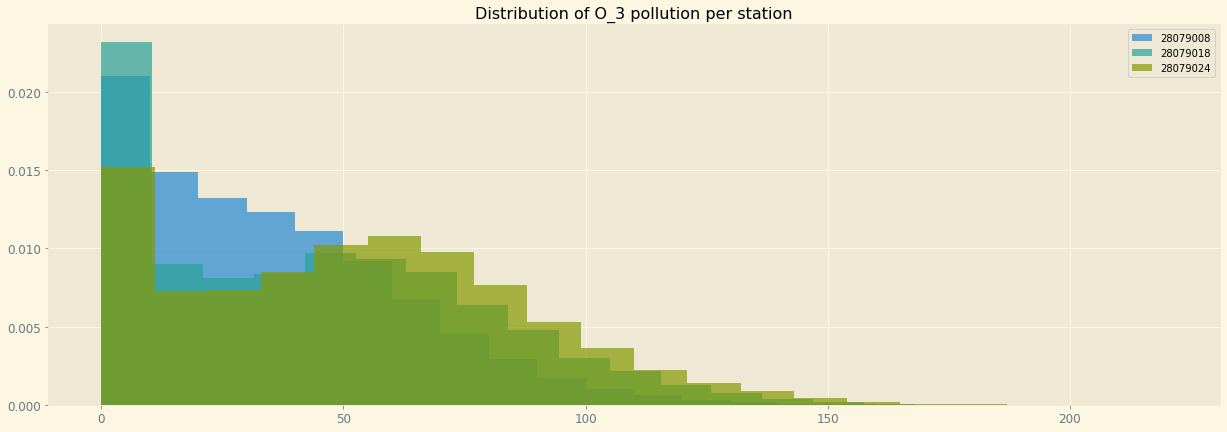

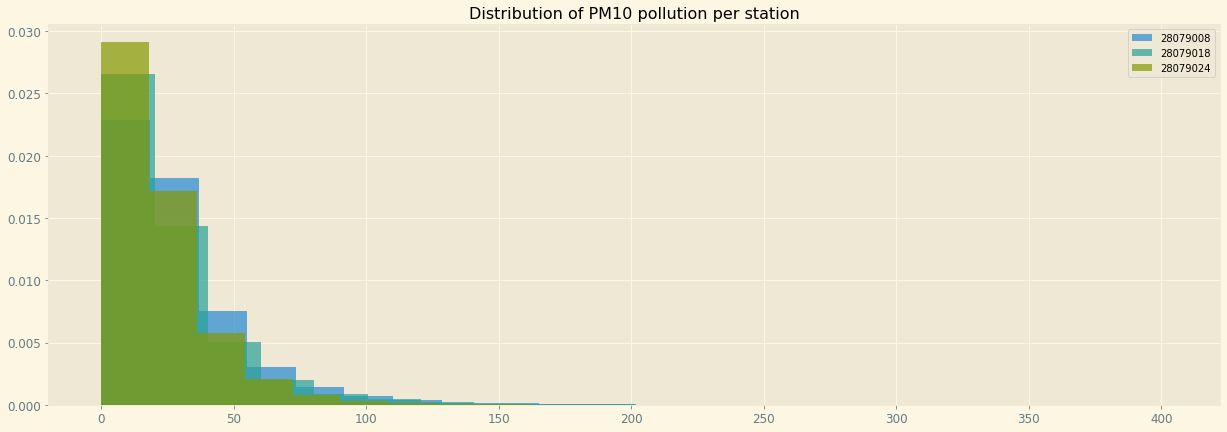

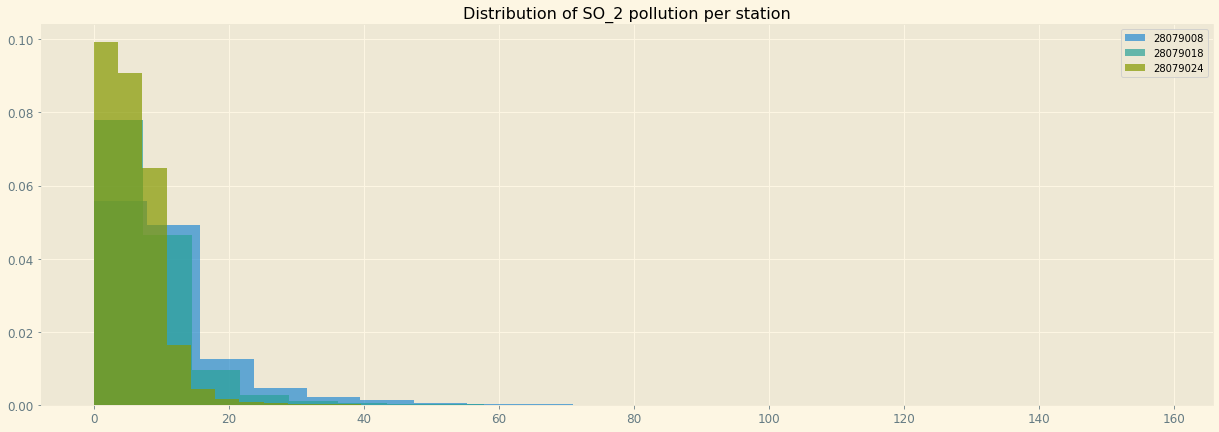

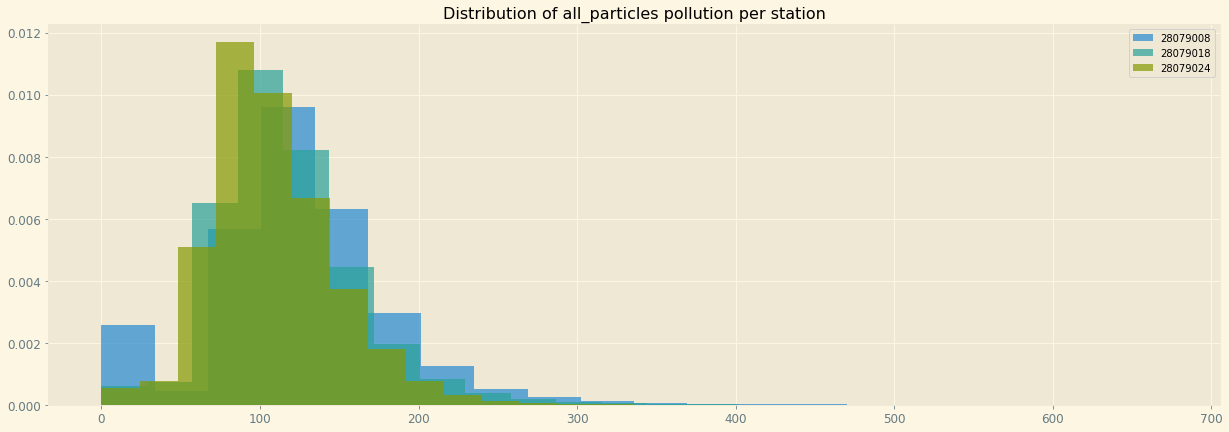

In [25]:
# Plot distribution of pollution for each particle of interest in 3 random stations of interest

for particle in particles_of_interest:
    fig, ax = plt.subplots(figsize=(21, 7))
    for station in sample_stations: 
        ax.hist(df_select.loc[df_select['station'] == station, particle], density=True, bins=20, alpha=0.7)
        plt.title(f'Distribution of {particle} pollution per station') 
        plt.legend(sample_stations)

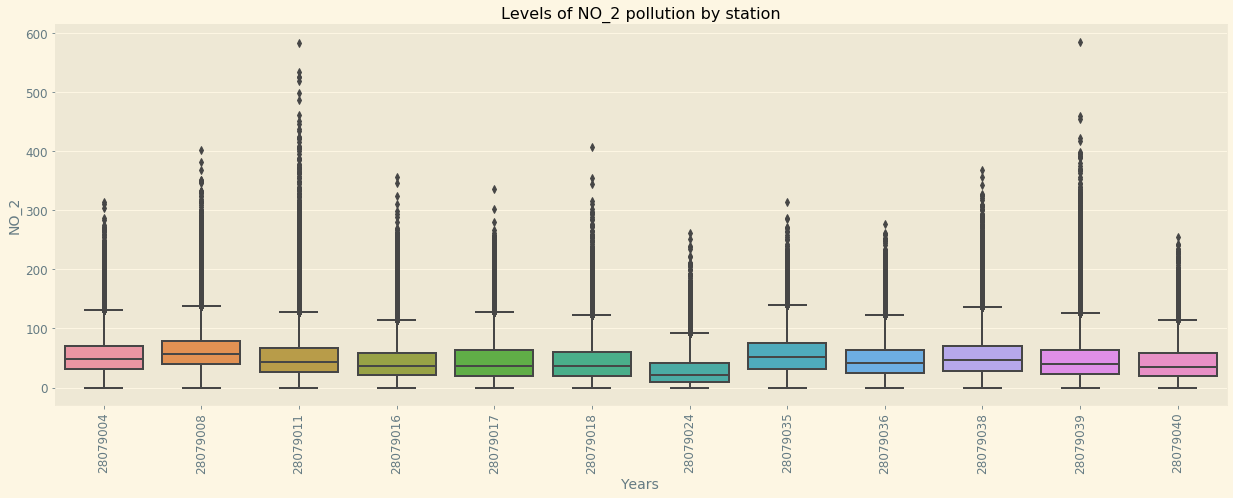

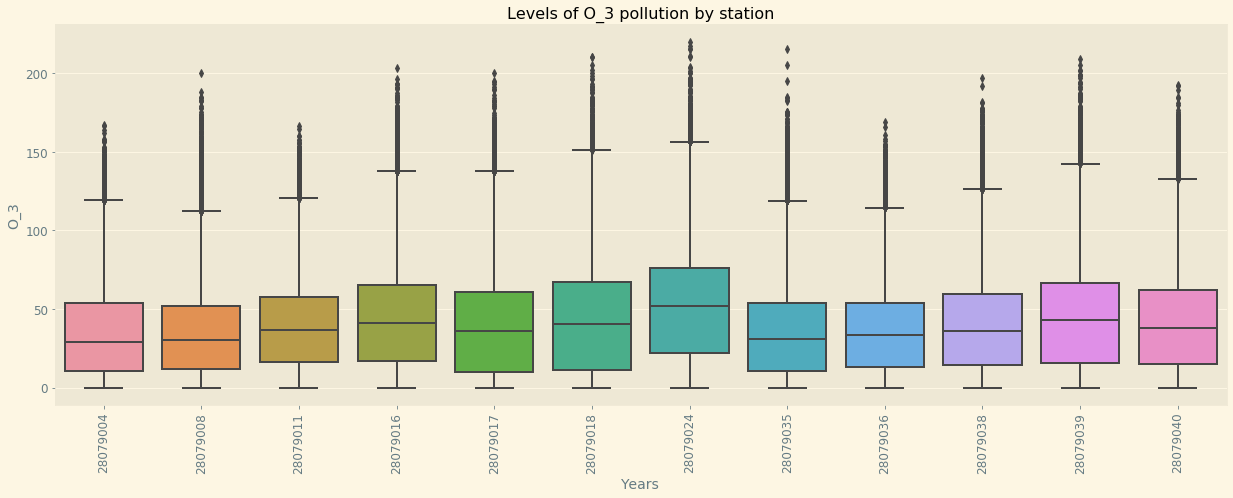

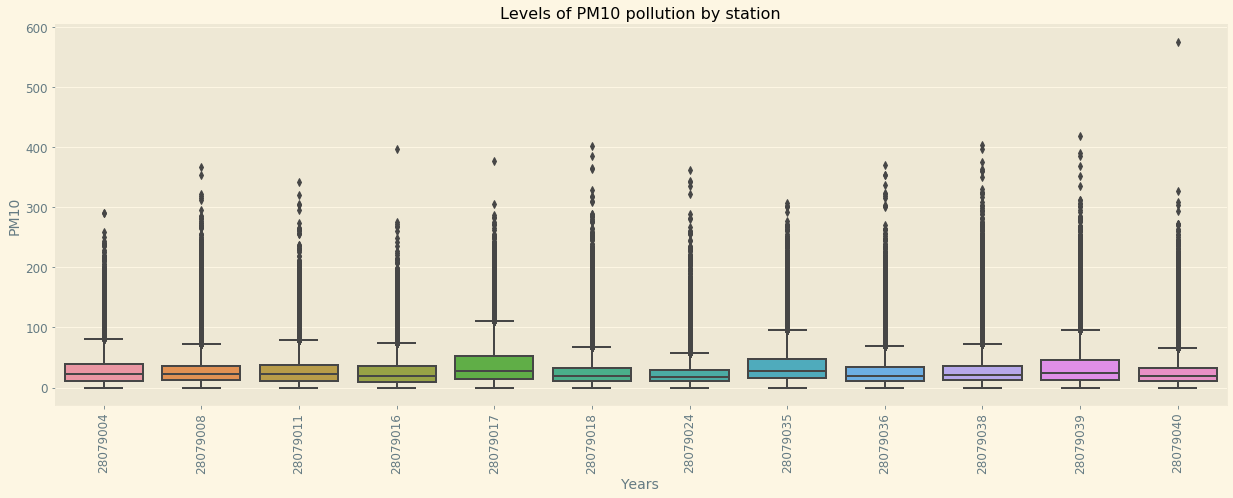

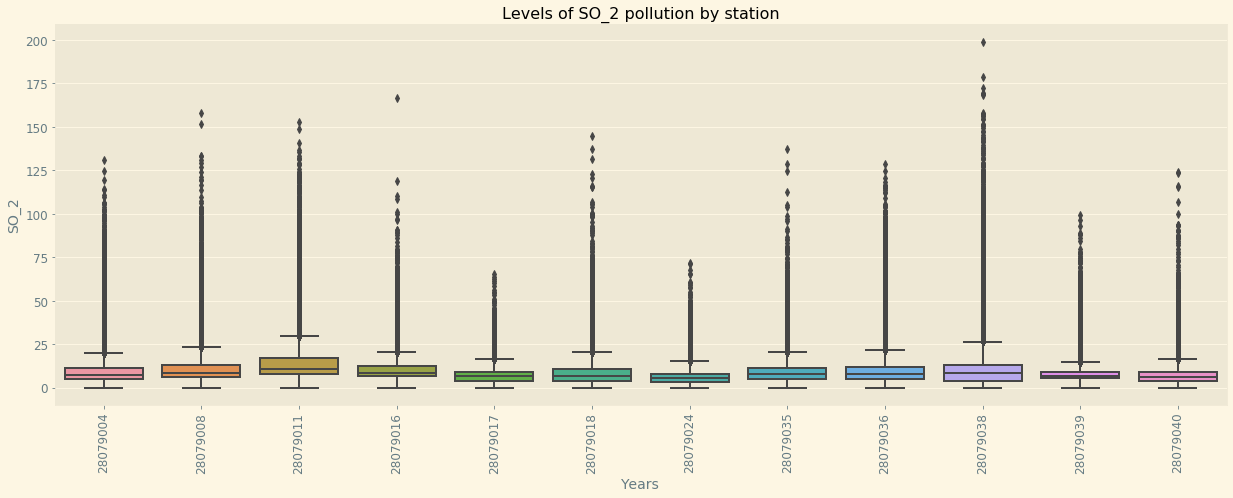

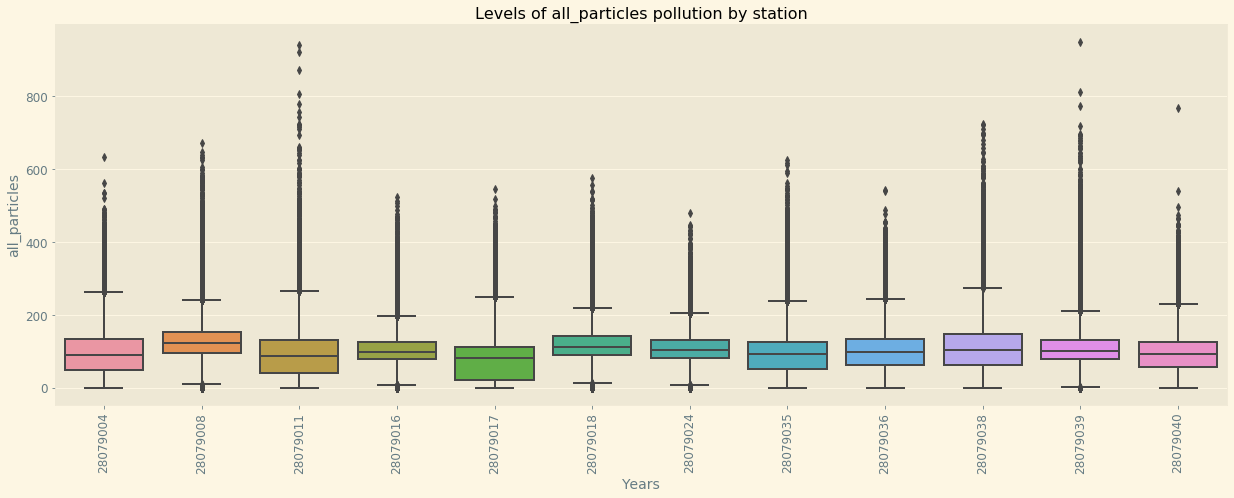

In [26]:
for particle in particles_of_interest:
    fig, ax = plt.subplots(figsize=(21,7))
    sns.boxplot(df_select[df_select['station'].isin(stations_of_interest)]['station'], \
                df_select[df_select['station'].isin(stations_of_interest)][particle])
    plt.xticks(rotation='90')
    plt.title(f'Levels of {particle} pollution by station') 
    plt.xlabel('Years')